# HEEL # 4rd p30/50 PCA1/1 Crop.7 Affine.7 + Heel HPLv3 

## annotation_1405_HPLv2Heel_Good.csv 沿用 ，但toe改回1345

# 20210303-085724

# 101 Course of transfer learning and Fine tune 2021-01-01

## [How-to] 1. k-fold for cross validation

#### Create a simple k-fold for train classification model.

* In this short course you learned:

* data pipline

* transfer learning

* fine tune

* callbacks


todo: move to note.py


In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.style.use("bmh")

import cv2
import tensorflow as tf

from datetime import datetime
import seaborn as sns

import errno

# albumentations
from functools import partial
# from albumentations import (
#     Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
#     Rotate
# )
import albumentations as A

# from adabelief_tf import AdaBeliefOptimizer

In [2]:
print(tf.__version__)
print(cv2.__version__)

2.3.1
4.3.0


In [3]:
from pytictoc import TicToc

t_timer = TicToc() #create instance of class

t_timer.tic() #Start timer

### 2. Parameters

#### Image size, Batch size, toe/heel-offset.

In [4]:
BATCH_SIZE = 64 # 16 #32 #64 #128 #32 #64 #todo: reduce the BS maybe help to reduce the loss
img_height = 120 #512 #224 #100
img_width = 120 #512 #224 #100

y_offset_toe = 80
y_offset_heel = 280 #400-120=280

#### tf MirroredStrategy seting

In [5]:

# tf MirroredStrategy seting
strategy = tf.distribute.MirroredStrategy()
REPLICAS = strategy.num_replicas_in_sync
print('\nNumber of REPLICAS: {}\n'.format(REPLICAS))


MULTI_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
print('BATCH_SIZE: {}, MULTI_BATCH_SIZE: {}'.format(BATCH_SIZE, MULTI_BATCH_SIZE))



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)

Number of REPLICAS: 1

BATCH_SIZE: 64, MULTI_BATCH_SIZE: 64


In [6]:
# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

### 3. Create the training dataset W/ croped


#### Load samples as data-farame

In [7]:

# # data-org #
# ann = 'annotation_1424_merge.csv'
# im_p = 'train/images/'
# CSVNAME = ""


# # data-org-augm#
# ann = 'annotation_2848_augm.csv'
# im_p = 'train_augm/images/'
# CSVNAME = ""


# # data-train # # current best dataset.1424-79.
# ann = 'annotation_1345_good.csv'
# im_p = 'train/images/'
# CSVNAME = "K1345K10L195"

# data-augm #
# ann = 'annotation_2690_augm.csv'
# im_p = 'train_augm/images/'
# CSVNAME = ""


# # data-train-HPL-1123
# ann = 'annotation_1123_HPL_Good.csv'
# im_p = 'train/images/'
# CSVNAME = ""

# data-train # # HPLv2Toe
ann = 'annotation_1405_HPLv2Heel_Good.csv'
im_p = 'train/images/'
CSVNAME = "HPLv2heelK10L195"


df = pd.read_csv(ann)
df[1120:]

images  x1   y1  x2   y2
1120  image_6139.png  49  138  74  384
1121  image_6140.png  64  140  34  371
1122  image_6141.png  48  138  69  385
1123  image_6142.png  60  140  30  370
1124  image_6143.png  60  123  71  384
...              ...  ..  ...  ..  ...
1400  image_6420.jpg  63  158  46  381
1401  image_6421.jpg  53  157  76  376
1402  image_6422.jpg  49  154  33  375
1403  image_6423.jpg  64  149  76  381
1404  image_6424.jpg  55  147  36  385

[285 rows x 5 columns]

In [8]:
len(df)

1405

#### Shuffle and reset index

In [9]:
# reset index
df = df.sample(frac=1).reset_index(drop=True)

In [10]:
df.head(10)

images  x1   y1  x2   y2
0  image_6008.png  64  151  32  384
1  image_0945.png  64  132  31  370
2  image_0614.jpg  63  150  82  368
3  image_6063.png  70  134  72  382
4  image_6048.png  61  138  38  381
5  image_0439.png  57  110  72  381
6  image_6080.png  57  137  33  365
7  image_0063.png  68  119  91  375
8  image_0034.png  60  145  31  382
9  image_6352.jpg  66  171  37  368

See, the image_####.jpg now are random.

#### Create tf.dataset (DS)

In [11]:
# from dataframe
list_ds = tf.data.Dataset.from_tensor_slices((df['images'], df['x1'], df['y1'], df['x2'], df['y2']))
# list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle

In [12]:
len(list_ds)#.shape() #take(1)

1405

In [13]:
# check The type specification of an element of this dataset.
list_ds.element_spec


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [14]:
for f,x1,y1,x2,y2 in list_ds.take(5):
    print(f'take sample: {f} {x1} {y1} {x2} {y2}')

take sample: b'image_6008.png' 64 151 32 384
take sample: b'image_0945.png' 64 132 31 370
take sample: b'image_0614.jpg' 63 150 82 368
take sample: b'image_6063.png' 70 134 72 382
take sample: b'image_6048.png' 61 138 38 381


In [15]:
# use np decode to UTF-8
print(f.numpy().decode('UTF-8'))

image_6048.png


In [16]:
len(list_ds)

1405

#### Check ds iterator for consuming

In [17]:
# create a Python iterator

it_list_ds = iter(list_ds) # Make sure iter ds only once.

In [18]:
# using iter and consuming its elements using next: every print different image name.

for i in range(4):
    image, x1, y1, x2, y2 = next(it_list_ds)
    print(image.numpy(), x1.numpy(), y1.numpy())

b'image_6008.png' 64 151
b'image_0945.png' 64 132
b'image_0614.jpg' 63 150
b'image_6063.png' 70 134


In [19]:
# image_batch, label_batch = valid_ds_pre_s.as_numpy_iterator().next()
# pred = model.predict_on_batch(image_batch)


for i in range(4):
    image, x1, y1, x2, y2 = list_ds.as_numpy_iterator().next()# every time create a new iter, so need put iter out of above cell.
    print(image, x1, y1, x2, y2)
    
iter_test_list = list_ds.as_numpy_iterator()
print("===== Create iterator once and pull out to above cell. =====")
for i in range(4):
    image, x1, y1, x2, y2 = iter_test_list.next()
    print(image, x1, y1, x2, y2)


b'image_6008.png' 64 151 32 384
b'image_6008.png' 64 151 32 384
b'image_6008.png' 64 151 32 384
b'image_6008.png' 64 151 32 384
===== Create iterator once and pull out to above cell. =====
b'image_6008.png' 64 151 32 384
b'image_0945.png' 64 132 31 370
b'image_0614.jpg' 63 150 82 368
b'image_6063.png' 70 134 72 382


#### Process path to image tensor in DS

In [20]:

'''
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
#     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
    return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
'''

#
# map list to ds, Toe part.
#

def decode_crop_png_toe(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_toe(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_toe(img)
    return img, [x1,y1-y_offset_toe]#Original [0,120]
    #return img, x1, y1-y_offset_toe #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x1/120,(y1-y_offset_toe)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] , no help.

#
# map list to ds, Heel part.
#

def decode_crop_png_heel(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_heel(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_heel(img)
    return img, [x2,y2-y_offset_heel]#Original [0,120]
    #return img, x2, y2-y_offset_heel #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x2/120,(y2-y_offset_heel)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] , no help.

#
# test how to put parameters to map
#

def t_ds_map(file_path,x1,y1,x2,y2):
#     img = get_img('train/images/' + str(file_path))
#     print(file_path)
    return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [21]:
# Toe ds
train_ds_map_toe = list_ds.map(process_path_toe, num_parallel_calls=AUTOTUNE)

# Heel ds
train_ds_map_heel = list_ds.map(process_path_heel, num_parallel_calls=AUTOTUNE)

In [22]:
# for img, xy in train_ds_map_toe.take(1):
#     print(f'take sample: {xy}')
    
# print('f', f.dtype)
# print('xy', xy.dtype)

# for img, x, y in train_ds_map_toe.take(1):
#     print(f'take sample: {x} {y}')
    
# print('img', img.dtype)
# print('x', x.dtype)
# x

for img, [x, y] in train_ds_map_toe.take(1):
    print(f'take sample: {x} {y}')
    
print('f', f.dtype)
print('x', x.dtype)

take sample: 64 71
f <dtype: 'string'>
x <dtype: 'int64'>


In [23]:
x

<tf.Tensor: shape=(), dtype=int64, numpy=64>

In [24]:
# for f,x1,y1,x2,y2 in train_ds_map.take(5):
#     print(f'take sample: {f} {x1} {y1} {x2} {y2}')

#### [new] Split train_ds_pre with ratio of validation %

[ToDo 20210201] keep orignal validation in 0.1, but augmenting train_ds in input layer or in the tf.ds.

[2021-02-23] New k-split ds

In [25]:
# # split Toe
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.2)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)#no help

# train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
# valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

# print(f'whole samples = {len(train_ds_map_toe)}')
# print(f'val_size = {val_size}')

# print('ds_train = ', tf.data.experimental.cardinality(train_ds_map_toe_s).numpy())
# print('ds_valid = ', tf.data.experimental.cardinality(valid_ds_map_toe_s).numpy())

In [26]:
# # split Heel
# val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.2)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.1)


# train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
# valid_ds_map_heel_s = train_ds_map_heel.take(val_size)

# print(len(train_ds_map_heel))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_map_heel_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_map_heel_s).numpy())

In [27]:
# ## testing cell
# kf = []
# for k in range(5):
#     kf.append(train_ds_map_heel.shard(num_shards=5, index=k))
#     print("k =", k,"num=", tf.data.experimental.cardinality(kf[k]).numpy())

In [28]:
# kf

In [29]:

# for img, [x,y] in kf[1].take(1):
#     print(f'take sample: {x} {y}')
    
# print('img', img.dtype)
# print('x', x.dtype)
# print('y', y.dtype)

In [30]:
# ## testing cell

# range_k_0 = train_ds_map_heel.window(5)

# print(len(range_k_0))
# print(tf.data.experimental.cardinality(range_k_0).numpy())

In [31]:
# ## testing cell

# def get_train_valid_k_split():
#     x = tf.data.Dataset.range(1000)
#     val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
    
#     for k in range(5):
#         train_num = x.take(val_size + k*val_size)
#         valid_num = x.skip(k*val_size)
        
#         print("k=", k)
#         print(tf.data.experimental.cardinality(train_num).numpy())
#         print(tf.data.experimental.cardinality(valid_num).numpy())
    
    
# get_train_valid_k_split()

In [32]:
## testing cell

# 
# tf.slice
# tf.data.experimental.choose_from_datasets


# x = list_ds
# val_size = int(tf.data.experimental.cardinality(list_ds).numpy() * 0.2)
x = tf.data.Dataset.range(10)

def check_KFold_ds(x, K=5):
    
    val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
    print("val_size=", val_size)
    
    for k in range(K):
#         k_train = x.take(val_size + k*val_size)
#         k_valid = x.skip(k*val_size)
#         k_train = tf.slice(x, k*val_size, val_size) #only for pure tensors not 
#         k_valid = x.skip(k*val_size)

        # may skip twicce to performe kflod
        t_take = x.take(k*val_size)
        t_skip = x.skip(k*val_size+val_size)
        k_train = t_take.concatenate(t_skip)
        
        v_skip = x.skip(k*val_size)
        k_valid = v_skip.take(val_size)

        print("k =", k,"k*val_size+val_size", k*val_size+val_size, "k_train num=", tf.data.experimental.cardinality(k_train).numpy())


        # x = tf.data.Dataset.range(10)
#         for n in k_train:
#             print(n.numpy())
#         for n in k_valid:
#             print(n.numpy())
        
        # list_ds
#         for img, x1, y1, x2, y2 in k_train:
#             print(x1, y1)

        # train_ds_map_toe
#         for img, (x, y) in k_train:
#             print(x.numpy(), y.numpy())

    
    
    
check_KFold_ds(x)
# check_KFold_ds(list_ds)    
# check_KFold_ds(train_ds_map_toe)

val_size= 2
k = 0 k*val_size+val_size 2 k_train num= 8
k = 1 k*val_size+val_size 4 k_train num= 8
k = 2 k*val_size+val_size 6 k_train num= 8
k = 3 k*val_size+val_size 8 k_train num= 8
k = 4 k*val_size+val_size 10 k_train num= 8


In [33]:
# x = tf.data.Dataset.range(10)
# val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
# print("val_size=", val_size)

def get_KFold_ds(x, K=0):
        
    k = K
    # may skip twicce to perform kflod
    # train ds
    t_take = x.take(k*val_size)
    t_skip = x.skip(k*val_size+val_size)
    k_train = t_take.concatenate(t_skip)
    # val ds
    v_skip = x.skip(k*val_size)
    k_valid = v_skip.take(val_size)

    return k_train, k_valid

In [34]:
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.2)
val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)
t, v = get_KFold_ds(train_ds_map_toe, 1)

print(tf.data.experimental.cardinality(t).numpy())
print(tf.data.experimental.cardinality(v).numpy())

# for n in v:
#     print(n.numpy())

1265
140


In [35]:
train_ds_map_toe

<ParallelMapDataset shapes: ((120, 120, 3), (2,)), types: (tf.uint8, tf.int64)>

In [36]:
v

<TakeDataset shapes: ((120, 120, 3), (2,)), types: (tf.uint8, tf.int64)>

# Albumentation pipeline

In [37]:

# # for NO keypoint augment
# transforms = A.Compose([
# #             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=65, quality_upper=100, p=0.5),#A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5)
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
# #             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=1),#A.FancyPCA(alpha=0.1, always_apply=False, p=0.5)
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5), #0.8~0.99 may better
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=(1, 8), tile_grid_size=(8, 8), always_apply=False, p=0.5), #A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
# #             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
# #             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
# #             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
# #             A.HorizontalFlip(),
    
#             # try other augm, seems to strong...
#             A.RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
#             A.Equalize(always_apply=False, p=0.5, mode='cv', by_channels=True),
#             A.MultiplicativeNoise(always_apply=False, p=0.5, multiplier=(0.8, 1.5), per_channel=False, elementwise=False),
#             A.RandomFog(always_apply=False, p=0.5, fog_coef_lower=0.2, fog_coef_upper=0.3, alpha_coef=0.25),

# ])


# def aug_fn(image, img_size):
#     data = {"image":image}
#     aug_data = transforms(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label

# def set_shapes(img, label, img_shape=(120,120,3)):
#     img.set_shape(img_shape)
# #     label.set_shape([]) # commited for go around error
#     return img, label





# # for NO keypoint augment AND for OneOf[] for better heel loss.
# transforms_oneof = A.Compose(A.OneOf([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
#             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
#             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
#             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=.5)
# #             A.HorizontalFlip(),
#             ]),p=0.5)


# def aug_fn_oneof(image, img_size):
#     data = {"image":image}
#     aug_data = transforms_oneof(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data_oneof(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn_oneof, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label




# # Testing keypoints augment
# transforms = A.Compose([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA (alpha=0.1, always_apply=False, p=1),
#             A.Downscale (scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
#             A.HorizontalFlip(p=0.5),
#             ]
#             , 
#             keypoint_params=A.KeypointParams(format='xy'),  #currently not works for tf.ds yet.
#             )





# Testing keypoints augment
transforms = A.Compose([
            A.RandomBrightness(limit=0.1, p=0.5),
            A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.RandomContrast(limit=0.2, p=0.5),
            A.FancyPCA(alpha=0.1, always_apply=False, p=1.0),
            A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
            A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
    
            A.HorizontalFlip(p=0.5),
            A.RandomResizedCrop(always_apply=False, height=120, width=120, scale=(0.9, 0.99), ratio=(1.0, 1.0), interpolation=0, p=0.7),#xy become double need change dtype of label. # pp will outside the image.
            A.IAAAffine(scale=0.9, translate_percent=None, translate_px=None, rotate=0.0, shear=0.0, order=1, cval=0, mode='reflect', always_apply=False, p=0.7),
#             A.ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(0.06, 0.06), scale_limit=(-0.1, 0.1), rotate_limit=(-5, 5), interpolation=1, border_mode=2, value=(0, 0, 0), mask_value=None),
    #2021-02-26
#             A.IAAPerspective(scale=(0.05, 0.1), keep_size=True, always_apply=False, p=0.5),#fallout image make train stop. NOT support keypoints!!!!!
            ]
            , 
            keypoint_params=A.KeypointParams(format='xy',remove_invisible=True),  #currently not works for tf.ds yet.
            )

# Testing keypoints augment
# @tf.function
def aug_fn(image, keypoints, img_size):
#     print('Check keypoints aug_fun 00:', keypoints) # Check keypoints aug_fun 00: [[53 58]]
#     data = {"image":image}
    aug_data = transforms(image=image, keypoints=keypoints)
    aug_img = aug_data["image"]
    aug_xy  = aug_data["keypoints"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    
    aug_xy = tf.cast(aug_xy, tf.float32) #有些變形輸出是double
#     print('Check aug_xy:', aug_xy) # Check aug_xy: [(95, 45)] #印到這邊都是對的
    return aug_img, aug_xy 

# @tf.function
def process_data(image, keypoints, img_size):
    
    print('Check keypoints process01:', keypoints, np.shape(keypoints), type(keypoints))
        
#     keypoints = tf.make_ndarray(keypoints)
#     keypoints = np.array(keypoints)
#     keypoints = list(keypoints)
#     keypoints = np.asarray(keypoints, dtype=np.float32)
#     keypoints = tf.make_ndarray(keypoints.op.get_attr('value'))

#     keypoints = tf.reshape(keypoints, [1, 2])
    keypoints = tf.reshape(keypoints, [1, 2]) # for 'convert_keypoint_to_albumentations'
#     keypoints = np.reshape(keypoints, (1, 2))#not support tensor with np.call.

    print('Check keypoints process02:', keypoints, np.shape(keypoints), type(keypoints))

#     aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     aug_img, aug_xy = tf.py_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])#for tensors.
    aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.float32])
    print('Check keypoints process03:', aug_xy)
    
    aug_xy = tf.reshape(aug_xy, [2,]) # for 'tf ds tarining'
    print('Check keypoints process04:', aug_xy)
        
    return aug_img, aug_xy 








###  for AToe ###
# some pp will outside of image bcs p2 is close to 400.



# Testing keypoints augment
transforms_AToe = A.Compose([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
    
#             A.RandomBrightness(limit=0.1, p=0.5),
            A.JpegCompression(quality_lower=65, quality_upper=100, p=0.5),#A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5)
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
            A.FancyPCA(alpha=0.1, always_apply=False, p=1),#A.FancyPCA(alpha=0.1, always_apply=False, p=0.5)
            A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5), #0.8~0.99 may better
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
            A.CLAHE(clip_limit=(1, 8), tile_grid_size=(8, 8), always_apply=False, p=0.5), #A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
    
            A.HorizontalFlip(p=0.5),
#             A.RandomResizedCrop(always_apply=False, height=120, width=120, scale=(0.75, 0.9), ratio=(1.0, 1.0), interpolation=0, p=0.5),#xy become double need change dtype of label. # pp will outside the image.
            A.IAAAffine (scale=0.9, translate_percent=None, translate_px=None, rotate=0.0, shear=0.0, order=1, cval=0, mode='reflect', always_apply=False, p=0.7),
#             A.ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(0.06, 0.06), scale_limit=(-0.1, 0.1), rotate_limit=(-5, 5), interpolation=1, border_mode=2, value=(0, 0, 0), mask_value=None),
            ]
            , 
            keypoint_params=A.KeypointParams(format='xy',remove_invisible=True),  #currently not works for tf.ds yet.
            )


# Testing keypoints augment
# @tf.function
def aug_fn_AToe(image, keypoints, img_size):
#     print('Check keypoints aug_fun 00:', keypoints) # Check keypoints aug_fun 00: [[53 58]]
#     data = {"image":image}
    aug_data = transforms_AToe(image=image, keypoints=keypoints)
    aug_img = aug_data["image"]
    aug_xy  = aug_data["keypoints"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    
    aug_xy = tf.cast(aug_xy, tf.float32) #有些變形輸出是double
#     print('Check aug_xy:', aug_xy) # Check aug_xy: [(95, 45)] #印到這邊都是對的
    return aug_img, aug_xy 

# @tf.function
def process_data_AToe(image, keypoints, img_size):
    
    print('Check keypoints process01:', keypoints, np.shape(keypoints), type(keypoints))
        
#     keypoints = tf.make_ndarray(keypoints)
#     keypoints = np.array(keypoints)
#     keypoints = list(keypoints)
#     keypoints = np.asarray(keypoints, dtype=np.float32)
#     keypoints = tf.make_ndarray(keypoints.op.get_attr('value'))

#     keypoints = tf.reshape(keypoints, [1, 2])
    keypoints = tf.reshape(keypoints, [1, 2]) # for 'convert_keypoint_to_albumentations'
#     keypoints = np.reshape(keypoints, (1, 2))#not support tensor with np.call.

    print('Check keypoints process02:', keypoints, np.shape(keypoints), type(keypoints))

#     aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     aug_img, aug_xy = tf.py_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])#for tensors.
    aug_img, aug_xy = tf.numpy_function(func=aug_fn_AToe, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.float32])
    print('Check keypoints process03:', aug_xy)
    
    aug_xy = tf.reshape(aug_xy, [2,]) # for 'tf ds tarining'
    print('Check keypoints process04:', aug_xy)
        
    return aug_img, aug_xy 




def set_shapes(img, label, img_shape=(120,120,3)):
    img.set_shape(img_shape)
#     label.set_shape([]) # commited for go around error
    return img, label

#### prepare train_ds_prefetch

In [38]:
def configure_for_performance_cache_train(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
        ds = ds.map(partial(process_data, img_size=120),num_parallel_calls=AUTOTUNE)
        ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


def configure_for_performance_cache_train_AToe(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
        ds = ds.map(partial(process_data_AToe, img_size=120),num_parallel_calls=AUTOTUNE)
        ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds





# def configure_for_performance_cache_train_oneof(ds, cache=True, augment=False):

    
#     """#TODO: need to check the parse logic of ds.cache.
#     if cache:
#         print("Check cache-f1 to file:", cache)
#         if isinstance(cache, str):
#             ds = ds.cache(cache)
#             print("Check cache-f2 to file:", cache)
#     else:
#         ds = ds.cache()
#         print("Check cache in memory:", cache)
#     """    
#     if cache:
#         ds = ds.cache()
#         print("Check cache in memory:Y", cache)
#     else:
#         print("Check cache in memory:N", cache)
        
#     if augment:
#         ds = ds.map(partial(process_data_oneof, img_size=120),num_parallel_calls=AUTOTUNE)
#         ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
#         print("Check augment :Y", augment)
#     else:
#         print("Check augment :N", augment)
    
#     #ds = ds.repeat()#TODO:2020-12-14: test
#     #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
#     ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
#     ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
#     print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
#     return ds




def configure_for_performance_cache_val(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache
    TODO:test remove ds.shuffle from val_ds.
    .
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
#         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
        ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


In [39]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # Toe ds_pre
# train_ds_pre_toe = configure_for_performance_cache_train(train_ds_map_toe)

# # Heel ds_pre
# train_ds_pre_heel = configure_for_performance_cache_val(train_ds_map_heel)

#### All split ds_prefetch
* train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
* valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

* train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
* valid_ds_map_heel_s = train_ds_map_heel.take(val_size)


In [40]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # Toe ds_pre
# train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
# valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)

# # Heel ds_pre
# train_ds_pre_heel_s = configure_for_performance_cache_train(train_ds_map_heel_s, augment=True)
# valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)

#### Check ds_prefetch samples

In [41]:
# # create it_ds once
# it_train_ds_pre_toe_s = iter(train_ds_pre_toe_s)

In [42]:
# %%time

# # for albu keypoint

# # for original return aug_img, , aug_xy 


# image_batch, label_batch = next(it_train_ds_pre_toe_s)

# fig = plt.figure(figsize=(8, 8))
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')


In [43]:
# # create it_ds once
# it_train_ds_pre_heel_s = iter(train_ds_pre_heel_s)

In [44]:
# %%time

# # for albu keypoint

# # for original return aug_img, , aug_xy 


# image_batch, label_batch = next(it_train_ds_pre_heel_s)

# fig = plt.figure(figsize=(8, 8))
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')

In [45]:
# # create it_ds once
# it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)

In [46]:
# %%time

# # for albu keypoint

# # for return aug_img, aug_xy 


# image_batch, label_batch = next(it_valid_ds_pre_toe_s)

# plt.figure(figsize=(8, 8))
# # for images, labels in valid_ds_pre_toe_s.take(1):
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')
        

### 3.Loss function

* mae
* euclidean distance
* others


        # 'x' is [[1, 1, 1]
        #         [1, 1, 1]]
        tf.reduce_sum(x) ==> 6
        tf.reduce_sum(x, 0) ==> [2, 2, 2]
        tf.reduce_sum(x, 1) ==> [3, 3]
        the function is default for 2-D array, therefor, in our 1-D [x1,y1] to [x2,y2] the axis should be '0' or just leave it.
        
        tf.sqrt need 	A tf.Tensor of type bfloat16, half, float32, float64, complex64, complex128
        so, convert it first.

should be -> tf.Tensor([56 39], shape=(2,), dtype=int64)

In [47]:
y_true = [10, 10]
y_pred = [10, 20]

# y_true = [1.00000000000000000000123, 10]
# y_pred = [1.0, 10.000000000000000000000000001]

# y_true = [1.0000123, 10]
# y_pred = [1.0, 10.0000321]


In [48]:
# mae

loss_mae = tf.keras.losses.MAE(
    y_true, y_pred
)

loss_mae

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [49]:
# ed

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.constant(y_true) - tf.constant(y_pred)), 0))

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.Variable(y_true) - tf.Variable(y_pred)), 0))

loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

loss_ed

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

In [50]:
def ed_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

# fix NaN in euclidean distance
# tf.maximum(d, 1e-9), to keep atlease is 1e-9.
# def ed_loss(y_true, y_pred):
#     return tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0), 1e-9))


In [51]:
# check the euclidean distance loss
ed_loss(y_true, y_pred).numpy()

10.0

In [52]:
ed_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

#### mean Euclidean distance 

* here the y_true and y_pred is 2-D array. the axis use 1.


* NOTE: LB評分的mean euclidean distance功能，應該跟model.evaluate()一樣so不需重新寫。evaluate()會自動用loss (model.metrics_names)計算後在自動平均，而模型loss我們是用ed-loss取代。

In [53]:
# y_true = [[60, 76],
#        [58, 49 ],
#        [63, 67 ],
#        [58 , 57]]
# y_pred = [[59.927303, 76.471214],
#        [58.056904, 49.98754 ],
#        [63.067844, 67.03861 ],
#        [58.70202 , 57.372707]]

y_true = [[60, 70],
       [70, 80]]
y_pred = [[61, 71],
       [72, 82]]

# y_true = [(60, 70),
#        (70, 80)]
# y_pred = [(61, 71),
#        (72, 82)]

In [54]:
tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [4., 4.]], dtype=float32)>

In [55]:
tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 8.], dtype=float32)>

In [56]:
def ed_metric_2d(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1))


In [57]:
ed_metric_2d(y_true, y_pred).numpy()

array([1.4142135, 2.828427 ], dtype=float32)

In [58]:
ed_metric_2d(y_true, y_pred)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.4142135, 2.828427 ], dtype=float32)>

In [59]:
# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def ed_metric_2d_mean(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)))

In [60]:
# for re-scale back xy 
# return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] 
# return img, [(x2-60)/60,((y2-y_offset_toe)-60)/60]#normalized [-1,1] 

# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def edRescal(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast((y_true*60)+60, tf.float32) - tf.cast((y_pred*60)+60, tf.float32)), 1)))

In [61]:
ed_metric_2d_mean(y_true, y_pred).numpy()

2.1213202

In [62]:
ed_metric_2d_mean(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=2.1213202>

# EFNE Training

maybe mae better than ed loss?

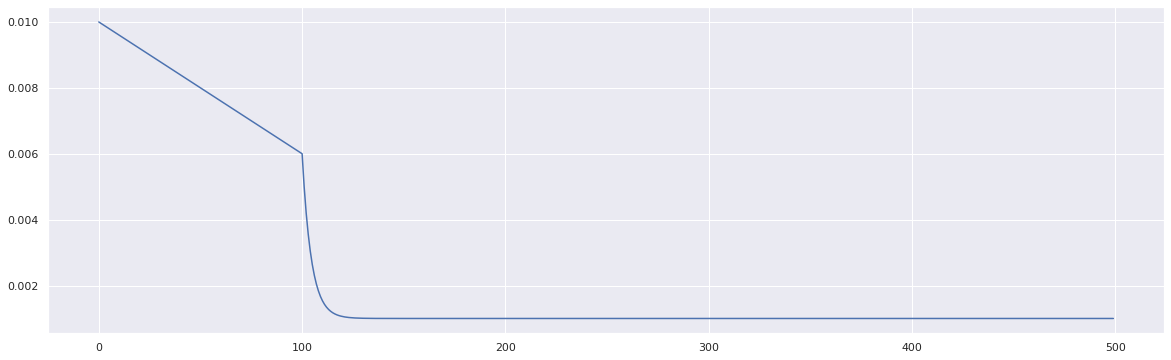

In [63]:
"""dump lr
"""
ep_num_transf = 500



def lrdump(epoch):
    
    #step_size = 100
    lr_max = 0.006
    lr_min = 0.001
    lr_start = 0.01

    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.8

    
    # warm up
    if epoch < lr_init_ep:
        lr = (lr_max - lr_min) / lr_ramp_ep * epoch + lr_min    
        
    elif lr_init_ep -1 < epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

rng = [i for i in range(ep_num_transf)]
y = [lrdump(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [64]:
print('{} ~ {}'.format(min(y), max(y)))

0.001 ~ 0.01


In [65]:
for e, lr in zip(rng,y):
    print('{}\t {}\n'.format(e, lr))

0	 0.01

1	 0.00996

2	 0.00992

3	 0.00988

4	 0.00984

5	 0.0098

6	 0.00976

7	 0.00972

8	 0.00968

9	 0.009640000000000001

10	 0.009600000000000001

11	 0.00956

12	 0.00952

13	 0.00948

14	 0.00944

15	 0.0094

16	 0.00936

17	 0.00932

18	 0.00928

19	 0.00924

20	 0.0092

21	 0.00916

22	 0.00912

23	 0.00908

24	 0.00904

25	 0.009000000000000001

26	 0.00896

27	 0.00892

28	 0.00888

29	 0.00884

30	 0.0088

31	 0.00876

32	 0.00872

33	 0.00868

34	 0.00864

35	 0.0086

36	 0.00856

37	 0.00852

38	 0.00848

39	 0.00844

40	 0.0084

41	 0.00836

42	 0.008320000000000001

43	 0.00828

44	 0.00824

45	 0.0082

46	 0.00816

47	 0.00812

48	 0.00808

49	 0.00804

50	 0.008

51	 0.00796

52	 0.00792

53	 0.00788

54	 0.00784

55	 0.0078

56	 0.0077599999999999995

57	 0.007719999999999999

58	 0.00768

59	 0.00764

60	 0.0076

61	 0.00756

62	 0.007520000000000001

63	 0.0074800000000000005

64	 0.00744

65	 0.0074

66	 0.00736

67	 0.00732

68	 0.00728

69	 0.00724

70	 0.007

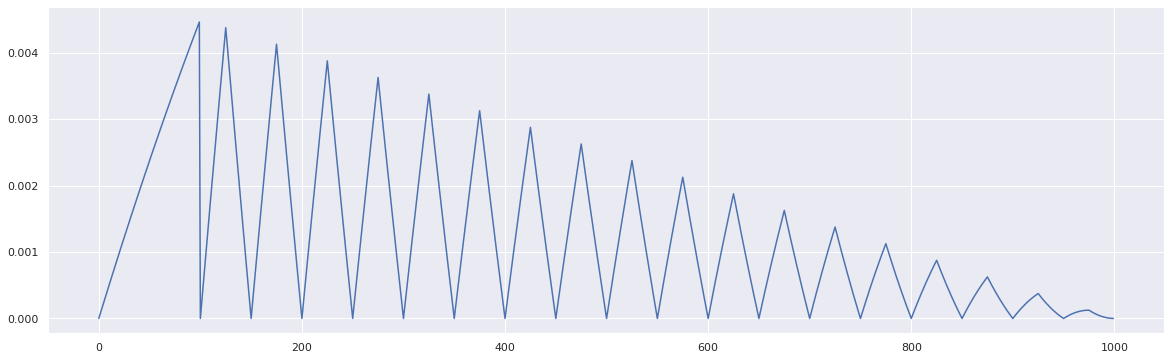

In [66]:
# clr3
# warm up 10% of epoch: it can reduce fall in local min in inital steps.


ep_num = 1000



def clr3(epoch):
    
    
    step_size = 25 # currently best for foot pp
    max_lr = 0.01 # currently best for foot pp
    base_lr = 1e-6 # 1e-6 1e-7

    # warm up
    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.5

    iterations = epoch
    cycle = np.floor(1+iterations/(2*step_size))
    x = np.abs(iterations/step_size - 2*cycle + 1)
    lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))
    
    #todo: boost the lr at initial setps.
#     initial_lr = lambda epoch: lr if epoch > step_size else max_lr
#     initial_lr = lambda epoch: lr if epoch > step_size else boost_lr
#     lr = initial_lr(epoch)
    #todo: boost the lr at fist step_size.
    
    # warm up
    if epoch < lr_ramp_ep:
        lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr
    
    decay = ((epoch+1)/ep_num)
    base_part = 1.001 #1.1
#     print(decay)
    return lr * (base_part-decay) * lr_decay # supressed the lr!


rng = [i for i in range(ep_num)]
y = [clr3(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [67]:
print('{} ~ {}'.format(min(y), max(y)))

2.4999999999999966e-08 ~ 0.004459954505


In [68]:
# 2.4999999999999966e-08 ~ 0.004459954505 1e-2~1e-6 

In [69]:
# %%time
# """
# cosine_decay_restarts是cosine_decay的cycle版本。
# first_decay_steps是指第一次完全下降的step數，
# t_mul是指每一次循環的步數都將乘以t_mul倍，
# m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
# alpha
# """

# from matplotlib.ticker import FormatStrFormatter



# ep_num = 1000



# def CosineDecayCLRWarmUp(epoch):
    
#     #step_size = 25 # currently best for foot pp
#     max_lr = 1e-2 # currently best for foot pp
#     base_lr = 1e-8# 1e-6 1e-7

#     # warm up
#     lr_init_ep = 0
#     lr_ramp_ep = 100
#     lr_sus_ep  = 0
#     lr_decay   = 0.8


#     initial_learning_rate = 1e-2
#     first_decay_steps = 100


#     lr_decayed_fn = (
#       tf.keras.experimental.CosineDecayRestarts(
#           initial_learning_rate,
#           first_decay_steps,
#           t_mul=1.0,
#           m_mul=0.8,
#           alpha = 0.000001,
#           name="CCosineDecayRestarts"))
    
#     # warm up
#     if epoch < lr_ramp_ep:
#         lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
#     else:
#         lr = lr_decayed_fn(epoch)
#     return lr



# rng = [i for i in range(ep_num)]
# y = [CosineDecayCLRWarmUp(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# # plt.ylim(.0000000000000001, .01)# for too large loss
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
# plt.plot(rng, y)

In [70]:
# %%time
# """
# cosine_decay_restarts是cosine_decay的cycle版本。
# first_decay_steps是指第一次完全下降的step數，
# t_mul是指每一次循環的步數都將乘以t_mul倍，
# m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
# alpha
# """

# from matplotlib.ticker import FormatStrFormatter



# ep_num = 1000



# def CosineDecayCLRWarmUpLSW(epoch):
    
#     #step_size = 25 # currently best for foot pp
#     max_lr = 1e-3 # currently best for foot pp
#     base_lr = 1e-6# 1e-6 1e-7

#     # warm up
#     lr_init_ep = 0
#     lr_ramp_ep = 20
#     lr_sus_ep  = 0
#     lr_decay   = 0.8


#     initial_learning_rate = 1e-3
#     first_decay_steps = 50


#     lr_decayed_fn = (
#       tf.keras.experimental.CosineDecayRestarts(
#           initial_learning_rate,
#           first_decay_steps,
#           t_mul=1.0,
#           m_mul=0.8,
#           alpha = 0.000001,
#           name="CCosineDecayRestarts"))
    
#     # warm up
#     if epoch < lr_ramp_ep:
#         lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
#     else:
#         lr = lr_decayed_fn(epoch-lr_ramp_ep)
#     return lr



# rng = [i for i in range(ep_num)]
# y = [CosineDecayCLRWarmUpLSW(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# # plt.ylim(.0000000000000001, .01)# for too large loss
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
# plt.plot(rng, y)

CPU times: user 559 ms, sys: 90.4 ms, total: 650 ms
Wall time: 547 ms


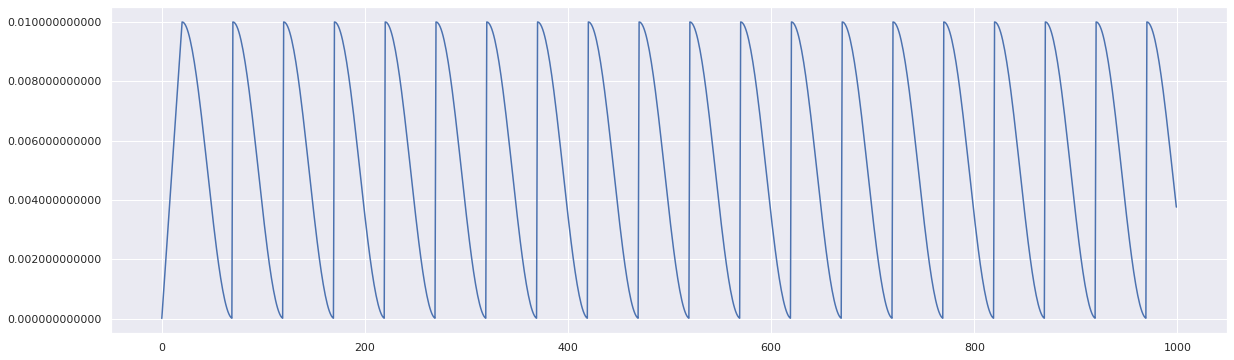

In [71]:
%%time
"""
cosine_decay_restarts是cosine_decay的cycle版本。
first_decay_steps是指第一次完全下降的step數，
t_mul是指每一次循環的步數都將乘以t_mul倍，
m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
alpha
"""

from matplotlib.ticker import FormatStrFormatter



ep_num = 1000



def CosineDecayCLRWarmUpLSW_2(epoch):
    
    #step_size = 25 # currently best for foot pp
    max_lr = 1e-2 # currently best for foot pp
    base_lr = 1e-6# 1e-6 1e-7

    # warm up
    lr_init_ep = 0
    lr_ramp_ep = 20
    lr_sus_ep  = 0
    #lr_decay   = 0.8


    initial_learning_rate = 1e-2
    first_decay_steps = 50


    lr_decayed_fn = (
      tf.keras.experimental.CosineDecayRestarts(
          initial_learning_rate,
          first_decay_steps,
          t_mul=1,
          m_mul=1,
          alpha = 0.000001,
          name="CCosineDecayRestarts"))
    
    # warm up
    if epoch < lr_ramp_ep:
        lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
    else:
        lr = lr_decayed_fn(epoch-lr_ramp_ep)
    return lr



rng = [i for i in range(ep_num)]
y = [CosineDecayCLRWarmUpLSW_2(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
# plt.ylim(.0000000000000001, .01)# for too large loss
ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
plt.plot(rng, y)

In [72]:
print('{} ~ {}'.format(min(y), max(y)))

1e-06 ~ 0.009999999776482582


In [73]:
# 1.8774175103430935e-08 ~ 0.0010000000474974513 1e-3 1e-6

In [74]:
# lr_reduceonplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-12)

In [75]:
# Callback for printing the LR at the end of each epoch.
class PrintLRtoe(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
#     def on_epoch_end(self, epoch, logs=None):
#         print('\n[{}] Learning rate for epoch {} is {}'.format(
#             datetime.now().strftime("%Y%m%d-%H%M-%S"), 
#             epoch + 1,
#             self.model.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_toe.optimizer._decayed_lr(tf.float32).numpy()))

In [76]:
# Callback for printing the LR at the end of each epoch.
class PrintLRheel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
#         print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
#                                               model_heel.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_heel.optimizer._decayed_lr(tf.float32).numpy()))

### Output dir and models

In [77]:
def mk_log_dir(log_dir_name):
    try:
        os.makedirs(log_dir_name)
    except OSError as e:
        print("This log dir exist.")
        if e.errno != errno.EEXIST:
            raise ValueError("we got problem.")

In [78]:
monitor = 'val_loss' #'val_loss' 'val_accuracy' if use ed_loss it still the loss here.

log_dir_name = datetime.now().strftime("%Y%m%d-%H%M%S") 

# mk_log_dir(datetime.now().strftime("%Y%m%d-%H%M%S") )  

In [79]:
# use once at the time
mk_log_dir(log_dir_name)

# Toe

In [80]:
model_name = 'EfficientNetB0'

In [81]:
#get_best_model_name

# best_model_name = './' + model_name + '_bs-' + str(BATCH_SIZE) + '_s-' + str(img_height) + '_' + "ep-{epoch:02d}-vloss-{val_loss:.2f}" +'_best-weight.h5'
# best_model_name = '{model_name}-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#best_model_name = './' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + monitor + '_best.h5'
# best_model_name = './Leaf_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

# best_model_name = './cop' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

def get_best_model_name(th, K):
    return './' + log_dir_name + '/' + th + '_K' + K + '_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_best_' + monitor + '.h5'

# th = 'toe'
# # th = 'heel'

# # print(get_best_model_name(th,K))

# best_model_name = get_best_model_name(th, K)


# best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
#                              save_best_only = True, 
#                              save_weights_only = False,
#                              monitor = monitor, 
#                              mode = 'auto', verbose = 1)
# print('best_model_name:', best_model_name)

In [82]:
logdir = log_dir_name + "/logs/toe/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [83]:
# callbacks = [
# #     tensorboard_callback,
#     best_model_save,
#     tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=20), #patience=step_size or ep_num
# #     lr_reduceonplateau,
#     tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
#     PrintLRtoe()
# ]

In [84]:
# Transfer learning from pre-trained weights
def build_efn_model(outputnum, top_dropout_rate, drop_connect_rate):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(120,120,3),drop_connect_rate=drop_connect_rate) #{'imagenet', None}

    # Freeze the pretrained weights
    base_model.trainable = False
    print("base_model.trainable : ", base_model.trainable)

    # Rebuild top
    gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
    dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
    outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

    # Compile new model
    model = tf.keras.Model(base_model.input, outputs, name=model_name)


#     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
#     fine_tune_at = 20 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model_toe.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)

    
    return model

In [85]:
# """Supervised pre-training 減少每次fold都要重新train的時間
# 只先改toe"""

# # Transfer learning from pre-trained weights
# def load_pretrained_efn_model():
#     pre_model_toe_name = "20210224-200728/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5"
#     model = tf.keras.models.load_model(pre_model_toe_name,compile=False)

#     # Freeze the pretrained weights
#     model.trainable = False
# #     print("base_model.trainable : ", base_model.trainable)

# #     # Rebuild top
# #     gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
# #     BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
# #     dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
# #     outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

# #     # Compile new model
# #     model = tf.keras.Model(base_model.input, outputs, name=model_name)


# #     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
#     fine_tune_at = 4 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             print('layer trainable +1', layer.name)
#             layer.trainable = True

#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
#                     loss=ed_metric_2d_mean)

    
#     return model

In [86]:
def unfreeze_model(model):
#
#'block7a_expand_conv'20 'block6c_expand_conv'50 'block6a_expand_conv'79 'block5b_expand_conv'109 'block4a_expand_conv' 166  block3a_expand_conv 195
#
    model.trainable = True
    set_trainable = False
    for layer in model.layers:
        if layer.name == 'block3a_expand_conv': 
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)


In [87]:
# top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
# drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
# outputnum = 2
# with strategy.scope():
#     model_toe = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)

In [88]:
# len(model_toe.layers)

In [89]:
# tt = 0
# nt = 0
# for layer in model_toe.layers:
#     if layer.trainable:
#         tt +=1
#         print(f'{layer.name}')
#     else:
#         nt +=1
# print(f'tt: {tt}, nt:{nt}')

In [90]:
def count_model_trainOrNot_layers(model, printlayers=False):
    tt = 0
    nt = 0
    for layer in model.layers:
        if layer.trainable:
            tt +=1
            if printlayers:
                print(f'{layer.name}')
        else:
            nt +=1
    print('\n*********************************** Start fine tune ***********************************')
    print(f'tt: {tt}, nt:{nt}, total layers:{tt+nt}')
    print('*********************************** Start fine tune ***********************************')

In [91]:
# count_model_trainOrNot_layers(model_toe)

In [92]:
# model_toe.summary()

In [93]:
# %%time

# # fit the model on all data
# history_toe = model_toe.fit(train_ds_pre_toe_s, 
#                       verbose=1, 
#                       epochs=ep_num_transf, 
#                       validation_data=valid_ds_pre_toe_s, 
#                       callbacks=callbacks)#, validation_split=0.1)

# K-Fold Training

2021-02-23 v1

### Toe K-model

In [94]:
# %%time

# # big K = 5 (fold 0 ~ 4) 
# KFlodNum = 10



# history_toe = []
# history_toe_finetune = []

# #above until 'train_ds_map_toe now' to 'train_ds_map_toe_s', 'valid_ds_map_toe_s'
# for k in range(KFlodNum):
    
    
#     # Split data to train/valid with K-Fold #
#     print("\n \n K = ", k, "\n")
#     # Toe split
#     train_ds_map_toe_s, valid_ds_map_toe_s = get_KFold_ds(train_ds_map_toe, K=k)
    
#     # Toe ds_pre
#     train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
#     valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)
    
    
# #     # heel split
# #     train_ds_map_heel_s, valid_ds_map_heel_s = get_KFold_ds(train_ds_map_heel, K=k)
# #     # Heel ds_pre
# #     train_ds_pre_heel_s = configure_for_performance_cache_train(train_ds_map_heel_s, augment=True)
# #     valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)
    
    
#     # Train K-Model with transfer learnling #
    
#     # Toe model, TL
#     th = 'toe'
#     # th = 'heel'
#     best_model_name = get_best_model_name(th, K=str(k))
#     best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
#                                  save_best_only = True, 
#                                  save_weights_only = False,
#                                  monitor = monitor, 
#                                  mode = 'auto', verbose = 1)
#     callbacks_toe_tl = [
#                     #     tensorboard_callback,
#                         best_model_save,
#                         tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=30), #patience=step_size or ep_num
#                     #     lr_reduceonplateau,
#                         tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
#                         PrintLRtoe()
#                         ]
#     callbacks_toe_fn = [
#                     #     tensorboard_callback,
#                         best_model_save,
#                         tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=150), #patience=step_size or ep_num
#                     #     lr_reduceonplateau,
#                         tf.keras.callbacks.LearningRateScheduler(clr3),#lrdump, decay or lrfn or lrfn2. clr, CosineDecayCLRWarmUp, CosineDecayCLRWarmUpLSW
#                         PrintLRtoe()
#                     ]
#     print('best_model_name:', best_model_name)


#     top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
#     drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
#     outputnum = 2
#     with strategy.scope():
#         model_toe = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)
# #         model_toe = load_pretrained_efn_model() # from 20210224-200728 ed5.3
# #         count_model_trainOrNot_layers(model_toe)
        
#     # fit the model on all data
#     hist = model_toe.fit(train_ds_pre_toe_s, 
#                           verbose=1, 
#                           epochs=ep_num_transf, 
#                           validation_data=valid_ds_pre_toe_s, 
#                           callbacks=callbacks_toe_tl)#, validation_split=0.1)
#     history_toe.append(hist)
    
      
#     # Train K-Model with fine tune #
    
#     # Toe model, FT
#     unfreeze_model(model_toe)
#     count_model_trainOrNot_layers(model_toe)
#     # fit the model on all data
#     hist = model_toe.fit(train_ds_pre_toe_s, 
#                           verbose=1, 
#                           epochs=ep_num, 
#                           validation_data=valid_ds_pre_toe_s, 
#                           callbacks=callbacks_toe_fn)#, validation_split=0.1)
#     history_toe_finetune.append(hist)


In [95]:
# #ED sum
# def get_valloss(his_v_l):  
#     return np.min(his_v_l), np.argmin(his_v_l)

# t_vl = []
# # h_vl = []
# for k in range(KFlodNum):
#     print(f'K:{k}')
#     t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
# #     h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
#     t_vl.append(t_v)
# #     h_vl.append(h_v)

# # t_vl = np.mean(t_vl, axis=0)
# # h_vl = np.mean(h_vl, axis=0)
# # print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

# t_vl

In [96]:
# np.savetxt(f'{log_dir_name}/toe_FNED.txt', t_vl)

In [97]:
# # Sum plot losses toe-tl

# plt.figure(figsize=(25, 10))

# for k in range(KFlodNum):

#     plt.plot(history_toe[k].history['loss'])
#     plt.plot(history_toe[k].history['val_loss'])

    
# plt.title('K-model ed loss toe-TL')
# plt.ylabel('ed loss'), plt.ylim(5, 80)# for too large loss
# plt.xlabel('epoch')
# plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
#             'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# # plt.show()

# # save plot : comment plo.show in jupyter notebook.
# plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_Ksum_TL.png', bbox_inches = 'tight')

In [98]:
# # Single plot loss toe-tl

# for k in range(KFlodNum):
#     plt.figure(figsize=(25, 10))
#     plt.plot(history_toe[k].history['loss'])
#     plt.plot(history_toe[k].history['val_loss'])
#     plt.title('K-model ed loss toe-TL')
#     plt.ylabel('ed loss'), plt.ylim(5, 20)# for too large loss
#     plt.xlabel('epoch')
#     plt.legend(['loss', 'val_loss'], loc='upper left') 
#     # plt.show()

#     # save plot : comment plo.show in jupyter notebook.
#     def get_valloss(his_v_l):   
#         return np.min(his_v_l), np.argmin(his_v_l)

#     vl, ep = get_valloss(history_toe[k].history['val_loss'])
#     plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_K{k}_TL_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

In [99]:
# # check the loos the model trained.

# def get_valloss(his_v_l):  
#     return np.min(his_v_l), np.argmin(his_v_l)

# t_vl = []
# # h_vl = []
# for k in range(KFlodNum):
#     print(f'K:{k}')
#     t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
# #     h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
#     t_vl.append(t_v)
    
# # for different scales (different Y-axes)
# # fig, ax1 = plt.subplots()
# fig, ax1 = plt.subplots(figsize=(25, 10))

# # nice to have this colorful tip.
# color = 'tab:red'

# ax1.set_title('[ toe_finetune ] \n ED loss')

# ax1.set_xlabel('epoch')
# ax1.set_ylabel('ed loss', color=color)

# for k in range(KFlodNum):

#     plt.plot(history_toe_finetune[k].history['loss'])
#     plt.plot(history_toe_finetune[k].history['val_loss'])

# ax1.tick_params(axis='y', labelcolor=color)
# # ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.
# ax1.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
#             'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('learning rate', color=color)
# ax2.plot(history_toe_finetune[0].history['lr'], color=color)
# ax2.tick_params(axis='y', labelcolor=color)
# ax2.legend(['lr'], loc='upper right') 

# # plt.show()

# # # save plot : comment plo.show in jupyter notebook.
# # def get_valloss(his_v_l):   
# #     return np.min(his_v_l), np.argmin(his_v_l)

# # vl, ep = get_valloss(history_toe_finetune.history['val_loss'])


# t_vl = np.mean(t_vl, axis=0)
# plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_ft_Ksum-clr_ed{round(t_vl,4)}.png', bbox_inches = 'tight')

In [100]:
# # Sum plot losses toe-ft

# plt.figure(figsize=(25, 10))

# for k in range(KFlodNum):

#     plt.plot(history_toe_finetune[k].history['loss'])
#     plt.plot(history_toe_finetune[k].history['val_loss'])

    
# plt.title('K-model ed loss toe-FT')
# plt.ylabel('ed loss'), plt.ylim(4, 20)# for too large loss
# plt.xlabel('epoch')
# plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
#             'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# # plt.show()

# # save plot : comment plo.show in jupyter notebook.
# plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_Ksum_FT.png', bbox_inches = 'tight')

In [101]:
# # Single plot loss toe-FT

# for k in range(KFlodNum):
#     plt.figure(figsize=(25, 10))
#     plt.plot(history_toe_finetune[k].history['loss'])
#     plt.plot(history_toe_finetune[k].history['val_loss'])
#     plt.title('K-model ed loss toe-FT')
#     plt.ylabel('ed loss'), plt.ylim(4, 20)# for too large loss
#     plt.xlabel('epoch')
#     plt.legend(['loss', 'val_loss'], loc='upper left') 
#     # plt.show()

#     # save plot : comment plo.show in jupyter notebook.
#     def get_valloss(his_v_l):   
#         return np.min(his_v_l), np.argmin(his_v_l)

#     vl, ep = get_valloss(history_toe_finetune[k].history['val_loss'])
#     plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_K{k}_FT_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

### Heel K-model

In [102]:
%%time

# big K = 5 (fold 0 ~ 4) 
KFlodNum = 10 # follow Toe's K.



history_heel = []
history_heel_finetune = []

#above until 'train_ds_map_toe now' to 'train_ds_map_toe_s', 'valid_ds_map_toe_s'
for k in range(KFlodNum):
    
    
    # Split data to train/valid with K-Fold #
    print("K=", k)
#     # Toe split
#     train_ds_map_toe_s, valid_ds_map_toe_s = get_KFold_ds(train_ds_map_toe, K=k)
    
#     # Toe ds_pre
#     train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
#     valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)
    
    
    # heel split
    train_ds_map_heel_s, valid_ds_map_heel_s = get_KFold_ds(train_ds_map_heel, K=k)
    # Heel ds_pre
    train_ds_pre_heel_s = configure_for_performance_cache_train_AToe(train_ds_map_heel_s, augment=True)
    valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)
    
    
    # Train K-Model with transfer learnling #
    
    # Toe model, TL
    #th = 'toe'
    th = 'heel'
    best_model_name = get_best_model_name(th, K=str(k))
    best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                                 save_best_only = True, 
                                 save_weights_only = False,
                                 monitor = monitor, 
                                 mode = 'auto', verbose = 1)
    callbacks_heel_tl = [
                    #     tensorboard_callback,
                        best_model_save,
                        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=30), #patience=step_size or ep_num
                    #     lr_reduceonplateau,
                        tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
#                         PrintLRheel()
                        ]
    callbacks_heel_fn = [
                    #     tensorboard_callback,
                        best_model_save,
                        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=150), #patience=step_size or ep_num
                    #     lr_reduceonplateau,
                        tf.keras.callbacks.LearningRateScheduler(clr3),#lrdump, decay or lrfn or lrfn2. clr, CosineDecayCLRWarmUp, CosineDecayCLRWarmUpLSW
#                         PrintLRheel()
                    ]
    print('best_model_name:', best_model_name)


    top_dropout_rate = 0.4 #less dp rate, say 0.1, train_loss will lower than val_loss
    drop_connect_rate = 0.4 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
    outputnum = 2
    with strategy.scope():
        model_heel = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)
    # fit the model on all data
    hist = model_heel.fit(train_ds_pre_heel_s, 
                          verbose=1, 
                          epochs=ep_num_transf, 
                          validation_data=valid_ds_pre_heel_s, 
                          callbacks=callbacks_heel_tl)#, validation_split=0.1)
    history_heel.append(hist)
    
      
    # Train K-Model with fine tune #
    
    # Toe model, FT
    unfreeze_model(model_heel)
    count_model_trainOrNot_layers(model_heel)
    # fit the model on all data
    hist = model_heel.fit(train_ds_pre_heel_s, 
                          verbose=1, 
                          epochs=ep_num, 
                          validation_data=valid_ds_pre_heel_s, 
                          callbacks=callbacks_heel_fn)#, validation_split=0.1)
    history_heel_finetune.append(hist)


K= 0
Check cache in memory:Y True
Check keypoints process01: Tensor("args_1:0", shape=(2,), dtype=int64) (2,) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process02: Tensor("Reshape:0", shape=(1, 2), dtype=int64) (1, 2) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process03: Tensor("PyFunc:1", dtype=float32, device=/job:localhost/replica:0/task:0)
Check keypoints process04: Tensor("Reshape_1:0", shape=(2,), dtype=float32)
Check augment :Y True
Check ds cache[True] and augment[True]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
best_model_name: ./20210303-085724/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:

20/20 [==============================] - 1s 39ms/step - loss: 16.2396 - val_loss: 13.6744
Epoch 21/500
19/20 [===========================>..] - ETA: 0s - loss: 15.8858
Epoch 00021: val_loss improved from 13.67441 to 13.17849, saving model to ./20210303-085724/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 41ms/step - loss: 15.9499 - val_loss: 13.1785
Epoch 22/500
20/20 [==============================] - ETA: 0s - loss: 15.9992
Epoch 00022: val_loss improved from 13.17849 to 12.59077, saving model to ./20210303-085724/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 39ms/step - loss: 15.9992 - val_loss: 12.5908
Epoch 23/500
19/20 [===========================>..] - ETA: 0s - loss: 16.2362
Epoch 00023: val_loss did not improve from 12.59077
20/20 [==============================] - 0s 22ms/step - loss: 16.2672 - val_loss: 12.6630
Epoch 24/500
20/20 [==============================] - ETA: 0s - loss: 

Epoch 54/500
20/20 [==============================] - ETA: 0s - loss: 15.7731
Epoch 00054: val_loss did not improve from 9.38681
20/20 [==============================] - 0s 20ms/step - loss: 15.7731 - val_loss: 10.2353
Epoch 55/500
20/20 [==============================] - ETA: 0s - loss: 15.5614
Epoch 00055: val_loss did not improve from 9.38681
20/20 [==============================] - 0s 22ms/step - loss: 15.5614 - val_loss: 10.2472
Epoch 56/500
19/20 [===========================>..] - ETA: 0s - loss: 15.8040
Epoch 00056: val_loss did not improve from 9.38681
20/20 [==============================] - 0s 21ms/step - loss: 15.7917 - val_loss: 9.6724
Epoch 57/500
19/20 [===========================>..] - ETA: 0s - loss: 15.7083
Epoch 00057: val_loss did not improve from 9.38681
20/20 [==============================] - 0s 23ms/step - loss: 15.6899 - val_loss: 9.8966
Epoch 58/500
17/20 [========================>.....] - ETA: 0s - loss: 15.6240
Epoch 00058: val_loss did not improve from 9.386

20/20 [==============================] - ETA: 0s - loss: 8.9888
Epoch 00019: val_loss did not improve from 4.31587
20/20 [==============================] - 1s 66ms/step - loss: 8.9888 - val_loss: 5.0522
Epoch 20/1000
20/20 [==============================] - ETA: 0s - loss: 8.7759
Epoch 00020: val_loss improved from 4.31587 to 4.06817, saving model to ./20210303-085724/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 95ms/step - loss: 8.7759 - val_loss: 4.0682
Epoch 21/1000
20/20 [==============================] - ETA: 0s - loss: 8.2796
Epoch 00021: val_loss did not improve from 4.06817
20/20 [==============================] - 1s 64ms/step - loss: 8.2796 - val_loss: 4.9839
Epoch 22/1000
20/20 [==============================] - ETA: 0s - loss: 7.8488
Epoch 00022: val_loss did not improve from 4.06817
20/20 [==============================] - 1s 66ms/step - loss: 7.8488 - val_loss: 4.1860
Epoch 23/1000
20/20 [==============================] - ET

Epoch 56/1000
20/20 [==============================] - ETA: 0s - loss: 6.8733
Epoch 00056: val_loss did not improve from 3.57827
20/20 [==============================] - 1s 69ms/step - loss: 6.8733 - val_loss: 10.2316
Epoch 57/1000
20/20 [==============================] - ETA: 0s - loss: 7.0191
Epoch 00057: val_loss did not improve from 3.57827
20/20 [==============================] - 1s 68ms/step - loss: 7.0191 - val_loss: 7.2598
Epoch 58/1000
20/20 [==============================] - ETA: 0s - loss: 6.7498
Epoch 00058: val_loss did not improve from 3.57827
20/20 [==============================] - 1s 69ms/step - loss: 6.7498 - val_loss: 4.9144
Epoch 59/1000
20/20 [==============================] - ETA: 0s - loss: 6.3312
Epoch 00059: val_loss did not improve from 3.57827
20/20 [==============================] - 1s 68ms/step - loss: 6.3312 - val_loss: 4.5119
Epoch 60/1000
20/20 [==============================] - ETA: 0s - loss: 6.9202
Epoch 00060: val_loss did not improve from 3.57827
20

Epoch 94/1000
20/20 [==============================] - ETA: 0s - loss: 6.3316
Epoch 00094: val_loss did not improve from 3.57827
20/20 [==============================] - 1s 62ms/step - loss: 6.3316 - val_loss: 4.4924
Epoch 95/1000
20/20 [==============================] - ETA: 0s - loss: 7.0418
Epoch 00095: val_loss did not improve from 3.57827
20/20 [==============================] - 1s 65ms/step - loss: 7.0418 - val_loss: 4.1506
Epoch 96/1000
20/20 [==============================] - ETA: 0s - loss: 6.5980
Epoch 00096: val_loss did not improve from 3.57827
20/20 [==============================] - 1s 68ms/step - loss: 6.5980 - val_loss: 6.8996
Epoch 97/1000
20/20 [==============================] - ETA: 0s - loss: 7.1788
Epoch 00097: val_loss did not improve from 3.57827
20/20 [==============================] - 1s 66ms/step - loss: 7.1788 - val_loss: 2109.0701
Epoch 98/1000
20/20 [==============================] - ETA: 0s - loss: 6.6366
Epoch 00098: val_loss did not improve from 3.57827


20/20 [==============================] - ETA: 0s - loss: 6.0676
Epoch 00130: val_loss did not improve from 3.28746
20/20 [==============================] - 1s 62ms/step - loss: 6.0676 - val_loss: 4.5091
Epoch 131/1000
20/20 [==============================] - ETA: 0s - loss: 6.0903
Epoch 00131: val_loss did not improve from 3.28746
20/20 [==============================] - 1s 61ms/step - loss: 6.0903 - val_loss: 3.9424
Epoch 132/1000
20/20 [==============================] - ETA: 0s - loss: 5.7963
Epoch 00132: val_loss did not improve from 3.28746
20/20 [==============================] - 1s 68ms/step - loss: 5.7963 - val_loss: 3.9622
Epoch 133/1000
20/20 [==============================] - ETA: 0s - loss: 5.8386
Epoch 00133: val_loss did not improve from 3.28746
20/20 [==============================] - 1s 62ms/step - loss: 5.8386 - val_loss: 4.7022
Epoch 134/1000
20/20 [==============================] - ETA: 0s - loss: 6.5477
Epoch 00134: val_loss did not improve from 3.28746
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 5.8786
Epoch 00165: val_loss did not improve from 3.08821
20/20 [==============================] - 1s 67ms/step - loss: 5.8786 - val_loss: 4.5907
Epoch 166/1000
20/20 [==============================] - ETA: 0s - loss: 5.8462
Epoch 00166: val_loss did not improve from 3.08821
20/20 [==============================] - 1s 62ms/step - loss: 5.8462 - val_loss: 4.9626
Epoch 167/1000
20/20 [==============================] - ETA: 0s - loss: 6.3227
Epoch 00167: val_loss did not improve from 3.08821
20/20 [==============================] - 1s 69ms/step - loss: 6.3227 - val_loss: 3.6972
Epoch 168/1000
20/20 [==============================] - ETA: 0s - loss: 5.7190
Epoch 00168: val_loss did not improve from 3.08821
20/20 [==============================] - 1s 68ms/step - loss: 5.7190 - val_loss: 3.5011
Epoch 169/1000
20/20 [==============================] - ETA: 0s - loss: 5.5107
Epoch 00169: val_loss did not improve from 3.08821
20/20 [======

Epoch 203/1000
20/20 [==============================] - ETA: 0s - loss: 5.4976
Epoch 00203: val_loss did not improve from 3.08821
20/20 [==============================] - 1s 67ms/step - loss: 5.4976 - val_loss: 3.1510
Epoch 204/1000
20/20 [==============================] - ETA: 0s - loss: 5.2277
Epoch 00204: val_loss did not improve from 3.08821
20/20 [==============================] - 1s 66ms/step - loss: 5.2277 - val_loss: 3.1276
Epoch 205/1000
20/20 [==============================] - ETA: 0s - loss: 5.7115
Epoch 00205: val_loss did not improve from 3.08821
20/20 [==============================] - 1s 69ms/step - loss: 5.7115 - val_loss: 3.1398
Epoch 206/1000
20/20 [==============================] - ETA: 0s - loss: 5.2830
Epoch 00206: val_loss did not improve from 3.08821
20/20 [==============================] - 1s 67ms/step - loss: 5.2830 - val_loss: 3.1826
Epoch 207/1000
20/20 [==============================] - ETA: 0s - loss: 5.5395
Epoch 00207: val_loss did not improve from 3.0882

Epoch 241/1000
20/20 [==============================] - ETA: 0s - loss: 5.3402
Epoch 00241: val_loss did not improve from 3.08821
20/20 [==============================] - 1s 66ms/step - loss: 5.3402 - val_loss: 4.5239
Epoch 242/1000
20/20 [==============================] - ETA: 0s - loss: 5.1920
Epoch 00242: val_loss did not improve from 3.08821
20/20 [==============================] - 1s 68ms/step - loss: 5.1920 - val_loss: 3.3502
Epoch 243/1000
20/20 [==============================] - ETA: 0s - loss: 5.8179
Epoch 00243: val_loss did not improve from 3.08821
20/20 [==============================] - 1s 67ms/step - loss: 5.8179 - val_loss: 3.4187
Epoch 244/1000
20/20 [==============================] - ETA: 0s - loss: 5.7805
Epoch 00244: val_loss did not improve from 3.08821
20/20 [==============================] - 1s 66ms/step - loss: 5.7805 - val_loss: 3.7061
Epoch 245/1000
20/20 [==============================] - ETA: 0s - loss: 5.6778
Epoch 00245: val_loss did not improve from 3.0882

Epoch 279/1000
20/20 [==============================] - ETA: 0s - loss: 5.5616
Epoch 00279: val_loss did not improve from 3.08821
20/20 [==============================] - 1s 62ms/step - loss: 5.5616 - val_loss: 4.7755
Epoch 280/1000
20/20 [==============================] - ETA: 0s - loss: 5.8695
Epoch 00280: val_loss did not improve from 3.08821
20/20 [==============================] - 1s 67ms/step - loss: 5.8695 - val_loss: 3.3346
Epoch 281/1000
20/20 [==============================] - ETA: 0s - loss: 5.6508
Epoch 00281: val_loss did not improve from 3.08821
20/20 [==============================] - 1s 68ms/step - loss: 5.6508 - val_loss: 3.5562
Epoch 282/1000
20/20 [==============================] - ETA: 0s - loss: 5.9977
Epoch 00282: val_loss did not improve from 3.08821
20/20 [==============================] - 1s 63ms/step - loss: 5.9977 - val_loss: 3.9523
Epoch 283/1000
20/20 [==============================] - ETA: 0s - loss: 5.8534
Epoch 00283: val_loss did not improve from 3.0882

Epoch 7/500
19/20 [===========================>..] - ETA: 0s - loss: 17.6509
Epoch 00007: val_loss improved from 20.49553 to 19.81190, saving model to ./20210303-085724/heel_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 41ms/step - loss: 17.6880 - val_loss: 19.8119
Epoch 8/500
18/20 [==========================>...] - ETA: 0s - loss: 17.5089
Epoch 00008: val_loss improved from 19.81190 to 19.78737, saving model to ./20210303-085724/heel_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 40ms/step - loss: 17.6668 - val_loss: 19.7874
Epoch 9/500
19/20 [===========================>..] - ETA: 0s - loss: 17.4717
Epoch 00009: val_loss improved from 19.78737 to 19.36830, saving model to ./20210303-085724/heel_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 40ms/step - loss: 17.5823 - val_loss: 19.3683
Epoch 10/500
19/20 [===========================>..] - ETA: 0s - loss: 17.

Epoch 36/500
19/20 [===========================>..] - ETA: 0s - loss: 16.0195
Epoch 00036: val_loss improved from 11.18312 to 10.52885, saving model to ./20210303-085724/heel_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 42ms/step - loss: 16.0493 - val_loss: 10.5289
Epoch 37/500
19/20 [===========================>..] - ETA: 0s - loss: 15.8839
Epoch 00037: val_loss did not improve from 10.52885
20/20 [==============================] - 0s 24ms/step - loss: 15.8634 - val_loss: 11.7217
Epoch 38/500
19/20 [===========================>..] - ETA: 0s - loss: 15.9389
Epoch 00038: val_loss did not improve from 10.52885
20/20 [==============================] - 0s 24ms/step - loss: 15.9419 - val_loss: 11.2866
Epoch 39/500
19/20 [===========================>..] - ETA: 0s - loss: 15.9739
Epoch 00039: val_loss did not improve from 10.52885
20/20 [==============================] - 0s 23ms/step - loss: 15.9001 - val_loss: 10.8406
Epoch 40/500
19/20 [==========

Epoch 71/500
19/20 [===========================>..] - ETA: 0s - loss: 15.3877
Epoch 00071: val_loss did not improve from 9.82923
20/20 [==============================] - 0s 22ms/step - loss: 15.4314 - val_loss: 10.3734
Epoch 72/500
17/20 [========================>.....] - ETA: 0s - loss: 15.5784
Epoch 00072: val_loss did not improve from 9.82923
20/20 [==============================] - 0s 22ms/step - loss: 15.4762 - val_loss: 10.4359
Epoch 73/500
20/20 [==============================] - ETA: 0s - loss: 15.6395
Epoch 00073: val_loss did not improve from 9.82923
20/20 [==============================] - 0s 22ms/step - loss: 15.6395 - val_loss: 10.6983
Epoch 74/500
20/20 [==============================] - ETA: 0s - loss: 15.7747
Epoch 00074: val_loss did not improve from 9.82923
20/20 [==============================] - 0s 22ms/step - loss: 15.7747 - val_loss: 11.3831
Epoch 75/500
18/20 [==========================>...] - ETA: 0s - loss: 15.3384
Epoch 00075: val_loss did not improve from 9.8

Epoch 19/1000
20/20 [==============================] - ETA: 0s - loss: 8.8539
Epoch 00019: val_loss did not improve from 7.07451
20/20 [==============================] - 1s 67ms/step - loss: 8.8539 - val_loss: 7.5919
Epoch 20/1000
20/20 [==============================] - ETA: 0s - loss: 8.2853
Epoch 00020: val_loss did not improve from 7.07451
20/20 [==============================] - 1s 66ms/step - loss: 8.2853 - val_loss: 9.4947
Epoch 21/1000
20/20 [==============================] - ETA: 0s - loss: 8.5525
Epoch 00021: val_loss did not improve from 7.07451
20/20 [==============================] - 1s 66ms/step - loss: 8.5525 - val_loss: 8.1621
Epoch 22/1000
20/20 [==============================] - ETA: 0s - loss: 8.2300
Epoch 00022: val_loss improved from 7.07451 to 6.85003, saving model to ./20210303-085724/heel_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 97ms/step - loss: 8.2300 - val_loss: 6.8500
Epoch 23/1000
20/20 [======================

Epoch 56/1000
20/20 [==============================] - ETA: 0s - loss: 6.9720
Epoch 00056: val_loss did not improve from 4.61315
20/20 [==============================] - 1s 64ms/step - loss: 6.9720 - val_loss: 6.3349
Epoch 57/1000
20/20 [==============================] - ETA: 0s - loss: 6.9162
Epoch 00057: val_loss did not improve from 4.61315
20/20 [==============================] - 1s 62ms/step - loss: 6.9162 - val_loss: 5.3220
Epoch 58/1000
20/20 [==============================] - ETA: 0s - loss: 6.5324
Epoch 00058: val_loss did not improve from 4.61315
20/20 [==============================] - 1s 68ms/step - loss: 6.5324 - val_loss: 8.0525
Epoch 59/1000
20/20 [==============================] - ETA: 0s - loss: 6.8266
Epoch 00059: val_loss did not improve from 4.61315
20/20 [==============================] - 1s 66ms/step - loss: 6.8266 - val_loss: 5.1696
Epoch 60/1000
20/20 [==============================] - ETA: 0s - loss: 6.5480
Epoch 00060: val_loss did not improve from 4.61315
20/

Epoch 93/1000
20/20 [==============================] - ETA: 0s - loss: 6.0576
Epoch 00093: val_loss did not improve from 3.93893
20/20 [==============================] - 1s 67ms/step - loss: 6.0576 - val_loss: 4.1685
Epoch 94/1000
20/20 [==============================] - ETA: 0s - loss: 6.2670
Epoch 00094: val_loss did not improve from 3.93893
20/20 [==============================] - 1s 67ms/step - loss: 6.2670 - val_loss: 4.0889
Epoch 95/1000
20/20 [==============================] - ETA: 0s - loss: 6.4633
Epoch 00095: val_loss did not improve from 3.93893
20/20 [==============================] - 1s 67ms/step - loss: 6.4633 - val_loss: 5.5284
Epoch 96/1000
20/20 [==============================] - ETA: 0s - loss: 6.3449
Epoch 00096: val_loss did not improve from 3.93893
20/20 [==============================] - 1s 68ms/step - loss: 6.3449 - val_loss: 4.2268
Epoch 97/1000
20/20 [==============================] - ETA: 0s - loss: 6.5472
Epoch 00097: val_loss did not improve from 3.93893
20/

Epoch 130/1000
20/20 [==============================] - ETA: 0s - loss: 5.6872
Epoch 00130: val_loss did not improve from 3.69985
20/20 [==============================] - 1s 65ms/step - loss: 5.6872 - val_loss: 5.7668
Epoch 131/1000
20/20 [==============================] - ETA: 0s - loss: 6.2363
Epoch 00131: val_loss did not improve from 3.69985
20/20 [==============================] - 1s 69ms/step - loss: 6.2363 - val_loss: 3.8190
Epoch 132/1000
20/20 [==============================] - ETA: 0s - loss: 5.7489
Epoch 00132: val_loss did not improve from 3.69985
20/20 [==============================] - 1s 62ms/step - loss: 5.7489 - val_loss: 3.7571
Epoch 133/1000
20/20 [==============================] - ETA: 0s - loss: 6.3467
Epoch 00133: val_loss improved from 3.69985 to 3.47303, saving model to ./20210303-085724/heel_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 91ms/step - loss: 6.3467 - val_loss: 3.4730
Epoch 134/1000
20/20 [=================

Epoch 166/1000
20/20 [==============================] - ETA: 0s - loss: 5.7570
Epoch 00166: val_loss did not improve from 3.42235
20/20 [==============================] - 1s 64ms/step - loss: 5.7570 - val_loss: 4.0568
Epoch 167/1000
20/20 [==============================] - ETA: 0s - loss: 6.0760
Epoch 00167: val_loss did not improve from 3.42235
20/20 [==============================] - 1s 63ms/step - loss: 6.0760 - val_loss: 3.6120
Epoch 168/1000
20/20 [==============================] - ETA: 0s - loss: 5.9786
Epoch 00168: val_loss did not improve from 3.42235
20/20 [==============================] - 1s 64ms/step - loss: 5.9786 - val_loss: 5.6976
Epoch 169/1000
20/20 [==============================] - ETA: 0s - loss: 6.6792
Epoch 00169: val_loss did not improve from 3.42235
20/20 [==============================] - 1s 64ms/step - loss: 6.6792 - val_loss: 3.6024
Epoch 170/1000
20/20 [==============================] - ETA: 0s - loss: 5.6506
Epoch 00170: val_loss did not improve from 3.4223

Epoch 203/1000
20/20 [==============================] - ETA: 0s - loss: 5.2830
Epoch 00203: val_loss did not improve from 3.39087
20/20 [==============================] - 1s 63ms/step - loss: 5.2830 - val_loss: 3.4409
Epoch 204/1000
20/20 [==============================] - ETA: 0s - loss: 5.5134
Epoch 00204: val_loss did not improve from 3.39087
20/20 [==============================] - 1s 65ms/step - loss: 5.5134 - val_loss: 3.4370
Epoch 205/1000
20/20 [==============================] - ETA: 0s - loss: 5.5142
Epoch 00205: val_loss did not improve from 3.39087
20/20 [==============================] - 1s 65ms/step - loss: 5.5142 - val_loss: 3.4908
Epoch 206/1000
20/20 [==============================] - ETA: 0s - loss: 5.4667
Epoch 00206: val_loss did not improve from 3.39087
20/20 [==============================] - 1s 66ms/step - loss: 5.4667 - val_loss: 3.4050
Epoch 207/1000
20/20 [==============================] - ETA: 0s - loss: 5.1612
Epoch 00207: val_loss did not improve from 3.3908

Epoch 241/1000
20/20 [==============================] - ETA: 0s - loss: 5.2463
Epoch 00241: val_loss did not improve from 3.39087
20/20 [==============================] - 1s 66ms/step - loss: 5.2463 - val_loss: 3.7884
Epoch 242/1000
20/20 [==============================] - ETA: 0s - loss: 5.2300
Epoch 00242: val_loss did not improve from 3.39087
20/20 [==============================] - 1s 68ms/step - loss: 5.2300 - val_loss: 4.0184
Epoch 243/1000
20/20 [==============================] - ETA: 0s - loss: 5.2013
Epoch 00243: val_loss did not improve from 3.39087
20/20 [==============================] - 1s 65ms/step - loss: 5.2013 - val_loss: 3.7583
Epoch 244/1000
20/20 [==============================] - ETA: 0s - loss: 5.5282
Epoch 00244: val_loss did not improve from 3.39087
20/20 [==============================] - 1s 68ms/step - loss: 5.5282 - val_loss: 3.5600
Epoch 245/1000
20/20 [==============================] - ETA: 0s - loss: 5.0614
Epoch 00245: val_loss did not improve from 3.3908

20/20 [==============================] - ETA: 0s - loss: 5.7108
Epoch 00278: val_loss did not improve from 3.37423
20/20 [==============================] - 1s 67ms/step - loss: 5.7108 - val_loss: 3.8218
Epoch 279/1000
20/20 [==============================] - ETA: 0s - loss: 5.4181
Epoch 00279: val_loss did not improve from 3.37423
20/20 [==============================] - 1s 66ms/step - loss: 5.4181 - val_loss: 4.5249
Epoch 280/1000
20/20 [==============================] - ETA: 0s - loss: 5.4335
Epoch 00280: val_loss did not improve from 3.37423
20/20 [==============================] - 1s 68ms/step - loss: 5.4335 - val_loss: 5.5713
Epoch 281/1000
20/20 [==============================] - ETA: 0s - loss: 5.3377
Epoch 00281: val_loss did not improve from 3.37423
20/20 [==============================] - 1s 68ms/step - loss: 5.3377 - val_loss: 4.6602
Epoch 282/1000
20/20 [==============================] - ETA: 0s - loss: 5.4448
Epoch 00282: val_loss did not improve from 3.37423
20/20 [======

Epoch 315/1000
20/20 [==============================] - ETA: 0s - loss: 5.5360
Epoch 00315: val_loss did not improve from 3.32998
20/20 [==============================] - 1s 68ms/step - loss: 5.5360 - val_loss: 3.5894
Epoch 316/1000
20/20 [==============================] - ETA: 0s - loss: 5.5467
Epoch 00316: val_loss did not improve from 3.32998
20/20 [==============================] - 1s 68ms/step - loss: 5.5467 - val_loss: 3.7038
Epoch 317/1000
20/20 [==============================] - ETA: 0s - loss: 5.5511
Epoch 00317: val_loss did not improve from 3.32998
20/20 [==============================] - 1s 67ms/step - loss: 5.5511 - val_loss: 3.5485
Epoch 318/1000
20/20 [==============================] - ETA: 0s - loss: 5.9710
Epoch 00318: val_loss did not improve from 3.32998
20/20 [==============================] - 1s 69ms/step - loss: 5.9710 - val_loss: 4.1725
Epoch 319/1000
20/20 [==============================] - ETA: 0s - loss: 5.6078
Epoch 00319: val_loss did not improve from 3.3299

Epoch 353/1000
20/20 [==============================] - ETA: 0s - loss: 5.3526
Epoch 00353: val_loss did not improve from 3.32998
20/20 [==============================] - 1s 64ms/step - loss: 5.3526 - val_loss: 3.6042
Epoch 354/1000
20/20 [==============================] - ETA: 0s - loss: 5.0377
Epoch 00354: val_loss did not improve from 3.32998
20/20 [==============================] - 1s 63ms/step - loss: 5.0377 - val_loss: 3.4862
Epoch 355/1000
20/20 [==============================] - ETA: 0s - loss: 5.1683
Epoch 00355: val_loss did not improve from 3.32998
20/20 [==============================] - 1s 64ms/step - loss: 5.1683 - val_loss: 3.5713
Epoch 356/1000
20/20 [==============================] - ETA: 0s - loss: 4.7404
Epoch 00356: val_loss did not improve from 3.32998
20/20 [==============================] - 1s 63ms/step - loss: 4.7404 - val_loss: 3.5170
Epoch 357/1000
20/20 [==============================] - ETA: 0s - loss: 4.8856
Epoch 00357: val_loss did not improve from 3.3299

Epoch 391/1000
20/20 [==============================] - ETA: 0s - loss: 5.4406
Epoch 00391: val_loss did not improve from 3.32998
20/20 [==============================] - 1s 63ms/step - loss: 5.4406 - val_loss: 3.6639
Epoch 392/1000
20/20 [==============================] - ETA: 0s - loss: 5.7302
Epoch 00392: val_loss did not improve from 3.32998
20/20 [==============================] - 1s 65ms/step - loss: 5.7302 - val_loss: 3.4970
Epoch 393/1000
20/20 [==============================] - ETA: 0s - loss: 5.3544
Epoch 00393: val_loss did not improve from 3.32998
20/20 [==============================] - 1s 65ms/step - loss: 5.3544 - val_loss: 3.3685
Epoch 394/1000
20/20 [==============================] - ETA: 0s - loss: 4.8297
Epoch 00394: val_loss did not improve from 3.32998
20/20 [==============================] - 1s 63ms/step - loss: 4.8297 - val_loss: 3.4508
Epoch 395/1000
20/20 [==============================] - ETA: 0s - loss: 5.3614
Epoch 00395: val_loss did not improve from 3.3299

Epoch 428/1000
20/20 [==============================] - ETA: 0s - loss: 5.3163
Epoch 00428: val_loss did not improve from 3.31836
20/20 [==============================] - 1s 63ms/step - loss: 5.3163 - val_loss: 4.9049
Epoch 429/1000
20/20 [==============================] - ETA: 0s - loss: 6.3705
Epoch 00429: val_loss did not improve from 3.31836
20/20 [==============================] - 1s 65ms/step - loss: 6.3705 - val_loss: 4.3380
Epoch 430/1000
20/20 [==============================] - ETA: 0s - loss: 5.2858
Epoch 00430: val_loss did not improve from 3.31836
20/20 [==============================] - 1s 67ms/step - loss: 5.2858 - val_loss: 4.6513
Epoch 431/1000
20/20 [==============================] - ETA: 0s - loss: 5.4876
Epoch 00431: val_loss did not improve from 3.31836
20/20 [==============================] - 1s 65ms/step - loss: 5.4876 - val_loss: 4.0285
Epoch 432/1000
20/20 [==============================] - ETA: 0s - loss: 5.5376
Epoch 00432: val_loss did not improve from 3.3183

Epoch 466/1000
20/20 [==============================] - ETA: 0s - loss: 5.3850
Epoch 00466: val_loss did not improve from 3.31836
20/20 [==============================] - 1s 67ms/step - loss: 5.3850 - val_loss: 3.4447
Epoch 467/1000
20/20 [==============================] - ETA: 0s - loss: 4.9460
Epoch 00467: val_loss did not improve from 3.31836
20/20 [==============================] - 1s 67ms/step - loss: 4.9460 - val_loss: 4.4341
Epoch 468/1000
20/20 [==============================] - ETA: 0s - loss: 5.2395
Epoch 00468: val_loss did not improve from 3.31836
20/20 [==============================] - 1s 68ms/step - loss: 5.2395 - val_loss: 4.2866
Epoch 469/1000
20/20 [==============================] - ETA: 0s - loss: 5.2787
Epoch 00469: val_loss did not improve from 3.31836
20/20 [==============================] - 1s 66ms/step - loss: 5.2787 - val_loss: 3.5675
Epoch 470/1000
20/20 [==============================] - ETA: 0s - loss: 5.2752
Epoch 00470: val_loss did not improve from 3.3183

Epoch 504/1000
20/20 [==============================] - ETA: 0s - loss: 4.7230
Epoch 00504: val_loss did not improve from 3.31836
20/20 [==============================] - 1s 67ms/step - loss: 4.7230 - val_loss: 3.4572
Epoch 505/1000
20/20 [==============================] - ETA: 0s - loss: 4.7092
Epoch 00505: val_loss did not improve from 3.31836
20/20 [==============================] - 1s 62ms/step - loss: 4.7092 - val_loss: 3.5794
Epoch 506/1000
20/20 [==============================] - ETA: 0s - loss: 5.2953
Epoch 00506: val_loss did not improve from 3.31836
20/20 [==============================] - 1s 64ms/step - loss: 5.2953 - val_loss: 3.6075
Epoch 507/1000
20/20 [==============================] - ETA: 0s - loss: 4.8094
Epoch 00507: val_loss did not improve from 3.31836
20/20 [==============================] - 1s 67ms/step - loss: 4.8094 - val_loss: 3.5775
Epoch 508/1000
20/20 [==============================] - ETA: 0s - loss: 4.6827
Epoch 00508: val_loss did not improve from 3.3183

Epoch 542/1000
20/20 [==============================] - ETA: 0s - loss: 5.7563
Epoch 00542: val_loss did not improve from 3.31836
20/20 [==============================] - 1s 62ms/step - loss: 5.7563 - val_loss: 3.5679
Epoch 543/1000
20/20 [==============================] - ETA: 0s - loss: 4.9633
Epoch 00543: val_loss did not improve from 3.31836
20/20 [==============================] - 1s 62ms/step - loss: 4.9633 - val_loss: 3.7227
Epoch 544/1000
20/20 [==============================] - ETA: 0s - loss: 5.2514
Epoch 00544: val_loss did not improve from 3.31836
20/20 [==============================] - 1s 67ms/step - loss: 5.2514 - val_loss: 3.6587
Epoch 545/1000
20/20 [==============================] - ETA: 0s - loss: 4.9823
Epoch 00545: val_loss did not improve from 3.31836
20/20 [==============================] - 1s 66ms/step - loss: 4.9823 - val_loss: 3.5593
Epoch 546/1000
20/20 [==============================] - ETA: 0s - loss: 5.4387
Epoch 00546: val_loss did not improve from 3.3183

20/20 [==============================] - 1s 43ms/step - loss: 16.4890 - val_loss: 15.4254
Epoch 20/500
19/20 [===========================>..] - ETA: 0s - loss: 16.2329
Epoch 00020: val_loss did not improve from 15.42535
20/20 [==============================] - 0s 23ms/step - loss: 16.1217 - val_loss: 15.6297
Epoch 21/500
19/20 [===========================>..] - ETA: 0s - loss: 16.7420
Epoch 00021: val_loss improved from 15.42535 to 14.45662, saving model to ./20210303-085724/heel_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 44ms/step - loss: 16.7726 - val_loss: 14.4566
Epoch 22/500
17/20 [========================>.....] - ETA: 0s - loss: 16.2002
Epoch 00022: val_loss did not improve from 14.45662
20/20 [==============================] - 0s 22ms/step - loss: 16.2559 - val_loss: 14.8438
Epoch 23/500
19/20 [===========================>..] - ETA: 0s - loss: 16.5723
Epoch 00023: val_loss improved from 14.45662 to 13.01354, saving model to ./202103

19/20 [===========================>..] - ETA: 0s - loss: 16.4011
Epoch 00053: val_loss improved from 9.78013 to 9.57119, saving model to ./20210303-085724/heel_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 41ms/step - loss: 16.3780 - val_loss: 9.5712
Epoch 54/500
19/20 [===========================>..] - ETA: 0s - loss: 15.6031
Epoch 00054: val_loss did not improve from 9.57119
20/20 [==============================] - 0s 22ms/step - loss: 15.5286 - val_loss: 9.9071
Epoch 55/500
19/20 [===========================>..] - ETA: 0s - loss: 15.4509
Epoch 00055: val_loss did not improve from 9.57119
20/20 [==============================] - 0s 22ms/step - loss: 15.4085 - val_loss: 11.0361
Epoch 56/500
19/20 [===========================>..] - ETA: 0s - loss: 16.0106
Epoch 00056: val_loss did not improve from 9.57119
20/20 [==============================] - 0s 22ms/step - loss: 16.0611 - val_loss: 10.4717
Epoch 57/500
19/20 [===========================>..

20/20 [==============================] - ETA: 0s - loss: 13.8256
Epoch 00006: val_loss improved from 9.57119 to 8.37146, saving model to ./20210303-085724/heel_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 93ms/step - loss: 13.8256 - val_loss: 8.3715
Epoch 7/1000
20/20 [==============================] - ETA: 0s - loss: 13.3043
Epoch 00007: val_loss improved from 8.37146 to 8.30102, saving model to ./20210303-085724/heel_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 89ms/step - loss: 13.3043 - val_loss: 8.3010
Epoch 8/1000
20/20 [==============================] - ETA: 0s - loss: 12.8519
Epoch 00008: val_loss improved from 8.30102 to 6.94745, saving model to ./20210303-085724/heel_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 87ms/step - loss: 12.8519 - val_loss: 6.9475
Epoch 9/1000
20/20 [==============================] - ETA: 0s - loss: 12.0726
Epoch 00009: v

Epoch 41/1000
20/20 [==============================] - ETA: 0s - loss: 7.4353
Epoch 00041: val_loss did not improve from 4.42962
20/20 [==============================] - 1s 68ms/step - loss: 7.4353 - val_loss: 13.1396
Epoch 42/1000
20/20 [==============================] - ETA: 0s - loss: 7.1440
Epoch 00042: val_loss did not improve from 4.42962
20/20 [==============================] - 1s 68ms/step - loss: 7.1440 - val_loss: 47.4304
Epoch 43/1000
20/20 [==============================] - ETA: 0s - loss: 7.0873
Epoch 00043: val_loss did not improve from 4.42962
20/20 [==============================] - 1s 67ms/step - loss: 7.0873 - val_loss: 10.8863
Epoch 44/1000
20/20 [==============================] - ETA: 0s - loss: 7.1012
Epoch 00044: val_loss did not improve from 4.42962
20/20 [==============================] - 1s 60ms/step - loss: 7.1012 - val_loss: 16.6918
Epoch 45/1000
20/20 [==============================] - ETA: 0s - loss: 6.9805
Epoch 00045: val_loss did not improve from 4.42962

Epoch 78/1000
20/20 [==============================] - ETA: 0s - loss: 6.7809
Epoch 00078: val_loss did not improve from 4.32968
20/20 [==============================] - 1s 64ms/step - loss: 6.7809 - val_loss: 5.1035
Epoch 79/1000
20/20 [==============================] - ETA: 0s - loss: 6.3613
Epoch 00079: val_loss did not improve from 4.32968
20/20 [==============================] - 1s 68ms/step - loss: 6.3613 - val_loss: 5.3694
Epoch 80/1000
20/20 [==============================] - ETA: 0s - loss: 7.1079
Epoch 00080: val_loss did not improve from 4.32968
20/20 [==============================] - 1s 68ms/step - loss: 7.1079 - val_loss: 5.9599
Epoch 81/1000
20/20 [==============================] - ETA: 0s - loss: 6.3977
Epoch 00081: val_loss did not improve from 4.32968
20/20 [==============================] - 1s 68ms/step - loss: 6.3977 - val_loss: 4.9810
Epoch 82/1000
20/20 [==============================] - ETA: 0s - loss: 6.3177
Epoch 00082: val_loss did not improve from 4.32968
20/

20/20 [==============================] - ETA: 0s - loss: 6.0153
Epoch 00114: val_loss did not improve from 3.33947
20/20 [==============================] - 1s 66ms/step - loss: 6.0153 - val_loss: 3.6255
Epoch 115/1000
20/20 [==============================] - ETA: 0s - loss: 6.4180
Epoch 00115: val_loss did not improve from 3.33947
20/20 [==============================] - 1s 68ms/step - loss: 6.4180 - val_loss: 3.3671
Epoch 116/1000
20/20 [==============================] - ETA: 0s - loss: 5.8430
Epoch 00116: val_loss did not improve from 3.33947
20/20 [==============================] - 1s 65ms/step - loss: 5.8430 - val_loss: 4.3237
Epoch 117/1000
20/20 [==============================] - ETA: 0s - loss: 6.1779
Epoch 00117: val_loss did not improve from 3.33947
20/20 [==============================] - 1s 68ms/step - loss: 6.1779 - val_loss: 4.0149
Epoch 118/1000
20/20 [==============================] - ETA: 0s - loss: 6.0833
Epoch 00118: val_loss did not improve from 3.33947
20/20 [======

Epoch 152/1000
20/20 [==============================] - ETA: 0s - loss: 6.1498
Epoch 00152: val_loss did not improve from 3.33947
20/20 [==============================] - 1s 67ms/step - loss: 6.1498 - val_loss: 3.4454
Epoch 153/1000
20/20 [==============================] - ETA: 0s - loss: 5.5666
Epoch 00153: val_loss did not improve from 3.33947
20/20 [==============================] - 1s 67ms/step - loss: 5.5666 - val_loss: 3.3769
Epoch 154/1000
20/20 [==============================] - ETA: 0s - loss: 6.1959
Epoch 00154: val_loss did not improve from 3.33947
20/20 [==============================] - 1s 68ms/step - loss: 6.1959 - val_loss: 3.7979
Epoch 155/1000
20/20 [==============================] - ETA: 0s - loss: 5.9846
Epoch 00155: val_loss did not improve from 3.33947
20/20 [==============================] - 1s 64ms/step - loss: 5.9846 - val_loss: 3.5961
Epoch 156/1000
20/20 [==============================] - ETA: 0s - loss: 5.7171
Epoch 00156: val_loss improved from 3.33947 to 3.

20/20 [==============================] - ETA: 0s - loss: 5.6891
Epoch 00189: val_loss improved from 3.27632 to 3.27487, saving model to ./20210303-085724/heel_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 93ms/step - loss: 5.6891 - val_loss: 3.2749
Epoch 190/1000
20/20 [==============================] - ETA: 0s - loss: 5.4836
Epoch 00190: val_loss did not improve from 3.27487
20/20 [==============================] - 1s 61ms/step - loss: 5.4836 - val_loss: 4.4291
Epoch 191/1000
20/20 [==============================] - ETA: 0s - loss: 5.5632
Epoch 00191: val_loss did not improve from 3.27487
20/20 [==============================] - 1s 68ms/step - loss: 5.5632 - val_loss: 3.5313
Epoch 192/1000
20/20 [==============================] - ETA: 0s - loss: 6.3300
Epoch 00192: val_loss did not improve from 3.27487
20/20 [==============================] - 1s 66ms/step - loss: 6.3300 - val_loss: 4.6137
Epoch 193/1000
20/20 [==============================] 

Epoch 226/1000
20/20 [==============================] - ETA: 0s - loss: 5.8550
Epoch 00226: val_loss did not improve from 3.20527
20/20 [==============================] - 1s 67ms/step - loss: 5.8550 - val_loss: 5.3536
Epoch 227/1000
20/20 [==============================] - ETA: 0s - loss: 5.6844
Epoch 00227: val_loss did not improve from 3.20527
20/20 [==============================] - 1s 64ms/step - loss: 5.6844 - val_loss: 6.2490
Epoch 228/1000
20/20 [==============================] - ETA: 0s - loss: 5.6332
Epoch 00228: val_loss did not improve from 3.20527
20/20 [==============================] - 1s 61ms/step - loss: 5.6332 - val_loss: 4.4970
Epoch 229/1000
20/20 [==============================] - ETA: 0s - loss: 5.3961
Epoch 00229: val_loss did not improve from 3.20527
20/20 [==============================] - 1s 68ms/step - loss: 5.3961 - val_loss: 6.5914
Epoch 230/1000
20/20 [==============================] - ETA: 0s - loss: 5.9384
Epoch 00230: val_loss did not improve from 3.2052

Epoch 264/1000
20/20 [==============================] - ETA: 0s - loss: 5.0051
Epoch 00264: val_loss did not improve from 3.20527
20/20 [==============================] - 1s 68ms/step - loss: 5.0051 - val_loss: 3.3299
Epoch 265/1000
20/20 [==============================] - ETA: 0s - loss: 5.5868
Epoch 00265: val_loss did not improve from 3.20527
20/20 [==============================] - 1s 67ms/step - loss: 5.5868 - val_loss: 5.8181
Epoch 266/1000
20/20 [==============================] - ETA: 0s - loss: 5.9669
Epoch 00266: val_loss did not improve from 3.20527
20/20 [==============================] - 1s 67ms/step - loss: 5.9669 - val_loss: 5.4157
Epoch 267/1000
20/20 [==============================] - ETA: 0s - loss: 5.4972
Epoch 00267: val_loss did not improve from 3.20527
20/20 [==============================] - 1s 65ms/step - loss: 5.4972 - val_loss: 5.7720
Epoch 268/1000
20/20 [==============================] - ETA: 0s - loss: 5.5875
Epoch 00268: val_loss did not improve from 3.2052

Epoch 302/1000
20/20 [==============================] - ETA: 0s - loss: 5.0164
Epoch 00302: val_loss did not improve from 3.20527
20/20 [==============================] - 1s 67ms/step - loss: 5.0164 - val_loss: 3.2983
Epoch 303/1000
20/20 [==============================] - ETA: 0s - loss: 5.3378
Epoch 00303: val_loss did not improve from 3.20527
20/20 [==============================] - 1s 67ms/step - loss: 5.3378 - val_loss: 3.3606
Epoch 304/1000
20/20 [==============================] - ETA: 0s - loss: 5.2798
Epoch 00304: val_loss did not improve from 3.20527
20/20 [==============================] - 1s 67ms/step - loss: 5.2798 - val_loss: 3.3306
Epoch 305/1000
20/20 [==============================] - ETA: 0s - loss: 5.1973
Epoch 00305: val_loss did not improve from 3.20527
20/20 [==============================] - 1s 66ms/step - loss: 5.1973 - val_loss: 3.5567
Epoch 306/1000
20/20 [==============================] - ETA: 0s - loss: 5.0997
Epoch 00306: val_loss did not improve from 3.2052

Epoch 340/1000
20/20 [==============================] - ETA: 0s - loss: 5.3830
Epoch 00340: val_loss did not improve from 3.20527
20/20 [==============================] - 1s 67ms/step - loss: 5.3830 - val_loss: 3.6045
Epoch 341/1000
20/20 [==============================] - ETA: 0s - loss: 5.1310
Epoch 00341: val_loss did not improve from 3.20527
20/20 [==============================] - 1s 67ms/step - loss: 5.1310 - val_loss: 3.5320
Epoch 342/1000
20/20 [==============================] - ETA: 0s - loss: 5.1209
Epoch 00342: val_loss did not improve from 3.20527
20/20 [==============================] - 1s 67ms/step - loss: 5.1209 - val_loss: 3.4962
Epoch 343/1000
20/20 [==============================] - ETA: 0s - loss: 5.5280
Epoch 00343: val_loss did not improve from 3.20527
20/20 [==============================] - 1s 65ms/step - loss: 5.5280 - val_loss: 3.6167
Epoch 344/1000
20/20 [==============================] - ETA: 0s - loss: 5.4638
Epoch 00344: val_loss did not improve from 3.2052

Epoch 14/500
18/20 [==========================>...] - ETA: 0s - loss: 16.9548
Epoch 00014: val_loss improved from 17.83339 to 17.23264, saving model to ./20210303-085724/heel_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 41ms/step - loss: 16.9145 - val_loss: 17.2326
Epoch 15/500
19/20 [===========================>..] - ETA: 0s - loss: 16.2311
Epoch 00015: val_loss improved from 17.23264 to 17.06697, saving model to ./20210303-085724/heel_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 43ms/step - loss: 16.2652 - val_loss: 17.0670
Epoch 16/500
20/20 [==============================] - ETA: 0s - loss: 16.6917
Epoch 00016: val_loss improved from 17.06697 to 16.60983, saving model to ./20210303-085724/heel_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 41ms/step - loss: 16.6917 - val_loss: 16.6098
Epoch 17/500
20/20 [==============================] - ETA: 0s - loss: 

Epoch 44/500
19/20 [===========================>..] - ETA: 0s - loss: 15.4307
Epoch 00044: val_loss improved from 10.18570 to 10.09921, saving model to ./20210303-085724/heel_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 43ms/step - loss: 15.4395 - val_loss: 10.0992
Epoch 45/500
19/20 [===========================>..] - ETA: 0s - loss: 15.6868
Epoch 00045: val_loss improved from 10.09921 to 10.07155, saving model to ./20210303-085724/heel_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 42ms/step - loss: 15.6596 - val_loss: 10.0716
Epoch 46/500
20/20 [==============================] - ETA: 0s - loss: 15.3598
Epoch 00046: val_loss improved from 10.07155 to 10.02525, saving model to ./20210303-085724/heel_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 41ms/step - loss: 15.3598 - val_loss: 10.0252
Epoch 47/500
19/20 [===========================>..] - ETA: 0s - loss: 

17/20 [========================>.....] - ETA: 0s - loss: 15.3515
Epoch 00079: val_loss did not improve from 9.34964
20/20 [==============================] - 0s 21ms/step - loss: 15.3403 - val_loss: 9.9253
Epoch 80/500
19/20 [===========================>..] - ETA: 0s - loss: 15.1435
Epoch 00080: val_loss did not improve from 9.34964
20/20 [==============================] - 0s 23ms/step - loss: 15.1572 - val_loss: 10.1052
Epoch 81/500
19/20 [===========================>..] - ETA: 0s - loss: 15.3166
Epoch 00081: val_loss did not improve from 9.34964
20/20 [==============================] - 0s 23ms/step - loss: 15.2919 - val_loss: 9.9722
Epoch 82/500
19/20 [===========================>..] - ETA: 0s - loss: 15.1072
Epoch 00082: val_loss did not improve from 9.34964
20/20 [==============================] - 0s 21ms/step - loss: 15.0879 - val_loss: 10.1644

*********************************** Start fine tune ***********************************
tt: 195, nt:46, total layers:241
*****************

Epoch 32/1000
20/20 [==============================] - ETA: 0s - loss: 7.3597
Epoch 00032: val_loss did not improve from 4.25491
20/20 [==============================] - 1s 61ms/step - loss: 7.3597 - val_loss: 4.4709
Epoch 33/1000
20/20 [==============================] - ETA: 0s - loss: 7.3689
Epoch 00033: val_loss did not improve from 4.25491
20/20 [==============================] - 1s 63ms/step - loss: 7.3689 - val_loss: 5.5420
Epoch 34/1000
20/20 [==============================] - ETA: 0s - loss: 7.2369
Epoch 00034: val_loss did not improve from 4.25491
20/20 [==============================] - 1s 61ms/step - loss: 7.2369 - val_loss: 6.5806
Epoch 35/1000
20/20 [==============================] - ETA: 0s - loss: 7.1487
Epoch 00035: val_loss did not improve from 4.25491
20/20 [==============================] - 1s 62ms/step - loss: 7.1487 - val_loss: 6.6348
Epoch 36/1000
20/20 [==============================] - ETA: 0s - loss: 7.2412
Epoch 00036: val_loss did not improve from 4.25491
20/

20/20 [==============================] - ETA: 0s - loss: 6.2956
Epoch 00069: val_loss did not improve from 3.83637
20/20 [==============================] - 1s 67ms/step - loss: 6.2956 - val_loss: 4.4315
Epoch 70/1000
20/20 [==============================] - ETA: 0s - loss: 6.2660
Epoch 00070: val_loss improved from 3.83637 to 3.67586, saving model to ./20210303-085724/heel_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 92ms/step - loss: 6.2660 - val_loss: 3.6759
Epoch 71/1000
20/20 [==============================] - ETA: 0s - loss: 6.7546
Epoch 00071: val_loss did not improve from 3.67586
20/20 [==============================] - 1s 65ms/step - loss: 6.7546 - val_loss: 7.6751
Epoch 72/1000
20/20 [==============================] - ETA: 0s - loss: 6.5689
Epoch 00072: val_loss did not improve from 3.67586
20/20 [==============================] - 1s 66ms/step - loss: 6.5689 - val_loss: 9.1455
Epoch 73/1000
20/20 [==============================] - ET

Epoch 106/1000
20/20 [==============================] - ETA: 0s - loss: 6.1088
Epoch 00106: val_loss did not improve from 3.58616
20/20 [==============================] - 1s 67ms/step - loss: 6.1088 - val_loss: 3.9115
Epoch 107/1000
20/20 [==============================] - ETA: 0s - loss: 6.0190
Epoch 00107: val_loss did not improve from 3.58616
20/20 [==============================] - 1s 64ms/step - loss: 6.0190 - val_loss: 3.9937
Epoch 108/1000
20/20 [==============================] - ETA: 0s - loss: 6.0824
Epoch 00108: val_loss did not improve from 3.58616
20/20 [==============================] - 1s 66ms/step - loss: 6.0824 - val_loss: 4.1626
Epoch 109/1000
20/20 [==============================] - ETA: 0s - loss: 6.2397
Epoch 00109: val_loss did not improve from 3.58616
20/20 [==============================] - 1s 66ms/step - loss: 6.2397 - val_loss: 4.7813
Epoch 110/1000
20/20 [==============================] - ETA: 0s - loss: 5.8220
Epoch 00110: val_loss did not improve from 3.5861

Epoch 143/1000
20/20 [==============================] - ETA: 0s - loss: 5.8298
Epoch 00143: val_loss did not improve from 3.51124
20/20 [==============================] - 1s 67ms/step - loss: 5.8298 - val_loss: 3.5113
Epoch 144/1000
20/20 [==============================] - ETA: 0s - loss: 5.6632
Epoch 00144: val_loss did not improve from 3.51124
20/20 [==============================] - 1s 66ms/step - loss: 5.6632 - val_loss: 3.5595
Epoch 145/1000
20/20 [==============================] - ETA: 0s - loss: 5.6099
Epoch 00145: val_loss improved from 3.51124 to 3.48176, saving model to ./20210303-085724/heel_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 94ms/step - loss: 5.6099 - val_loss: 3.4818
Epoch 146/1000
20/20 [==============================] - ETA: 0s - loss: 5.3797
Epoch 00146: val_loss did not improve from 3.48176
20/20 [==============================] - 1s 66ms/step - loss: 5.3797 - val_loss: 4.0482
Epoch 147/1000
20/20 [=================

Epoch 179/1000
20/20 [==============================] - ETA: 0s - loss: 6.0305
Epoch 00179: val_loss did not improve from 3.29289
20/20 [==============================] - 1s 63ms/step - loss: 6.0305 - val_loss: 3.6198
Epoch 180/1000
20/20 [==============================] - ETA: 0s - loss: 5.9546
Epoch 00180: val_loss improved from 3.29289 to 3.13776, saving model to ./20210303-085724/heel_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 94ms/step - loss: 5.9546 - val_loss: 3.1378
Epoch 181/1000
20/20 [==============================] - ETA: 0s - loss: 6.5666
Epoch 00181: val_loss did not improve from 3.13776
20/20 [==============================] - 1s 64ms/step - loss: 6.5666 - val_loss: 5.0186
Epoch 182/1000
20/20 [==============================] - ETA: 0s - loss: 5.5799
Epoch 00182: val_loss did not improve from 3.13776
20/20 [==============================] - 1s 64ms/step - loss: 5.5799 - val_loss: 3.7933
Epoch 183/1000
20/20 [=================

Epoch 216/1000
20/20 [==============================] - ETA: 0s - loss: 5.5593
Epoch 00216: val_loss did not improve from 3.13700
20/20 [==============================] - 1s 64ms/step - loss: 5.5593 - val_loss: 4.3484
Epoch 217/1000
20/20 [==============================] - ETA: 0s - loss: 5.7826
Epoch 00217: val_loss did not improve from 3.13700
20/20 [==============================] - 1s 66ms/step - loss: 5.7826 - val_loss: 4.2363
Epoch 218/1000
20/20 [==============================] - ETA: 0s - loss: 5.7333
Epoch 00218: val_loss did not improve from 3.13700
20/20 [==============================] - 1s 67ms/step - loss: 5.7333 - val_loss: 4.0849
Epoch 219/1000
20/20 [==============================] - ETA: 0s - loss: 5.1788
Epoch 00219: val_loss did not improve from 3.13700
20/20 [==============================] - 2s 107ms/step - loss: 5.1788 - val_loss: 3.6092
Epoch 220/1000
20/20 [==============================] - ETA: 0s - loss: 5.4355
Epoch 00220: val_loss did not improve from 3.137

Epoch 254/1000
20/20 [==============================] - ETA: 0s - loss: 5.2525
Epoch 00254: val_loss did not improve from 3.13700
20/20 [==============================] - 1s 67ms/step - loss: 5.2525 - val_loss: 3.3896
Epoch 255/1000
20/20 [==============================] - ETA: 0s - loss: 5.2868
Epoch 00255: val_loss did not improve from 3.13700
20/20 [==============================] - 1s 68ms/step - loss: 5.2868 - val_loss: 3.3728
Epoch 256/1000
20/20 [==============================] - ETA: 0s - loss: 5.1417
Epoch 00256: val_loss did not improve from 3.13700
20/20 [==============================] - 1s 67ms/step - loss: 5.1417 - val_loss: 3.6008
Epoch 257/1000
20/20 [==============================] - ETA: 0s - loss: 5.4059
Epoch 00257: val_loss did not improve from 3.13700
20/20 [==============================] - 1s 67ms/step - loss: 5.4059 - val_loss: 3.3702
Epoch 258/1000
20/20 [==============================] - ETA: 0s - loss: 5.2618
Epoch 00258: val_loss did not improve from 3.1370

Epoch 292/1000
20/20 [==============================] - ETA: 0s - loss: 5.5482
Epoch 00292: val_loss did not improve from 3.13700
20/20 [==============================] - 1s 67ms/step - loss: 5.5482 - val_loss: 3.2758
Epoch 293/1000
20/20 [==============================] - ETA: 0s - loss: 5.4856
Epoch 00293: val_loss did not improve from 3.13700
20/20 [==============================] - 1s 67ms/step - loss: 5.4856 - val_loss: 3.3455
Epoch 294/1000
20/20 [==============================] - ETA: 0s - loss: 5.0958
Epoch 00294: val_loss did not improve from 3.13700
20/20 [==============================] - 1s 64ms/step - loss: 5.0958 - val_loss: 3.3919
Epoch 295/1000
20/20 [==============================] - ETA: 0s - loss: 5.5406
Epoch 00295: val_loss did not improve from 3.13700
20/20 [==============================] - 1s 66ms/step - loss: 5.5406 - val_loss: 3.4328
Epoch 296/1000
20/20 [==============================] - ETA: 0s - loss: 5.5061
Epoch 00296: val_loss did not improve from 3.1370

Epoch 330/1000
20/20 [==============================] - ETA: 0s - loss: 5.1510
Epoch 00330: val_loss did not improve from 3.13700
20/20 [==============================] - 1s 67ms/step - loss: 5.1510 - val_loss: 3.5172
Epoch 331/1000
20/20 [==============================] - ETA: 0s - loss: 5.1823
Epoch 00331: val_loss did not improve from 3.13700
20/20 [==============================] - 1s 67ms/step - loss: 5.1823 - val_loss: 5.0917
Epoch 332/1000
20/20 [==============================] - ETA: 0s - loss: 5.2884
Epoch 00332: val_loss did not improve from 3.13700
20/20 [==============================] - 1s 66ms/step - loss: 5.2884 - val_loss: 4.3626
Epoch 333/1000
20/20 [==============================] - ETA: 0s - loss: 5.5818
Epoch 00333: val_loss did not improve from 3.13700
20/20 [==============================] - 1s 67ms/step - loss: 5.5818 - val_loss: 3.7036
Epoch 334/1000
20/20 [==============================] - ETA: 0s - loss: 5.4662
Epoch 00334: val_loss did not improve from 3.1370

20/20 [==============================] - ETA: 0s - loss: 5.8278
Epoch 00367: val_loss did not improve from 3.09815
20/20 [==============================] - 1s 64ms/step - loss: 5.8278 - val_loss: 4.1601
Epoch 368/1000
20/20 [==============================] - ETA: 0s - loss: 5.8098
Epoch 00368: val_loss did not improve from 3.09815
20/20 [==============================] - 1s 66ms/step - loss: 5.8098 - val_loss: 3.3902
Epoch 369/1000
20/20 [==============================] - ETA: 0s - loss: 5.6953
Epoch 00369: val_loss did not improve from 3.09815
20/20 [==============================] - 1s 64ms/step - loss: 5.6953 - val_loss: 4.6618
Epoch 370/1000
20/20 [==============================] - ETA: 0s - loss: 5.6631
Epoch 00370: val_loss did not improve from 3.09815
20/20 [==============================] - 1s 66ms/step - loss: 5.6631 - val_loss: 3.6917
Epoch 371/1000
20/20 [==============================] - ETA: 0s - loss: 5.4962
Epoch 00371: val_loss did not improve from 3.09815
20/20 [======

Epoch 405/1000
20/20 [==============================] - ETA: 0s - loss: 5.0676
Epoch 00405: val_loss did not improve from 3.09815
20/20 [==============================] - 1s 61ms/step - loss: 5.0676 - val_loss: 3.2436
Epoch 406/1000
20/20 [==============================] - ETA: 0s - loss: 5.7721
Epoch 00406: val_loss did not improve from 3.09815
20/20 [==============================] - 1s 67ms/step - loss: 5.7721 - val_loss: 3.2743
Epoch 407/1000
20/20 [==============================] - ETA: 0s - loss: 5.2010
Epoch 00407: val_loss did not improve from 3.09815
20/20 [==============================] - 1s 67ms/step - loss: 5.2010 - val_loss: 3.4851
Epoch 408/1000
20/20 [==============================] - ETA: 0s - loss: 5.1244
Epoch 00408: val_loss did not improve from 3.09815
20/20 [==============================] - 1s 63ms/step - loss: 5.1244 - val_loss: 3.4227
Epoch 409/1000
20/20 [==============================] - ETA: 0s - loss: 5.1907
Epoch 00409: val_loss did not improve from 3.0981

Epoch 443/1000
20/20 [==============================] - ETA: 0s - loss: 5.2988
Epoch 00443: val_loss did not improve from 3.09815
20/20 [==============================] - 1s 66ms/step - loss: 5.2988 - val_loss: 3.9478
Epoch 444/1000
20/20 [==============================] - ETA: 0s - loss: 4.8125
Epoch 00444: val_loss did not improve from 3.09815
20/20 [==============================] - 1s 63ms/step - loss: 4.8125 - val_loss: 3.3085
Epoch 445/1000
20/20 [==============================] - ETA: 0s - loss: 4.9513
Epoch 00445: val_loss did not improve from 3.09815
20/20 [==============================] - 1s 66ms/step - loss: 4.9513 - val_loss: 3.5957
Epoch 446/1000
20/20 [==============================] - ETA: 0s - loss: 5.1716
Epoch 00446: val_loss did not improve from 3.09815
20/20 [==============================] - 1s 67ms/step - loss: 5.1716 - val_loss: 3.5946
Epoch 447/1000
20/20 [==============================] - ETA: 0s - loss: 5.0160
Epoch 00447: val_loss did not improve from 3.0981

Epoch 481/1000
20/20 [==============================] - ETA: 0s - loss: 5.3096
Epoch 00481: val_loss did not improve from 3.09815
20/20 [==============================] - 1s 66ms/step - loss: 5.3096 - val_loss: 3.4498
Epoch 482/1000
20/20 [==============================] - ETA: 0s - loss: 5.1368
Epoch 00482: val_loss did not improve from 3.09815
20/20 [==============================] - 1s 65ms/step - loss: 5.1368 - val_loss: 3.6804
Epoch 483/1000
20/20 [==============================] - ETA: 0s - loss: 5.1942
Epoch 00483: val_loss did not improve from 3.09815
20/20 [==============================] - 1s 66ms/step - loss: 5.1942 - val_loss: 5.2481
Epoch 484/1000
20/20 [==============================] - ETA: 0s - loss: 5.1923
Epoch 00484: val_loss did not improve from 3.09815
20/20 [==============================] - 1s 67ms/step - loss: 5.1923 - val_loss: 3.8116
Epoch 485/1000
20/20 [==============================] - ETA: 0s - loss: 5.7648
Epoch 00485: val_loss did not improve from 3.0981

Epoch 21/500
19/20 [===========================>..] - ETA: 0s - loss: 16.4993
Epoch 00021: val_loss improved from 14.57510 to 14.42177, saving model to ./20210303-085724/heel_K4_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 43ms/step - loss: 16.5159 - val_loss: 14.4218
Epoch 22/500
19/20 [===========================>..] - ETA: 0s - loss: 15.9015
Epoch 00022: val_loss improved from 14.42177 to 14.31930, saving model to ./20210303-085724/heel_K4_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 43ms/step - loss: 15.8496 - val_loss: 14.3193
Epoch 23/500
18/20 [==========================>...] - ETA: 0s - loss: 16.6800
Epoch 00023: val_loss improved from 14.31930 to 13.65445, saving model to ./20210303-085724/heel_K4_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 43ms/step - loss: 16.4630 - val_loss: 13.6544
Epoch 24/500
19/20 [===========================>..] - ETA: 0s - loss: 

19/20 [===========================>..] - ETA: 0s - loss: 15.5181
Epoch 00052: val_loss did not improve from 10.10749
20/20 [==============================] - 0s 23ms/step - loss: 15.4996 - val_loss: 10.1656
Epoch 53/500
20/20 [==============================] - ETA: 0s - loss: 15.5189
Epoch 00053: val_loss did not improve from 10.10749
20/20 [==============================] - 0s 23ms/step - loss: 15.5189 - val_loss: 10.3412
Epoch 54/500
19/20 [===========================>..] - ETA: 0s - loss: 15.4768
Epoch 00054: val_loss did not improve from 10.10749
20/20 [==============================] - 0s 21ms/step - loss: 15.5518 - val_loss: 10.3259
Epoch 55/500
20/20 [==============================] - ETA: 0s - loss: 15.5787
Epoch 00055: val_loss did not improve from 10.10749
20/20 [==============================] - 0s 22ms/step - loss: 15.5787 - val_loss: 10.8402
Epoch 56/500
17/20 [========================>.....] - ETA: 0s - loss: 15.4484
Epoch 00056: val_loss did not improve from 10.10749
20/

20/20 [==============================] - ETA: 0s - loss: 15.0209
Epoch 00088: val_loss did not improve from 9.85272
20/20 [==============================] - 0s 22ms/step - loss: 15.0209 - val_loss: 11.1803
Epoch 89/500
19/20 [===========================>..] - ETA: 0s - loss: 14.9545
Epoch 00089: val_loss did not improve from 9.85272
20/20 [==============================] - 0s 22ms/step - loss: 15.0253 - val_loss: 10.1253
Epoch 90/500
19/20 [===========================>..] - ETA: 0s - loss: 14.9703
Epoch 00090: val_loss did not improve from 9.85272
20/20 [==============================] - 0s 22ms/step - loss: 15.0536 - val_loss: 10.2702
Epoch 91/500
17/20 [========================>.....] - ETA: 0s - loss: 15.2715
Epoch 00091: val_loss did not improve from 9.85272
20/20 [==============================] - 0s 21ms/step - loss: 15.3133 - val_loss: 10.4645
Epoch 92/500
20/20 [==============================] - ETA: 0s - loss: 15.3403
Epoch 00092: val_loss did not improve from 9.85272
20/20 [=

Epoch 124/500
19/20 [===========================>..] - ETA: 0s - loss: 14.8562
Epoch 00124: val_loss did not improve from 9.56050
20/20 [==============================] - 0s 22ms/step - loss: 14.8442 - val_loss: 9.6821
Epoch 125/500
18/20 [==========================>...] - ETA: 0s - loss: 14.8301
Epoch 00125: val_loss did not improve from 9.56050
20/20 [==============================] - 0s 21ms/step - loss: 14.8177 - val_loss: 9.5800
Epoch 126/500
20/20 [==============================] - ETA: 0s - loss: 14.6319
Epoch 00126: val_loss did not improve from 9.56050
20/20 [==============================] - 0s 21ms/step - loss: 14.6319 - val_loss: 9.7905
Epoch 127/500
20/20 [==============================] - ETA: 0s - loss: 14.9791
Epoch 00127: val_loss did not improve from 9.56050
20/20 [==============================] - 0s 22ms/step - loss: 14.9791 - val_loss: 9.7029
Epoch 128/500
19/20 [===========================>..] - ETA: 0s - loss: 15.1108
Epoch 00128: val_loss did not improve from 9.

20/20 [==============================] - 2s 97ms/step - loss: 12.8073 - val_loss: 6.6091
Epoch 8/1000
20/20 [==============================] - ETA: 0s - loss: 12.8065
Epoch 00008: val_loss did not improve from 6.60915
20/20 [==============================] - 1s 66ms/step - loss: 12.8065 - val_loss: 8.4832
Epoch 9/1000
20/20 [==============================] - ETA: 0s - loss: 12.2120
Epoch 00009: val_loss did not improve from 6.60915
20/20 [==============================] - 1s 63ms/step - loss: 12.2120 - val_loss: 7.1920
Epoch 10/1000
20/20 [==============================] - ETA: 0s - loss: 11.9945
Epoch 00010: val_loss improved from 6.60915 to 5.82882, saving model to ./20210303-085724/heel_K4_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 95ms/step - loss: 11.9945 - val_loss: 5.8288
Epoch 11/1000
20/20 [==============================] - ETA: 0s - loss: 12.1286
Epoch 00011: val_loss did not improve from 5.82882
20/20 [==============================

Epoch 43/1000
20/20 [==============================] - ETA: 0s - loss: 6.8817
Epoch 00043: val_loss did not improve from 4.18763
20/20 [==============================] - 1s 67ms/step - loss: 6.8817 - val_loss: 4.7219
Epoch 44/1000
20/20 [==============================] - ETA: 0s - loss: 7.3992
Epoch 00044: val_loss did not improve from 4.18763
20/20 [==============================] - 1s 65ms/step - loss: 7.3992 - val_loss: 4.9763
Epoch 45/1000
20/20 [==============================] - ETA: 0s - loss: 7.0300
Epoch 00045: val_loss did not improve from 4.18763
20/20 [==============================] - 1s 68ms/step - loss: 7.0300 - val_loss: 195.7167
Epoch 46/1000
20/20 [==============================] - ETA: 0s - loss: 7.1700
Epoch 00046: val_loss did not improve from 4.18763
20/20 [==============================] - 1s 65ms/step - loss: 7.1700 - val_loss: 9.9517
Epoch 47/1000
20/20 [==============================] - ETA: 0s - loss: 6.9845
Epoch 00047: val_loss did not improve from 4.18763
2

Epoch 80/1000
20/20 [==============================] - ETA: 0s - loss: 6.2504
Epoch 00080: val_loss did not improve from 3.83606
20/20 [==============================] - 1s 63ms/step - loss: 6.2504 - val_loss: 4.3173
Epoch 81/1000
20/20 [==============================] - ETA: 0s - loss: 6.2567
Epoch 00081: val_loss did not improve from 3.83606
20/20 [==============================] - 1s 64ms/step - loss: 6.2567 - val_loss: 5.8803
Epoch 82/1000
20/20 [==============================] - ETA: 0s - loss: 6.8798
Epoch 00082: val_loss did not improve from 3.83606
20/20 [==============================] - 1s 61ms/step - loss: 6.8798 - val_loss: 4.2867
Epoch 83/1000
20/20 [==============================] - ETA: 0s - loss: 6.7417
Epoch 00083: val_loss did not improve from 3.83606
20/20 [==============================] - 1s 63ms/step - loss: 6.7417 - val_loss: 41.8707
Epoch 84/1000
20/20 [==============================] - ETA: 0s - loss: 6.8247
Epoch 00084: val_loss did not improve from 3.83606
20

20/20 [==============================] - ETA: 0s - loss: 5.9090
Epoch 00116: val_loss did not improve from 3.55028
20/20 [==============================] - 1s 67ms/step - loss: 5.9090 - val_loss: 4.0911
Epoch 117/1000
20/20 [==============================] - ETA: 0s - loss: 5.8469
Epoch 00117: val_loss did not improve from 3.55028
20/20 [==============================] - 1s 65ms/step - loss: 5.8469 - val_loss: 3.7034
Epoch 118/1000
20/20 [==============================] - ETA: 0s - loss: 6.4138
Epoch 00118: val_loss did not improve from 3.55028
20/20 [==============================] - 1s 66ms/step - loss: 6.4138 - val_loss: 5.6443
Epoch 119/1000
20/20 [==============================] - ETA: 0s - loss: 5.9165
Epoch 00119: val_loss did not improve from 3.55028
20/20 [==============================] - 1s 59ms/step - loss: 5.9165 - val_loss: 4.6325
Epoch 120/1000
20/20 [==============================] - ETA: 0s - loss: 6.0649
Epoch 00120: val_loss did not improve from 3.55028
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 5.7184
Epoch 00153: val_loss did not improve from 3.45059
20/20 [==============================] - 1s 67ms/step - loss: 5.7184 - val_loss: 3.7244
Epoch 154/1000
20/20 [==============================] - ETA: 0s - loss: 5.6115
Epoch 00154: val_loss did not improve from 3.45059
20/20 [==============================] - 1s 65ms/step - loss: 5.6115 - val_loss: 3.6850
Epoch 155/1000
20/20 [==============================] - ETA: 0s - loss: 5.5239
Epoch 00155: val_loss did not improve from 3.45059
20/20 [==============================] - 1s 67ms/step - loss: 5.5239 - val_loss: 3.6517
Epoch 156/1000
20/20 [==============================] - ETA: 0s - loss: 5.7566
Epoch 00156: val_loss improved from 3.45059 to 3.42882, saving model to ./20210303-085724/heel_K4_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 93ms/step - loss: 5.7566 - val_loss: 3.4288
Epoch 157/1000
20/20 [==============================] 

20/20 [==============================] - ETA: 0s - loss: 5.8118
Epoch 00190: val_loss did not improve from 3.42882
20/20 [==============================] - 1s 66ms/step - loss: 5.8118 - val_loss: 3.9802
Epoch 191/1000
20/20 [==============================] - ETA: 0s - loss: 5.2779
Epoch 00191: val_loss did not improve from 3.42882
20/20 [==============================] - 1s 63ms/step - loss: 5.2779 - val_loss: 3.7250
Epoch 192/1000
20/20 [==============================] - ETA: 0s - loss: 5.8301
Epoch 00192: val_loss did not improve from 3.42882
20/20 [==============================] - 1s 66ms/step - loss: 5.8301 - val_loss: 3.4641
Epoch 193/1000
20/20 [==============================] - ETA: 0s - loss: 5.4980
Epoch 00193: val_loss did not improve from 3.42882
20/20 [==============================] - 1s 68ms/step - loss: 5.4980 - val_loss: 3.7313
Epoch 194/1000
20/20 [==============================] - ETA: 0s - loss: 5.5524
Epoch 00194: val_loss improved from 3.42882 to 3.39168, saving m

20/20 [==============================] - ETA: 0s - loss: 5.8972
Epoch 00227: val_loss did not improve from 3.39168
20/20 [==============================] - 1s 65ms/step - loss: 5.8972 - val_loss: 4.0479
Epoch 228/1000
20/20 [==============================] - ETA: 0s - loss: 5.4253
Epoch 00228: val_loss did not improve from 3.39168
20/20 [==============================] - 1s 66ms/step - loss: 5.4253 - val_loss: 4.3591
Epoch 229/1000
20/20 [==============================] - ETA: 0s - loss: 5.1329
Epoch 00229: val_loss did not improve from 3.39168
20/20 [==============================] - 1s 65ms/step - loss: 5.1329 - val_loss: 4.1929
Epoch 230/1000
20/20 [==============================] - ETA: 0s - loss: 5.6663
Epoch 00230: val_loss did not improve from 3.39168
20/20 [==============================] - 1s 62ms/step - loss: 5.6663 - val_loss: 3.9809
Epoch 231/1000
20/20 [==============================] - ETA: 0s - loss: 5.2171
Epoch 00231: val_loss did not improve from 3.39168
20/20 [======

Epoch 265/1000
20/20 [==============================] - ETA: 0s - loss: 5.6926
Epoch 00265: val_loss did not improve from 3.39168
20/20 [==============================] - 1s 66ms/step - loss: 5.6926 - val_loss: 3.6694
Epoch 266/1000
20/20 [==============================] - ETA: 0s - loss: 5.2644
Epoch 00266: val_loss did not improve from 3.39168
20/20 [==============================] - 1s 65ms/step - loss: 5.2644 - val_loss: 3.7374
Epoch 267/1000
20/20 [==============================] - ETA: 0s - loss: 6.0513
Epoch 00267: val_loss did not improve from 3.39168
20/20 [==============================] - 1s 67ms/step - loss: 6.0513 - val_loss: 3.8596
Epoch 268/1000
20/20 [==============================] - ETA: 0s - loss: 5.1191
Epoch 00268: val_loss did not improve from 3.39168
20/20 [==============================] - 1s 62ms/step - loss: 5.1191 - val_loss: 34.1164
Epoch 269/1000
20/20 [==============================] - ETA: 0s - loss: 5.9583
Epoch 00269: val_loss did not improve from 3.391

20/20 [==============================] - 2s 94ms/step - loss: 5.1249 - val_loss: 3.3659
Epoch 303/1000
20/20 [==============================] - ETA: 0s - loss: 4.9149
Epoch 00303: val_loss improved from 3.36594 to 3.32305, saving model to ./20210303-085724/heel_K4_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 96ms/step - loss: 4.9149 - val_loss: 3.3230
Epoch 304/1000
20/20 [==============================] - ETA: 0s - loss: 5.1764
Epoch 00304: val_loss did not improve from 3.32305
20/20 [==============================] - 1s 65ms/step - loss: 5.1764 - val_loss: 3.3708
Epoch 305/1000
20/20 [==============================] - ETA: 0s - loss: 4.9980
Epoch 00305: val_loss did not improve from 3.32305
20/20 [==============================] - 1s 69ms/step - loss: 4.9980 - val_loss: 3.4237
Epoch 306/1000
20/20 [==============================] - ETA: 0s - loss: 5.0211
Epoch 00306: val_loss did not improve from 3.32305
20/20 [==============================] 

Epoch 340/1000
20/20 [==============================] - ETA: 0s - loss: 5.0933
Epoch 00340: val_loss did not improve from 3.32305
20/20 [==============================] - 1s 65ms/step - loss: 5.0933 - val_loss: 3.5015
Epoch 341/1000
20/20 [==============================] - ETA: 0s - loss: 5.7321
Epoch 00341: val_loss did not improve from 3.32305
20/20 [==============================] - 1s 67ms/step - loss: 5.7321 - val_loss: 3.6857
Epoch 342/1000
20/20 [==============================] - ETA: 0s - loss: 5.5090
Epoch 00342: val_loss did not improve from 3.32305
20/20 [==============================] - 1s 61ms/step - loss: 5.5090 - val_loss: 4.3312
Epoch 343/1000
20/20 [==============================] - ETA: 0s - loss: 5.4979
Epoch 00343: val_loss did not improve from 3.32305
20/20 [==============================] - 1s 63ms/step - loss: 5.4979 - val_loss: 3.9551
Epoch 344/1000
20/20 [==============================] - ETA: 0s - loss: 5.2271
Epoch 00344: val_loss did not improve from 3.3230

Epoch 378/1000
20/20 [==============================] - ETA: 0s - loss: 5.1106
Epoch 00378: val_loss did not improve from 3.32305
20/20 [==============================] - 1s 65ms/step - loss: 5.1106 - val_loss: 5.7602
Epoch 379/1000
20/20 [==============================] - ETA: 0s - loss: 6.0538
Epoch 00379: val_loss did not improve from 3.32305
20/20 [==============================] - 1s 62ms/step - loss: 6.0538 - val_loss: 5.2171
Epoch 380/1000
20/20 [==============================] - ETA: 0s - loss: 5.4871
Epoch 00380: val_loss did not improve from 3.32305
20/20 [==============================] - 1s 66ms/step - loss: 5.4871 - val_loss: 4.5011
Epoch 381/1000
20/20 [==============================] - ETA: 0s - loss: 5.9134
Epoch 00381: val_loss did not improve from 3.32305
20/20 [==============================] - 1s 70ms/step - loss: 5.9134 - val_loss: 5.7773
Epoch 382/1000
20/20 [==============================] - ETA: 0s - loss: 5.4115
Epoch 00382: val_loss did not improve from 3.3230

Epoch 416/1000
20/20 [==============================] - ETA: 0s - loss: 5.6442
Epoch 00416: val_loss did not improve from 3.32305
20/20 [==============================] - 1s 66ms/step - loss: 5.6442 - val_loss: 3.7331
Epoch 417/1000
20/20 [==============================] - ETA: 0s - loss: 5.0560
Epoch 00417: val_loss did not improve from 3.32305
20/20 [==============================] - 1s 60ms/step - loss: 5.0560 - val_loss: 4.0161
Epoch 418/1000
20/20 [==============================] - ETA: 0s - loss: 5.6058
Epoch 00418: val_loss did not improve from 3.32305
20/20 [==============================] - 1s 62ms/step - loss: 5.6058 - val_loss: 4.2696
Epoch 419/1000
20/20 [==============================] - ETA: 0s - loss: 4.8547
Epoch 00419: val_loss did not improve from 3.32305
20/20 [==============================] - 1s 60ms/step - loss: 4.8547 - val_loss: 4.0848
Epoch 420/1000
20/20 [==============================] - ETA: 0s - loss: 5.1360
Epoch 00420: val_loss did not improve from 3.3230

K= 5
Check cache in memory:Y True
Check keypoints process01: Tensor("args_1:0", shape=(2,), dtype=int64) (2,) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process02: Tensor("Reshape:0", shape=(1, 2), dtype=int64) (1, 2) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process03: Tensor("PyFunc:1", dtype=float32, device=/job:localhost/replica:0/task:0)
Check keypoints process04: Tensor("Reshape_1:0", shape=(2,), dtype=float32)
Check augment :Y True
Check ds cache[True] and augment[True]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
best_model_name: ./20210303-085724/heel_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
base_model.trainable :  False
Epoch 1/500
17/20 [========================>.....] - ETA: 0s - loss: 107.2938
Epoch 00001: val_loss improved from inf to 80.28095, saving model to ./20210303-085724/heel_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 6s 282ms/s

20/20 [==============================] - 1s 39ms/step - loss: 15.4256 - val_loss: 12.0144
Epoch 27/500
20/20 [==============================] - ETA: 0s - loss: 16.4278
Epoch 00027: val_loss did not improve from 12.01443
20/20 [==============================] - 0s 22ms/step - loss: 16.4278 - val_loss: 12.4405
Epoch 28/500
20/20 [==============================] - ETA: 0s - loss: 16.0057
Epoch 00028: val_loss did not improve from 12.01443
20/20 [==============================] - 0s 22ms/step - loss: 16.0057 - val_loss: 12.6164
Epoch 29/500
19/20 [===========================>..] - ETA: 0s - loss: 16.1145
Epoch 00029: val_loss did not improve from 12.01443
20/20 [==============================] - 0s 23ms/step - loss: 16.2701 - val_loss: 12.4294
Epoch 30/500
19/20 [===========================>..] - ETA: 0s - loss: 16.1530
Epoch 00030: val_loss did not improve from 12.01443
20/20 [==============================] - 0s 21ms/step - loss: 16.0786 - val_loss: 12.1717
Epoch 31/500
20/20 [==========

Epoch 63/500
20/20 [==============================] - ETA: 0s - loss: 15.6724
Epoch 00063: val_loss did not improve from 10.27448
20/20 [==============================] - 0s 22ms/step - loss: 15.6724 - val_loss: 10.5948
Epoch 64/500
17/20 [========================>.....] - ETA: 0s - loss: 15.7831
Epoch 00064: val_loss did not improve from 10.27448
20/20 [==============================] - 0s 21ms/step - loss: 15.8040 - val_loss: 11.8172
Epoch 65/500
19/20 [===========================>..] - ETA: 0s - loss: 15.7097
Epoch 00065: val_loss did not improve from 10.27448
20/20 [==============================] - 0s 23ms/step - loss: 15.6909 - val_loss: 12.5543
Epoch 66/500
18/20 [==========================>...] - ETA: 0s - loss: 15.5735
Epoch 00066: val_loss did not improve from 10.27448
20/20 [==============================] - 0s 21ms/step - loss: 15.5169 - val_loss: 11.8284
Epoch 67/500
20/20 [==============================] - ETA: 0s - loss: 15.6273
Epoch 00067: val_loss did not improve from

Epoch 29/1000
20/20 [==============================] - ETA: 0s - loss: 7.6955
Epoch 00029: val_loss did not improve from 4.19901
20/20 [==============================] - 1s 59ms/step - loss: 7.6955 - val_loss: 15.3443
Epoch 30/1000
20/20 [==============================] - ETA: 0s - loss: 7.7511
Epoch 00030: val_loss did not improve from 4.19901
20/20 [==============================] - 1s 60ms/step - loss: 7.7511 - val_loss: 5.0649
Epoch 31/1000
20/20 [==============================] - ETA: 0s - loss: 7.6528
Epoch 00031: val_loss did not improve from 4.19901
20/20 [==============================] - 1s 63ms/step - loss: 7.6528 - val_loss: 5.0510
Epoch 32/1000
20/20 [==============================] - ETA: 0s - loss: 7.5182
Epoch 00032: val_loss improved from 4.19901 to 4.09365, saving model to ./20210303-085724/heel_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 86ms/step - loss: 7.5182 - val_loss: 4.0937
Epoch 33/1000
20/20 [=====================

20/20 [==============================] - ETA: 0s - loss: 6.5026
Epoch 00066: val_loss did not improve from 4.09365
20/20 [==============================] - 1s 65ms/step - loss: 6.5026 - val_loss: 188.4210
Epoch 67/1000
20/20 [==============================] - ETA: 0s - loss: 6.6540
Epoch 00067: val_loss did not improve from 4.09365
20/20 [==============================] - 1s 60ms/step - loss: 6.6540 - val_loss: 71.7921
Epoch 68/1000
20/20 [==============================] - ETA: 0s - loss: 6.6972
Epoch 00068: val_loss did not improve from 4.09365
20/20 [==============================] - 1s 61ms/step - loss: 6.6972 - val_loss: 190.0611
Epoch 69/1000
20/20 [==============================] - ETA: 0s - loss: 6.8202
Epoch 00069: val_loss did not improve from 4.09365
20/20 [==============================] - 1s 63ms/step - loss: 6.8202 - val_loss: 17.2247
Epoch 70/1000
20/20 [==============================] - ETA: 0s - loss: 6.7035
Epoch 00070: val_loss did not improve from 4.09365
20/20 [====

Epoch 103/1000
20/20 [==============================] - ETA: 0s - loss: 5.6153
Epoch 00103: val_loss did not improve from 3.60053
20/20 [==============================] - 1s 64ms/step - loss: 5.6153 - val_loss: 3.7261
Epoch 104/1000
20/20 [==============================] - ETA: 0s - loss: 6.0753
Epoch 00104: val_loss did not improve from 3.60053
20/20 [==============================] - 1s 60ms/step - loss: 6.0753 - val_loss: 4.1479
Epoch 105/1000
20/20 [==============================] - ETA: 0s - loss: 5.9075
Epoch 00105: val_loss did not improve from 3.60053
20/20 [==============================] - 1s 62ms/step - loss: 5.9075 - val_loss: 3.7752
Epoch 106/1000
20/20 [==============================] - ETA: 0s - loss: 6.2095
Epoch 00106: val_loss improved from 3.60053 to 3.58530, saving model to ./20210303-085724/heel_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 90ms/step - loss: 6.2095 - val_loss: 3.5853
Epoch 107/1000
20/20 [=================

20/20 [==============================] - ETA: 0s - loss: 6.3136
Epoch 00139: val_loss did not improve from 3.44024
20/20 [==============================] - 1s 60ms/step - loss: 6.3136 - val_loss: 4.8342
Epoch 140/1000
20/20 [==============================] - ETA: 0s - loss: 6.7266
Epoch 00140: val_loss did not improve from 3.44024
20/20 [==============================] - 1s 61ms/step - loss: 6.7266 - val_loss: 4.1687
Epoch 141/1000
20/20 [==============================] - ETA: 0s - loss: 6.1173
Epoch 00141: val_loss did not improve from 3.44024
20/20 [==============================] - 1s 64ms/step - loss: 6.1173 - val_loss: 3.5563
Epoch 142/1000
20/20 [==============================] - ETA: 0s - loss: 5.8359
Epoch 00142: val_loss did not improve from 3.44024
20/20 [==============================] - 1s 60ms/step - loss: 5.8359 - val_loss: 4.9418
Epoch 143/1000
20/20 [==============================] - ETA: 0s - loss: 5.4620
Epoch 00143: val_loss did not improve from 3.44024
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 5.8798
Epoch 00176: val_loss did not improve from 3.30800
20/20 [==============================] - 1s 64ms/step - loss: 5.8798 - val_loss: 4.0666
Epoch 177/1000
20/20 [==============================] - ETA: 0s - loss: 6.3522
Epoch 00177: val_loss did not improve from 3.30800
20/20 [==============================] - 1s 61ms/step - loss: 6.3522 - val_loss: 6.9667
Epoch 178/1000
20/20 [==============================] - ETA: 0s - loss: 6.4074
Epoch 00178: val_loss did not improve from 3.30800
20/20 [==============================] - 1s 65ms/step - loss: 6.4074 - val_loss: 4.2514
Epoch 179/1000
20/20 [==============================] - ETA: 0s - loss: 5.7391
Epoch 00179: val_loss did not improve from 3.30800
20/20 [==============================] - 1s 64ms/step - loss: 5.7391 - val_loss: 5.5502
Epoch 180/1000
20/20 [==============================] - ETA: 0s - loss: 5.8950
Epoch 00180: val_loss did not improve from 3.30800
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 5.7698
Epoch 00213: val_loss did not improve from 3.30671
20/20 [==============================] - 1s 63ms/step - loss: 5.7698 - val_loss: 3.4329
Epoch 214/1000
20/20 [==============================] - ETA: 0s - loss: 5.7729
Epoch 00214: val_loss did not improve from 3.30671
20/20 [==============================] - 1s 62ms/step - loss: 5.7729 - val_loss: 3.3707
Epoch 215/1000
20/20 [==============================] - ETA: 0s - loss: 5.5182
Epoch 00215: val_loss did not improve from 3.30671
20/20 [==============================] - 1s 60ms/step - loss: 5.5182 - val_loss: 3.5110
Epoch 216/1000
20/20 [==============================] - ETA: 0s - loss: 5.6687
Epoch 00216: val_loss did not improve from 3.30671
20/20 [==============================] - 1s 64ms/step - loss: 5.6687 - val_loss: 3.7815
Epoch 217/1000
20/20 [==============================] - ETA: 0s - loss: 5.7244
Epoch 00217: val_loss did not improve from 3.30671
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 5.8758
Epoch 00250: val_loss improved from 3.29231 to 3.21766, saving model to ./20210303-085724/heel_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 89ms/step - loss: 5.8758 - val_loss: 3.2177
Epoch 251/1000
20/20 [==============================] - ETA: 0s - loss: 4.9564
Epoch 00251: val_loss improved from 3.21766 to 3.20505, saving model to ./20210303-085724/heel_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 90ms/step - loss: 4.9564 - val_loss: 3.2050
Epoch 252/1000
20/20 [==============================] - ETA: 0s - loss: 5.2691
Epoch 00252: val_loss did not improve from 3.20505
20/20 [==============================] - 1s 61ms/step - loss: 5.2691 - val_loss: 3.2302
Epoch 253/1000
20/20 [==============================] - ETA: 0s - loss: 5.3948
Epoch 00253: val_loss did not improve from 3.20505
20/20 [==============================] - 1s 62ms/step

Epoch 287/1000
20/20 [==============================] - ETA: 0s - loss: 5.0623
Epoch 00287: val_loss did not improve from 3.17032
20/20 [==============================] - 1s 63ms/step - loss: 5.0623 - val_loss: 3.8332
Epoch 288/1000
20/20 [==============================] - ETA: 0s - loss: 5.1394
Epoch 00288: val_loss did not improve from 3.17032
20/20 [==============================] - 1s 60ms/step - loss: 5.1394 - val_loss: 3.2476
Epoch 289/1000
20/20 [==============================] - ETA: 0s - loss: 5.4286
Epoch 00289: val_loss improved from 3.17032 to 3.10521, saving model to ./20210303-085724/heel_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 87ms/step - loss: 5.4286 - val_loss: 3.1052
Epoch 290/1000
20/20 [==============================] - ETA: 0s - loss: 5.5574
Epoch 00290: val_loss did not improve from 3.10521
20/20 [==============================] - 1s 64ms/step - loss: 5.5574 - val_loss: 3.3361
Epoch 291/1000
20/20 [=================

20/20 [==============================] - ETA: 0s - loss: 5.7237
Epoch 00324: val_loss did not improve from 3.10521
20/20 [==============================] - 1s 60ms/step - loss: 5.7237 - val_loss: 4.8084
Epoch 325/1000
20/20 [==============================] - ETA: 0s - loss: 5.8193
Epoch 00325: val_loss did not improve from 3.10521
20/20 [==============================] - 1s 71ms/step - loss: 5.8193 - val_loss: 4.3440
Epoch 326/1000
20/20 [==============================] - ETA: 0s - loss: 5.4242
Epoch 00326: val_loss did not improve from 3.10521
20/20 [==============================] - 1s 64ms/step - loss: 5.4242 - val_loss: 3.6661
Epoch 327/1000
20/20 [==============================] - ETA: 0s - loss: 5.5755
Epoch 00327: val_loss did not improve from 3.10521
20/20 [==============================] - 1s 66ms/step - loss: 5.5755 - val_loss: 3.4888
Epoch 328/1000
20/20 [==============================] - ETA: 0s - loss: 6.0122
Epoch 00328: val_loss did not improve from 3.10521
20/20 [======

Epoch 362/1000
20/20 [==============================] - ETA: 0s - loss: 5.6894
Epoch 00362: val_loss did not improve from 3.10521
20/20 [==============================] - 1s 60ms/step - loss: 5.6894 - val_loss: 3.5712
Epoch 363/1000
20/20 [==============================] - ETA: 0s - loss: 5.3409
Epoch 00363: val_loss did not improve from 3.10521
20/20 [==============================] - 1s 64ms/step - loss: 5.3409 - val_loss: 3.3715
Epoch 364/1000
20/20 [==============================] - ETA: 0s - loss: 5.2527
Epoch 00364: val_loss did not improve from 3.10521
20/20 [==============================] - 1s 59ms/step - loss: 5.2527 - val_loss: 3.3408
Epoch 365/1000
20/20 [==============================] - ETA: 0s - loss: 5.2671
Epoch 00365: val_loss did not improve from 3.10521
20/20 [==============================] - 1s 60ms/step - loss: 5.2671 - val_loss: 3.7089
Epoch 366/1000
20/20 [==============================] - ETA: 0s - loss: 5.4791
Epoch 00366: val_loss did not improve from 3.1052

Epoch 400/1000
20/20 [==============================] - ETA: 0s - loss: 5.2031
Epoch 00400: val_loss did not improve from 3.10521
20/20 [==============================] - 1s 60ms/step - loss: 5.2031 - val_loss: 3.3145
Epoch 401/1000
20/20 [==============================] - ETA: 0s - loss: 5.0299
Epoch 00401: val_loss did not improve from 3.10521
20/20 [==============================] - 1s 63ms/step - loss: 5.0299 - val_loss: 3.3297
Epoch 402/1000
20/20 [==============================] - ETA: 0s - loss: 5.4968
Epoch 00402: val_loss did not improve from 3.10521
20/20 [==============================] - 1s 61ms/step - loss: 5.4968 - val_loss: 3.2340
Epoch 403/1000
20/20 [==============================] - ETA: 0s - loss: 4.9393
Epoch 00403: val_loss did not improve from 3.10521
20/20 [==============================] - 1s 61ms/step - loss: 4.9393 - val_loss: 3.2047
Epoch 404/1000
20/20 [==============================] - ETA: 0s - loss: 5.1076
Epoch 00404: val_loss did not improve from 3.1052

Epoch 438/1000
20/20 [==============================] - ETA: 0s - loss: 5.2145
Epoch 00438: val_loss did not improve from 3.10521
20/20 [==============================] - 1s 66ms/step - loss: 5.2145 - val_loss: 3.6303
Epoch 439/1000
20/20 [==============================] - ETA: 0s - loss: 4.7299
Epoch 00439: val_loss did not improve from 3.10521
20/20 [==============================] - 1s 64ms/step - loss: 4.7299 - val_loss: 3.4576
K= 6
Check cache in memory:Y True
Check keypoints process01: Tensor("args_1:0", shape=(2,), dtype=int64) (2,) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process02: Tensor("Reshape:0", shape=(1, 2), dtype=int64) (1, 2) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process03: Tensor("PyFunc:1", dtype=float32, device=/job:localhost/replica:0/task:0)
Check keypoints process04: Tensor("Reshape_1:0", shape=(2,), dtype=float32)
Check augment :Y True
Check ds cache[True] and augment[True]
Check cache in memory:Y True
Check au

20/20 [==============================] - 1s 38ms/step - loss: 16.0797 - val_loss: 11.6147
Epoch 25/500
20/20 [==============================] - ETA: 0s - loss: 16.1952
Epoch 00025: val_loss did not improve from 11.61467
20/20 [==============================] - 0s 22ms/step - loss: 16.1952 - val_loss: 11.8382
Epoch 26/500
19/20 [===========================>..] - ETA: 0s - loss: 15.5008
Epoch 00026: val_loss improved from 11.61467 to 11.13170, saving model to ./20210303-085724/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 38ms/step - loss: 15.5545 - val_loss: 11.1317
Epoch 27/500
20/20 [==============================] - ETA: 0s - loss: 16.1353
Epoch 00027: val_loss improved from 11.13170 to 10.72406, saving model to ./20210303-085724/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 40ms/step - loss: 16.1353 - val_loss: 10.7241
Epoch 28/500
20/20 [==============================] - ETA: 0s - loss: 

20/20 [==============================] - ETA: 0s - loss: 15.3455
Epoch 00060: val_loss did not improve from 8.17349
20/20 [==============================] - 0s 21ms/step - loss: 15.3455 - val_loss: 8.3843
Epoch 61/500
19/20 [===========================>..] - ETA: 0s - loss: 15.6470
Epoch 00061: val_loss did not improve from 8.17349
20/20 [==============================] - 0s 23ms/step - loss: 15.6423 - val_loss: 8.3449
Epoch 62/500
18/20 [==========================>...] - ETA: 0s - loss: 15.4369
Epoch 00062: val_loss did not improve from 8.17349
20/20 [==============================] - 0s 21ms/step - loss: 15.3639 - val_loss: 8.5368
Epoch 63/500
20/20 [==============================] - ETA: 0s - loss: 15.8277
Epoch 00063: val_loss did not improve from 8.17349
20/20 [==============================] - 0s 21ms/step - loss: 15.8277 - val_loss: 8.3658
Epoch 64/500
19/20 [===========================>..] - ETA: 0s - loss: 15.2585
Epoch 00064: val_loss improved from 8.17349 to 7.93472, saving 

20/20 [==============================] - ETA: 0s - loss: 23.0238
Epoch 00002: val_loss did not improve from 7.93472
20/20 [==============================] - 4s 192ms/step - loss: 23.0238 - val_loss: 15.8204
Epoch 3/1000
20/20 [==============================] - ETA: 0s - loss: 18.6424
Epoch 00003: val_loss did not improve from 7.93472
20/20 [==============================] - 14s 709ms/step - loss: 18.6424 - val_loss: 12.8688
Epoch 4/1000
20/20 [==============================] - ETA: 0s - loss: 15.6881
Epoch 00004: val_loss did not improve from 7.93472
20/20 [==============================] - 1s 64ms/step - loss: 15.6881 - val_loss: 11.1298
Epoch 5/1000
20/20 [==============================] - ETA: 0s - loss: 14.1224
Epoch 00005: val_loss did not improve from 7.93472
20/20 [==============================] - 1s 61ms/step - loss: 14.1224 - val_loss: 10.3599
Epoch 6/1000
20/20 [==============================] - ETA: 0s - loss: 13.6101
Epoch 00006: val_loss did not improve from 7.93472
20/20

Epoch 38/1000
20/20 [==============================] - ETA: 0s - loss: 7.1088
Epoch 00038: val_loss did not improve from 3.83980
20/20 [==============================] - 1s 61ms/step - loss: 7.1088 - val_loss: 6.6753
Epoch 39/1000
20/20 [==============================] - ETA: 0s - loss: 6.9337
Epoch 00039: val_loss did not improve from 3.83980
20/20 [==============================] - 1s 59ms/step - loss: 6.9337 - val_loss: 5.7773
Epoch 40/1000
20/20 [==============================] - ETA: 0s - loss: 6.7324
Epoch 00040: val_loss did not improve from 3.83980
20/20 [==============================] - 1s 63ms/step - loss: 6.7324 - val_loss: 4.1280
Epoch 41/1000
20/20 [==============================] - ETA: 0s - loss: 6.8769
Epoch 00041: val_loss did not improve from 3.83980
20/20 [==============================] - 1s 60ms/step - loss: 6.8769 - val_loss: 4.4268
Epoch 42/1000
20/20 [==============================] - ETA: 0s - loss: 7.4467
Epoch 00042: val_loss did not improve from 3.83980
20/

20/20 [==============================] - ETA: 0s - loss: 6.1748
Epoch 00075: val_loss did not improve from 3.66445
20/20 [==============================] - 1s 63ms/step - loss: 6.1748 - val_loss: 3.9714
Epoch 76/1000
20/20 [==============================] - ETA: 0s - loss: 6.1446
Epoch 00076: val_loss did not improve from 3.66445
20/20 [==============================] - 1s 63ms/step - loss: 6.1446 - val_loss: 5.2021
Epoch 77/1000
20/20 [==============================] - ETA: 0s - loss: 6.8282
Epoch 00077: val_loss did not improve from 3.66445
20/20 [==============================] - 1s 63ms/step - loss: 6.8282 - val_loss: 5.9822
Epoch 78/1000
20/20 [==============================] - ETA: 0s - loss: 6.0977
Epoch 00078: val_loss did not improve from 3.66445
20/20 [==============================] - 1s 64ms/step - loss: 6.0977 - val_loss: 4.3137
Epoch 79/1000
20/20 [==============================] - ETA: 0s - loss: 6.2634
Epoch 00079: val_loss did not improve from 3.66445
20/20 [==========

Epoch 112/1000
20/20 [==============================] - ETA: 0s - loss: 6.0139
Epoch 00112: val_loss did not improve from 3.58170
20/20 [==============================] - 1s 61ms/step - loss: 6.0139 - val_loss: 3.8614
Epoch 113/1000
20/20 [==============================] - ETA: 0s - loss: 6.1088
Epoch 00113: val_loss did not improve from 3.58170
20/20 [==============================] - 1s 63ms/step - loss: 6.1088 - val_loss: 3.7348
Epoch 114/1000
20/20 [==============================] - ETA: 0s - loss: 5.9351
Epoch 00114: val_loss did not improve from 3.58170
20/20 [==============================] - 1s 61ms/step - loss: 5.9351 - val_loss: 4.2673
Epoch 115/1000
20/20 [==============================] - ETA: 0s - loss: 6.5425
Epoch 00115: val_loss did not improve from 3.58170
20/20 [==============================] - 1s 64ms/step - loss: 6.5425 - val_loss: 3.7170
Epoch 116/1000
20/20 [==============================] - ETA: 0s - loss: 5.9438
Epoch 00116: val_loss did not improve from 3.5817

20/20 [==============================] - ETA: 0s - loss: 5.5390
Epoch 00149: val_loss did not improve from 3.43491
20/20 [==============================] - 1s 61ms/step - loss: 5.5390 - val_loss: 3.4544
Epoch 150/1000
20/20 [==============================] - ETA: 0s - loss: 5.1169
Epoch 00150: val_loss improved from 3.43491 to 3.40814, saving model to ./20210303-085724/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 85ms/step - loss: 5.1169 - val_loss: 3.4081
Epoch 151/1000
20/20 [==============================] - ETA: 0s - loss: 5.5042
Epoch 00151: val_loss improved from 3.40814 to 3.39176, saving model to ./20210303-085724/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 94ms/step - loss: 5.5042 - val_loss: 3.3918
Epoch 152/1000
20/20 [==============================] - ETA: 0s - loss: 5.2835
Epoch 00152: val_loss improved from 3.39176 to 3.36772, saving model to ./20210303-085724/heel_K6_Effici

Epoch 185/1000
20/20 [==============================] - ETA: 0s - loss: 5.8903
Epoch 00185: val_loss did not improve from 3.35206
20/20 [==============================] - 1s 66ms/step - loss: 5.8903 - val_loss: 4.9317
Epoch 186/1000
20/20 [==============================] - ETA: 0s - loss: 5.7496
Epoch 00186: val_loss did not improve from 3.35206
20/20 [==============================] - 1s 59ms/step - loss: 5.7496 - val_loss: 5.7526
Epoch 187/1000
20/20 [==============================] - ETA: 0s - loss: 6.2511
Epoch 00187: val_loss did not improve from 3.35206
20/20 [==============================] - 1s 60ms/step - loss: 6.2511 - val_loss: 9.7311
Epoch 188/1000
20/20 [==============================] - ETA: 0s - loss: 5.6160
Epoch 00188: val_loss did not improve from 3.35206
20/20 [==============================] - 1s 64ms/step - loss: 5.6160 - val_loss: 5.9567
Epoch 189/1000
20/20 [==============================] - ETA: 0s - loss: 5.9081
Epoch 00189: val_loss did not improve from 3.3520

Epoch 223/1000
20/20 [==============================] - ETA: 0s - loss: 5.3792
Epoch 00223: val_loss did not improve from 3.35206
20/20 [==============================] - 1s 60ms/step - loss: 5.3792 - val_loss: 5.6470
Epoch 224/1000
20/20 [==============================] - ETA: 0s - loss: 5.9418
Epoch 00224: val_loss did not improve from 3.35206
20/20 [==============================] - 1s 64ms/step - loss: 5.9418 - val_loss: 4.7738
Epoch 225/1000
20/20 [==============================] - ETA: 0s - loss: 6.0797
Epoch 00225: val_loss did not improve from 3.35206
20/20 [==============================] - 1s 64ms/step - loss: 6.0797 - val_loss: 4.1713
Epoch 226/1000
20/20 [==============================] - ETA: 0s - loss: 6.0893
Epoch 00226: val_loss did not improve from 3.35206
20/20 [==============================] - 1s 60ms/step - loss: 6.0893 - val_loss: 3.8892
Epoch 227/1000
20/20 [==============================] - ETA: 0s - loss: 6.0430
Epoch 00227: val_loss did not improve from 3.3520

Epoch 261/1000
20/20 [==============================] - ETA: 0s - loss: 5.7305
Epoch 00261: val_loss did not improve from 3.35206
20/20 [==============================] - 1s 59ms/step - loss: 5.7305 - val_loss: 4.1054
Epoch 262/1000
20/20 [==============================] - ETA: 0s - loss: 5.4090
Epoch 00262: val_loss did not improve from 3.35206
20/20 [==============================] - 1s 63ms/step - loss: 5.4090 - val_loss: 4.6128
Epoch 263/1000
20/20 [==============================] - ETA: 0s - loss: 5.4624
Epoch 00263: val_loss did not improve from 3.35206
20/20 [==============================] - 1s 63ms/step - loss: 5.4624 - val_loss: 3.9253
Epoch 264/1000
20/20 [==============================] - ETA: 0s - loss: 5.4790
Epoch 00264: val_loss did not improve from 3.35206
20/20 [==============================] - 1s 63ms/step - loss: 5.4790 - val_loss: 3.9079
Epoch 265/1000
20/20 [==============================] - ETA: 0s - loss: 5.8424
Epoch 00265: val_loss did not improve from 3.3520

Epoch 299/1000
20/20 [==============================] - ETA: 0s - loss: 5.2678
Epoch 00299: val_loss did not improve from 3.35206
20/20 [==============================] - 1s 67ms/step - loss: 5.2678 - val_loss: 3.6344
Epoch 300/1000
20/20 [==============================] - ETA: 0s - loss: 4.8234
Epoch 00300: val_loss did not improve from 3.35206
20/20 [==============================] - 1s 65ms/step - loss: 4.8234 - val_loss: 3.5077
Epoch 301/1000
20/20 [==============================] - ETA: 0s - loss: 5.1987
Epoch 00301: val_loss did not improve from 3.35206
20/20 [==============================] - 1s 67ms/step - loss: 5.1987 - val_loss: 3.5074
Epoch 302/1000
20/20 [==============================] - ETA: 0s - loss: 5.1975
Epoch 00302: val_loss did not improve from 3.35206
20/20 [==============================] - 1s 65ms/step - loss: 5.1975 - val_loss: 3.4775
Epoch 303/1000
20/20 [==============================] - ETA: 0s - loss: 5.1139
Epoch 00303: val_loss did not improve from 3.3520

Epoch 20/500
19/20 [===========================>..] - ETA: 0s - loss: 16.4213
Epoch 00020: val_loss did not improve from 15.25420
20/20 [==============================] - 0s 24ms/step - loss: 16.3671 - val_loss: 15.6184
Epoch 21/500
20/20 [==============================] - ETA: 0s - loss: 16.5805
Epoch 00021: val_loss improved from 15.25420 to 15.10100, saving model to ./20210303-085724/heel_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 43ms/step - loss: 16.5805 - val_loss: 15.1010
Epoch 22/500
20/20 [==============================] - ETA: 0s - loss: 16.4858
Epoch 00022: val_loss improved from 15.10100 to 14.20050, saving model to ./20210303-085724/heel_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 42ms/step - loss: 16.4858 - val_loss: 14.2005
Epoch 23/500
20/20 [==============================] - ETA: 0s - loss: 16.6089
Epoch 00023: val_loss improved from 14.20050 to 13.43886, saving model to ./202103

Epoch 53/500
19/20 [===========================>..] - ETA: 0s - loss: 15.1797
Epoch 00053: val_loss did not improve from 10.40537
20/20 [==============================] - 0s 23ms/step - loss: 15.1869 - val_loss: 11.8172
Epoch 54/500
19/20 [===========================>..] - ETA: 0s - loss: 15.5768
Epoch 00054: val_loss did not improve from 10.40537
20/20 [==============================] - 0s 23ms/step - loss: 15.5721 - val_loss: 13.3347
Epoch 55/500
19/20 [===========================>..] - ETA: 0s - loss: 15.9786
Epoch 00055: val_loss did not improve from 10.40537
20/20 [==============================] - 0s 24ms/step - loss: 15.9715 - val_loss: 13.1040
Epoch 56/500
17/20 [========================>.....] - ETA: 0s - loss: 15.6719
Epoch 00056: val_loss did not improve from 10.40537
20/20 [==============================] - 0s 23ms/step - loss: 15.7181 - val_loss: 12.3120
Epoch 57/500
19/20 [===========================>..] - ETA: 0s - loss: 15.4165
Epoch 00057: val_loss did not improve from

18/20 [==========================>...] - ETA: 0s - loss: 15.1626
Epoch 00089: val_loss did not improve from 9.52933
20/20 [==============================] - 0s 21ms/step - loss: 15.1820 - val_loss: 10.6155
Epoch 90/500
20/20 [==============================] - ETA: 0s - loss: 15.6991
Epoch 00090: val_loss did not improve from 9.52933
20/20 [==============================] - 0s 22ms/step - loss: 15.6991 - val_loss: 10.7391
Epoch 91/500
20/20 [==============================] - ETA: 0s - loss: 14.9564
Epoch 00091: val_loss did not improve from 9.52933
20/20 [==============================] - 0s 22ms/step - loss: 14.9564 - val_loss: 10.2369
Epoch 92/500
20/20 [==============================] - ETA: 0s - loss: 15.0557
Epoch 00092: val_loss did not improve from 9.52933
20/20 [==============================] - 0s 21ms/step - loss: 15.0557 - val_loss: 10.9341
Epoch 93/500
19/20 [===========================>..] - ETA: 0s - loss: 15.3164
Epoch 00093: val_loss did not improve from 9.52933
20/20 [=

Epoch 22/1000
20/20 [==============================] - ETA: 0s - loss: 8.2793
Epoch 00022: val_loss did not improve from 5.08554
20/20 [==============================] - 1s 59ms/step - loss: 8.2793 - val_loss: 6.0567
Epoch 23/1000
20/20 [==============================] - ETA: 0s - loss: 7.5157
Epoch 00023: val_loss did not improve from 5.08554
20/20 [==============================] - 1s 63ms/step - loss: 7.5157 - val_loss: 5.5207
Epoch 24/1000
20/20 [==============================] - ETA: 0s - loss: 7.6181
Epoch 00024: val_loss did not improve from 5.08554
20/20 [==============================] - 1s 62ms/step - loss: 7.6181 - val_loss: 38.2436
Epoch 25/1000
20/20 [==============================] - ETA: 0s - loss: 7.3448
Epoch 00025: val_loss did not improve from 5.08554
20/20 [==============================] - 1s 59ms/step - loss: 7.3448 - val_loss: 13.4524
Epoch 26/1000
20/20 [==============================] - ETA: 0s - loss: 7.2957
Epoch 00026: val_loss did not improve from 5.08554
2

Epoch 59/1000
20/20 [==============================] - ETA: 0s - loss: 6.8234
Epoch 00059: val_loss did not improve from 4.01953
20/20 [==============================] - 1s 64ms/step - loss: 6.8234 - val_loss: 9.8778
Epoch 60/1000
20/20 [==============================] - ETA: 0s - loss: 7.7039
Epoch 00060: val_loss did not improve from 4.01953
20/20 [==============================] - 1s 61ms/step - loss: 7.7039 - val_loss: 5.4820
Epoch 61/1000
20/20 [==============================] - ETA: 0s - loss: 6.8820
Epoch 00061: val_loss did not improve from 4.01953
20/20 [==============================] - 1s 63ms/step - loss: 6.8820 - val_loss: 4.0867
Epoch 62/1000
20/20 [==============================] - ETA: 0s - loss: 7.2592
Epoch 00062: val_loss did not improve from 4.01953
20/20 [==============================] - 1s 60ms/step - loss: 7.2592 - val_loss: 4.0868
Epoch 63/1000
20/20 [==============================] - ETA: 0s - loss: 6.3739
Epoch 00063: val_loss did not improve from 4.01953
20/

Epoch 96/1000
20/20 [==============================] - ETA: 0s - loss: 6.3166
Epoch 00096: val_loss did not improve from 3.32662
20/20 [==============================] - 1s 60ms/step - loss: 6.3166 - val_loss: 410.3439
Epoch 97/1000
20/20 [==============================] - ETA: 0s - loss: 6.1004
Epoch 00097: val_loss did not improve from 3.32662
20/20 [==============================] - 1s 63ms/step - loss: 6.1004 - val_loss: 106.2477
Epoch 98/1000
20/20 [==============================] - ETA: 0s - loss: 6.5219
Epoch 00098: val_loss did not improve from 3.32662
20/20 [==============================] - 1s 60ms/step - loss: 6.5219 - val_loss: 74.7106
Epoch 99/1000
20/20 [==============================] - ETA: 0s - loss: 6.0895
Epoch 00099: val_loss did not improve from 3.32662
20/20 [==============================] - 1s 65ms/step - loss: 6.0895 - val_loss: 7.4403
Epoch 100/1000
20/20 [==============================] - ETA: 0s - loss: 6.3698
Epoch 00100: val_loss did not improve from 3.326

20/20 [==============================] - ETA: 0s - loss: 6.4173
Epoch 00133: val_loss did not improve from 3.23192
20/20 [==============================] - 1s 62ms/step - loss: 6.4173 - val_loss: 63.7426
Epoch 134/1000
20/20 [==============================] - ETA: 0s - loss: 6.0784
Epoch 00134: val_loss did not improve from 3.23192
20/20 [==============================] - 1s 63ms/step - loss: 6.0784 - val_loss: 11.6857
Epoch 135/1000
20/20 [==============================] - ETA: 0s - loss: 5.7726
Epoch 00135: val_loss did not improve from 3.23192
20/20 [==============================] - 1s 61ms/step - loss: 5.7726 - val_loss: 3.4207
Epoch 136/1000
20/20 [==============================] - ETA: 0s - loss: 6.0950
Epoch 00136: val_loss did not improve from 3.23192
20/20 [==============================] - 1s 65ms/step - loss: 6.0950 - val_loss: 4.5309
Epoch 137/1000
20/20 [==============================] - ETA: 0s - loss: 5.6471
Epoch 00137: val_loss did not improve from 3.23192
20/20 [====

Epoch 169/1000
20/20 [==============================] - ETA: 0s - loss: 5.5710
Epoch 00169: val_loss did not improve from 2.95915
20/20 [==============================] - 1s 67ms/step - loss: 5.5710 - val_loss: 3.4008
Epoch 170/1000
20/20 [==============================] - ETA: 0s - loss: 5.8264
Epoch 00170: val_loss did not improve from 2.95915
20/20 [==============================] - 1s 67ms/step - loss: 5.8264 - val_loss: 3.3097
Epoch 171/1000
20/20 [==============================] - ETA: 0s - loss: 5.6695
Epoch 00171: val_loss did not improve from 2.95915
20/20 [==============================] - 1s 64ms/step - loss: 5.6695 - val_loss: 4.8159
Epoch 172/1000
20/20 [==============================] - ETA: 0s - loss: 6.5838
Epoch 00172: val_loss did not improve from 2.95915
20/20 [==============================] - 1s 62ms/step - loss: 6.5838 - val_loss: 4.0641
Epoch 173/1000
20/20 [==============================] - ETA: 0s - loss: 5.7075
Epoch 00173: val_loss did not improve from 2.9591

Epoch 207/1000
20/20 [==============================] - ETA: 0s - loss: 5.1475
Epoch 00207: val_loss did not improve from 2.95915
20/20 [==============================] - 1s 65ms/step - loss: 5.1475 - val_loss: 3.0099
Epoch 208/1000
20/20 [==============================] - ETA: 0s - loss: 5.4788
Epoch 00208: val_loss did not improve from 2.95915
20/20 [==============================] - 1s 66ms/step - loss: 5.4788 - val_loss: 3.0060
Epoch 209/1000
20/20 [==============================] - ETA: 0s - loss: 5.0485
Epoch 00209: val_loss did not improve from 2.95915
20/20 [==============================] - 1s 64ms/step - loss: 5.0485 - val_loss: 3.6926
Epoch 210/1000
20/20 [==============================] - ETA: 0s - loss: 5.6415
Epoch 00210: val_loss did not improve from 2.95915
20/20 [==============================] - 1s 68ms/step - loss: 5.6415 - val_loss: 3.9840
Epoch 211/1000
20/20 [==============================] - ETA: 0s - loss: 5.4541
Epoch 00211: val_loss did not improve from 2.9591

Epoch 245/1000
20/20 [==============================] - ETA: 0s - loss: 5.1171
Epoch 00245: val_loss did not improve from 2.95915
20/20 [==============================] - 1s 60ms/step - loss: 5.1171 - val_loss: 3.3266
Epoch 246/1000
20/20 [==============================] - ETA: 0s - loss: 5.3275
Epoch 00246: val_loss did not improve from 2.95915
20/20 [==============================] - 1s 67ms/step - loss: 5.3275 - val_loss: 3.4489
Epoch 247/1000
20/20 [==============================] - ETA: 0s - loss: 5.2284
Epoch 00247: val_loss did not improve from 2.95915
20/20 [==============================] - 1s 61ms/step - loss: 5.2284 - val_loss: 3.0664
Epoch 248/1000
20/20 [==============================] - ETA: 0s - loss: 5.5323
Epoch 00248: val_loss did not improve from 2.95915
20/20 [==============================] - 1s 61ms/step - loss: 5.5323 - val_loss: 3.0995
Epoch 249/1000
20/20 [==============================] - ETA: 0s - loss: 5.3847
Epoch 00249: val_loss did not improve from 2.9591

Epoch 283/1000
20/20 [==============================] - ETA: 0s - loss: 5.0392
Epoch 00283: val_loss did not improve from 2.95915
20/20 [==============================] - 1s 67ms/step - loss: 5.0392 - val_loss: 3.5815
Epoch 284/1000
20/20 [==============================] - ETA: 0s - loss: 5.3369
Epoch 00284: val_loss did not improve from 2.95915
20/20 [==============================] - 1s 63ms/step - loss: 5.3369 - val_loss: 3.9620
Epoch 285/1000
20/20 [==============================] - ETA: 0s - loss: 5.1019
Epoch 00285: val_loss did not improve from 2.95915
20/20 [==============================] - 1s 68ms/step - loss: 5.1019 - val_loss: 3.1161
Epoch 286/1000
20/20 [==============================] - ETA: 0s - loss: 5.7168
Epoch 00286: val_loss did not improve from 2.95915
20/20 [==============================] - 1s 68ms/step - loss: 5.7168 - val_loss: 3.1689
Epoch 287/1000
20/20 [==============================] - ETA: 0s - loss: 5.3281
Epoch 00287: val_loss did not improve from 2.9591

Epoch 9/500
17/20 [========================>.....] - ETA: 0s - loss: 17.7137
Epoch 00009: val_loss improved from 18.89327 to 18.12923, saving model to ./20210303-085724/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 39ms/step - loss: 17.8943 - val_loss: 18.1292
Epoch 10/500
19/20 [===========================>..] - ETA: 0s - loss: 17.2119
Epoch 00010: val_loss improved from 18.12923 to 17.36386, saving model to ./20210303-085724/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 41ms/step - loss: 17.1921 - val_loss: 17.3639
Epoch 11/500
18/20 [==========================>...] - ETA: 0s - loss: 16.9706
Epoch 00011: val_loss improved from 17.36386 to 16.86139, saving model to ./20210303-085724/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 39ms/step - loss: 17.0038 - val_loss: 16.8614
Epoch 12/500
19/20 [===========================>..] - ETA: 0s - loss: 1

17/20 [========================>.....] - ETA: 0s - loss: 16.5958
Epoch 00039: val_loss did not improve from 9.88367
20/20 [==============================] - 0s 21ms/step - loss: 16.7662 - val_loss: 10.9982
Epoch 40/500
19/20 [===========================>..] - ETA: 0s - loss: 16.0234
Epoch 00040: val_loss did not improve from 9.88367
20/20 [==============================] - 0s 23ms/step - loss: 16.0181 - val_loss: 10.1448
Epoch 41/500
18/20 [==========================>...] - ETA: 0s - loss: 16.1085
Epoch 00041: val_loss did not improve from 9.88367
20/20 [==============================] - 0s 21ms/step - loss: 15.9569 - val_loss: 9.9569
Epoch 42/500
20/20 [==============================] - ETA: 0s - loss: 16.0839
Epoch 00042: val_loss did not improve from 9.88367
20/20 [==============================] - 0s 22ms/step - loss: 16.0839 - val_loss: 10.3035
Epoch 43/500
17/20 [========================>.....] - ETA: 0s - loss: 16.3128
Epoch 00043: val_loss did not improve from 9.88367
20/20 [==

19/20 [===========================>..] - ETA: 0s - loss: 15.4705
Epoch 00075: val_loss did not improve from 9.13970
20/20 [==============================] - 0s 22ms/step - loss: 15.4315 - val_loss: 9.9571
Epoch 76/500
19/20 [===========================>..] - ETA: 0s - loss: 14.7650
Epoch 00076: val_loss did not improve from 9.13970
20/20 [==============================] - 0s 22ms/step - loss: 14.8516 - val_loss: 9.7778
Epoch 77/500
19/20 [===========================>..] - ETA: 0s - loss: 15.9002
Epoch 00077: val_loss did not improve from 9.13970
20/20 [==============================] - 0s 22ms/step - loss: 15.7995 - val_loss: 9.8216
Epoch 78/500
20/20 [==============================] - ETA: 0s - loss: 15.7522
Epoch 00078: val_loss did not improve from 9.13970
20/20 [==============================] - 0s 22ms/step - loss: 15.7522 - val_loss: 9.1846
Epoch 79/500
17/20 [========================>.....] - ETA: 0s - loss: 15.5238
Epoch 00079: val_loss did not improve from 9.13970
20/20 [=====

Epoch 14/1000
20/20 [==============================] - ETA: 0s - loss: 11.5452
Epoch 00014: val_loss did not improve from 6.72087
20/20 [==============================] - 1s 61ms/step - loss: 11.5452 - val_loss: 7.1950
Epoch 15/1000
20/20 [==============================] - ETA: 0s - loss: 11.2335
Epoch 00015: val_loss improved from 6.72087 to 6.17143, saving model to ./20210303-085724/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 92ms/step - loss: 11.2335 - val_loss: 6.1714
Epoch 16/1000
20/20 [==============================] - ETA: 0s - loss: 10.5070
Epoch 00016: val_loss did not improve from 6.17143
20/20 [==============================] - 1s 60ms/step - loss: 10.5070 - val_loss: 6.2477
Epoch 17/1000
20/20 [==============================] - ETA: 0s - loss: 10.2014
Epoch 00017: val_loss did not improve from 6.17143
20/20 [==============================] - 1s 62ms/step - loss: 10.2014 - val_loss: 6.7864
Epoch 18/1000
20/20 [==============

Epoch 50/1000
20/20 [==============================] - ETA: 0s - loss: 7.2163
Epoch 00050: val_loss did not improve from 3.65924
20/20 [==============================] - 1s 60ms/step - loss: 7.2163 - val_loss: 7.2337
Epoch 51/1000
20/20 [==============================] - ETA: 0s - loss: 7.1107
Epoch 00051: val_loss did not improve from 3.65924
20/20 [==============================] - 1s 61ms/step - loss: 7.1107 - val_loss: 4.8810
Epoch 52/1000
20/20 [==============================] - ETA: 0s - loss: 6.6927
Epoch 00052: val_loss did not improve from 3.65924
20/20 [==============================] - 1s 61ms/step - loss: 6.6927 - val_loss: 5.3350
Epoch 53/1000
20/20 [==============================] - ETA: 0s - loss: 6.7971
Epoch 00053: val_loss did not improve from 3.65924
20/20 [==============================] - 1s 64ms/step - loss: 6.7971 - val_loss: 4.6778
Epoch 54/1000
20/20 [==============================] - ETA: 0s - loss: 6.3855
Epoch 00054: val_loss did not improve from 3.65924
20/

20/20 [==============================] - ETA: 0s - loss: 6.4013
Epoch 00087: val_loss did not improve from 3.56045
20/20 [==============================] - 1s 62ms/step - loss: 6.4013 - val_loss: 4.0571
Epoch 88/1000
20/20 [==============================] - ETA: 0s - loss: 6.4199
Epoch 00088: val_loss improved from 3.56045 to 3.18128, saving model to ./20210303-085724/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 91ms/step - loss: 6.4199 - val_loss: 3.1813
Epoch 89/1000
20/20 [==============================] - ETA: 0s - loss: 6.1739
Epoch 00089: val_loss did not improve from 3.18128
20/20 [==============================] - 1s 63ms/step - loss: 6.1739 - val_loss: 3.8690
Epoch 90/1000
20/20 [==============================] - ETA: 0s - loss: 6.4869
Epoch 00090: val_loss did not improve from 3.18128
20/20 [==============================] - 1s 63ms/step - loss: 6.4869 - val_loss: 3.9270
Epoch 91/1000
20/20 [==============================] - ET

Epoch 124/1000
20/20 [==============================] - ETA: 0s - loss: 6.6258
Epoch 00124: val_loss did not improve from 3.07164
20/20 [==============================] - 1s 67ms/step - loss: 6.6258 - val_loss: 4.8148
Epoch 125/1000
20/20 [==============================] - ETA: 0s - loss: 6.3853
Epoch 00125: val_loss did not improve from 3.07164
20/20 [==============================] - 1s 64ms/step - loss: 6.3853 - val_loss: 6.4700
Epoch 126/1000
20/20 [==============================] - ETA: 0s - loss: 6.8462
Epoch 00126: val_loss did not improve from 3.07164
20/20 [==============================] - 1s 68ms/step - loss: 6.8462 - val_loss: 6.3052
Epoch 127/1000
20/20 [==============================] - ETA: 0s - loss: 6.3645
Epoch 00127: val_loss did not improve from 3.07164
20/20 [==============================] - 1s 67ms/step - loss: 6.3645 - val_loss: 3.9548
Epoch 128/1000
20/20 [==============================] - ETA: 0s - loss: 6.4834
Epoch 00128: val_loss did not improve from 3.0716

Epoch 162/1000
20/20 [==============================] - ETA: 0s - loss: 5.7485
Epoch 00162: val_loss did not improve from 3.07164
20/20 [==============================] - 1s 63ms/step - loss: 5.7485 - val_loss: 4.1288
Epoch 163/1000
20/20 [==============================] - ETA: 0s - loss: 6.1977
Epoch 00163: val_loss did not improve from 3.07164
20/20 [==============================] - 1s 66ms/step - loss: 6.1977 - val_loss: 4.3531
Epoch 164/1000
20/20 [==============================] - ETA: 0s - loss: 6.3116
Epoch 00164: val_loss did not improve from 3.07164
20/20 [==============================] - 1s 68ms/step - loss: 6.3116 - val_loss: 5.3466
Epoch 165/1000
20/20 [==============================] - ETA: 0s - loss: 5.7037
Epoch 00165: val_loss did not improve from 3.07164
20/20 [==============================] - 1s 65ms/step - loss: 5.7037 - val_loss: 3.9524
Epoch 166/1000
20/20 [==============================] - ETA: 0s - loss: 6.0755
Epoch 00166: val_loss did not improve from 3.0716

Epoch 200/1000
20/20 [==============================] - ETA: 0s - loss: 5.5081
Epoch 00200: val_loss did not improve from 3.07164
20/20 [==============================] - 1s 67ms/step - loss: 5.5081 - val_loss: 3.2428
Epoch 201/1000
20/20 [==============================] - ETA: 0s - loss: 5.5109
Epoch 00201: val_loss did not improve from 3.07164
20/20 [==============================] - 1s 60ms/step - loss: 5.5109 - val_loss: 3.2022
Epoch 202/1000
20/20 [==============================] - ETA: 0s - loss: 5.4889
Epoch 00202: val_loss did not improve from 3.07164
20/20 [==============================] - 1s 63ms/step - loss: 5.4889 - val_loss: 3.1795
Epoch 203/1000
20/20 [==============================] - ETA: 0s - loss: 5.4364
Epoch 00203: val_loss did not improve from 3.07164
20/20 [==============================] - 1s 62ms/step - loss: 5.4364 - val_loss: 3.1455
Epoch 204/1000
20/20 [==============================] - ETA: 0s - loss: 5.7858
Epoch 00204: val_loss did not improve from 3.0716

Epoch 238/1000
20/20 [==============================] - ETA: 0s - loss: 5.9943
Epoch 00238: val_loss did not improve from 3.07164
20/20 [==============================] - 1s 64ms/step - loss: 5.9943 - val_loss: 5.5483
Epoch 239/1000
20/20 [==============================] - ETA: 0s - loss: 5.5392
Epoch 00239: val_loss did not improve from 3.07164
20/20 [==============================] - 1s 62ms/step - loss: 5.5392 - val_loss: 3.4587
Epoch 240/1000
20/20 [==============================] - ETA: 0s - loss: 5.6028
Epoch 00240: val_loss did not improve from 3.07164
20/20 [==============================] - 1s 60ms/step - loss: 5.6028 - val_loss: 3.2158
Epoch 241/1000
20/20 [==============================] - ETA: 0s - loss: 5.6807
Epoch 00241: val_loss did not improve from 3.07164
20/20 [==============================] - 1s 63ms/step - loss: 5.6807 - val_loss: 3.9551
Epoch 242/1000
20/20 [==============================] - ETA: 0s - loss: 5.3000
Epoch 00242: val_loss did not improve from 3.0716

18/20 [==========================>...] - ETA: 0s - loss: 17.5136
Epoch 00012: val_loss improved from 18.64223 to 17.71402, saving model to ./20210303-085724/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 40ms/step - loss: 17.3755 - val_loss: 17.7140
Epoch 13/500
19/20 [===========================>..] - ETA: 0s - loss: 16.7148
Epoch 00013: val_loss improved from 17.71402 to 17.27374, saving model to ./20210303-085724/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 38ms/step - loss: 16.7482 - val_loss: 17.2737
Epoch 14/500
19/20 [===========================>..] - ETA: 0s - loss: 16.7278
Epoch 00014: val_loss improved from 17.27374 to 17.04193, saving model to ./20210303-085724/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 42ms/step - loss: 16.7222 - val_loss: 17.0419
Epoch 15/500
17/20 [========================>.....] - ETA: 0s - loss: 16.7214
Epoch

20/20 [==============================] - ETA: 0s - loss: 15.4301
Epoch 00040: val_loss did not improve from 10.07402
20/20 [==============================] - 0s 22ms/step - loss: 15.4301 - val_loss: 10.6724
Epoch 41/500
20/20 [==============================] - ETA: 0s - loss: 15.7176
Epoch 00041: val_loss improved from 10.07402 to 9.89358, saving model to ./20210303-085724/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 37ms/step - loss: 15.7176 - val_loss: 9.8936
Epoch 42/500
19/20 [===========================>..] - ETA: 0s - loss: 15.9450
Epoch 00042: val_loss improved from 9.89358 to 9.72107, saving model to ./20210303-085724/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 42ms/step - loss: 15.8722 - val_loss: 9.7211
Epoch 43/500
20/20 [==============================] - ETA: 0s - loss: 15.4498
Epoch 00043: val_loss did not improve from 9.72107
20/20 [==============================] - 0s 20ms/

17/20 [========================>.....] - ETA: 0s - loss: 15.5448
Epoch 00074: val_loss did not improve from 9.05046
20/20 [==============================] - 0s 21ms/step - loss: 15.3495 - val_loss: 9.4350
Epoch 75/500
19/20 [===========================>..] - ETA: 0s - loss: 15.0996
Epoch 00075: val_loss did not improve from 9.05046
20/20 [==============================] - 0s 23ms/step - loss: 15.0719 - val_loss: 9.3662
Epoch 76/500
20/20 [==============================] - ETA: 0s - loss: 15.6076
Epoch 00076: val_loss did not improve from 9.05046
20/20 [==============================] - 0s 21ms/step - loss: 15.6076 - val_loss: 9.3269
Epoch 77/500
20/20 [==============================] - ETA: 0s - loss: 15.0261
Epoch 00077: val_loss improved from 9.05046 to 8.89579, saving model to ./20210303-085724/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 40ms/step - loss: 15.0261 - val_loss: 8.8958
Epoch 78/500
18/20 [==========================>...] 

20/20 [==============================] - ETA: 0s - loss: 17.5563
Epoch 00003: val_loss did not improve from 8.89579
20/20 [==============================] - 14s 718ms/step - loss: 17.5563 - val_loss: 12.3319
Epoch 4/1000
20/20 [==============================] - ETA: 0s - loss: 15.3973
Epoch 00004: val_loss did not improve from 8.89579
20/20 [==============================] - 1s 67ms/step - loss: 15.3973 - val_loss: 11.3315
Epoch 5/1000
20/20 [==============================] - ETA: 0s - loss: 14.3982
Epoch 00005: val_loss did not improve from 8.89579
20/20 [==============================] - 1s 67ms/step - loss: 14.3982 - val_loss: 9.2803
Epoch 6/1000
20/20 [==============================] - ETA: 0s - loss: 13.4938
Epoch 00006: val_loss improved from 8.89579 to 7.14188, saving model to ./20210303-085724/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 97ms/step - loss: 13.4938 - val_loss: 7.1419
Epoch 7/1000
20/20 [============================

20/20 [==============================] - ETA: 0s - loss: 6.6929
Epoch 00039: val_loss did not improve from 5.09839
20/20 [==============================] - 1s 69ms/step - loss: 6.6929 - val_loss: 130.7769
Epoch 40/1000
20/20 [==============================] - ETA: 0s - loss: 6.8676
Epoch 00040: val_loss did not improve from 5.09839
20/20 [==============================] - 1s 64ms/step - loss: 6.8676 - val_loss: 63.1394
Epoch 41/1000
20/20 [==============================] - ETA: 0s - loss: 6.8385
Epoch 00041: val_loss did not improve from 5.09839
20/20 [==============================] - 1s 68ms/step - loss: 6.8385 - val_loss: 6.8754
Epoch 42/1000
20/20 [==============================] - ETA: 0s - loss: 7.2365
Epoch 00042: val_loss did not improve from 5.09839
20/20 [==============================] - 1s 65ms/step - loss: 7.2365 - val_loss: 13.9494
Epoch 43/1000
20/20 [==============================] - ETA: 0s - loss: 7.0528
Epoch 00043: val_loss did not improve from 5.09839
20/20 [======

Epoch 76/1000
20/20 [==============================] - ETA: 0s - loss: 7.0099
Epoch 00076: val_loss did not improve from 3.68725
20/20 [==============================] - 1s 71ms/step - loss: 7.0099 - val_loss: 479.5807
Epoch 77/1000
20/20 [==============================] - ETA: 0s - loss: 6.6402
Epoch 00077: val_loss did not improve from 3.68725
20/20 [==============================] - 1s 65ms/step - loss: 6.6402 - val_loss: 88.1787
Epoch 78/1000
20/20 [==============================] - ETA: 0s - loss: 6.5836
Epoch 00078: val_loss did not improve from 3.68725
20/20 [==============================] - 1s 66ms/step - loss: 6.5836 - val_loss: 7.6233
Epoch 79/1000
20/20 [==============================] - ETA: 0s - loss: 7.0358
Epoch 00079: val_loss did not improve from 3.68725
20/20 [==============================] - 1s 68ms/step - loss: 7.0358 - val_loss: 7.1983
Epoch 80/1000
20/20 [==============================] - ETA: 0s - loss: 6.6087
Epoch 00080: val_loss did not improve from 3.68725


Epoch 112/1000
20/20 [==============================] - ETA: 0s - loss: 5.6281
Epoch 00112: val_loss did not improve from 3.31612
20/20 [==============================] - 1s 67ms/step - loss: 5.6281 - val_loss: 3.5372
Epoch 113/1000
20/20 [==============================] - ETA: 0s - loss: 6.3207
Epoch 00113: val_loss did not improve from 3.31612
20/20 [==============================] - 1s 62ms/step - loss: 6.3207 - val_loss: 3.8607
Epoch 114/1000
20/20 [==============================] - ETA: 0s - loss: 6.0360
Epoch 00114: val_loss did not improve from 3.31612
20/20 [==============================] - 1s 64ms/step - loss: 6.0360 - val_loss: 3.5304
Epoch 115/1000
20/20 [==============================] - ETA: 0s - loss: 6.2903
Epoch 00115: val_loss did not improve from 3.31612
20/20 [==============================] - 1s 61ms/step - loss: 6.2903 - val_loss: 3.7199
Epoch 116/1000
20/20 [==============================] - ETA: 0s - loss: 6.0679
Epoch 00116: val_loss did not improve from 3.3161

20/20 [==============================] - ETA: 0s - loss: 6.1188
Epoch 00149: val_loss did not improve from 3.30831
20/20 [==============================] - 1s 64ms/step - loss: 6.1188 - val_loss: 3.4291
Epoch 150/1000
20/20 [==============================] - ETA: 0s - loss: 5.8651
Epoch 00150: val_loss improved from 3.30831 to 3.28584, saving model to ./20210303-085724/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 86ms/step - loss: 5.8651 - val_loss: 3.2858
Epoch 151/1000
20/20 [==============================] - ETA: 0s - loss: 5.4283
Epoch 00151: val_loss improved from 3.28584 to 3.27572, saving model to ./20210303-085724/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 88ms/step - loss: 5.4283 - val_loss: 3.2757
Epoch 152/1000
20/20 [==============================] - ETA: 0s - loss: 5.5978
Epoch 00152: val_loss improved from 3.27572 to 3.24959, saving model to ./20210303-085724/heel_K9_Effici

Epoch 186/1000
20/20 [==============================] - ETA: 0s - loss: 5.2548
Epoch 00186: val_loss did not improve from 3.24959
20/20 [==============================] - 1s 64ms/step - loss: 5.2548 - val_loss: 5.3406
Epoch 187/1000
20/20 [==============================] - ETA: 0s - loss: 5.8375
Epoch 00187: val_loss did not improve from 3.24959
20/20 [==============================] - 1s 63ms/step - loss: 5.8375 - val_loss: 3.7110
Epoch 188/1000
20/20 [==============================] - ETA: 0s - loss: 5.3725
Epoch 00188: val_loss did not improve from 3.24959
20/20 [==============================] - 1s 62ms/step - loss: 5.3725 - val_loss: 4.0765
Epoch 189/1000
20/20 [==============================] - ETA: 0s - loss: 5.3921
Epoch 00189: val_loss did not improve from 3.24959
20/20 [==============================] - 1s 61ms/step - loss: 5.3921 - val_loss: 3.6267
Epoch 190/1000
20/20 [==============================] - ETA: 0s - loss: 5.7462
Epoch 00190: val_loss did not improve from 3.2495

Epoch 224/1000
20/20 [==============================] - ETA: 0s - loss: 6.0217
Epoch 00224: val_loss did not improve from 3.24959
20/20 [==============================] - 1s 68ms/step - loss: 6.0217 - val_loss: 3.8183
Epoch 225/1000
20/20 [==============================] - ETA: 0s - loss: 5.4692
Epoch 00225: val_loss did not improve from 3.24959
20/20 [==============================] - 1s 64ms/step - loss: 5.4692 - val_loss: 5.1932
Epoch 226/1000
20/20 [==============================] - ETA: 0s - loss: 5.3976
Epoch 00226: val_loss did not improve from 3.24959
20/20 [==============================] - 1s 65ms/step - loss: 5.3976 - val_loss: 4.6301
Epoch 227/1000
20/20 [==============================] - ETA: 0s - loss: 5.9218
Epoch 00227: val_loss did not improve from 3.24959
20/20 [==============================] - 1s 68ms/step - loss: 5.9218 - val_loss: 3.7165
Epoch 228/1000
20/20 [==============================] - ETA: 0s - loss: 5.6571
Epoch 00228: val_loss did not improve from 3.2495

Epoch 261/1000
20/20 [==============================] - ETA: 0s - loss: 5.3168
Epoch 00261: val_loss did not improve from 3.23309
20/20 [==============================] - 1s 60ms/step - loss: 5.3168 - val_loss: 3.9242
Epoch 262/1000
20/20 [==============================] - ETA: 0s - loss: 5.7773
Epoch 00262: val_loss did not improve from 3.23309
20/20 [==============================] - 1s 65ms/step - loss: 5.7773 - val_loss: 3.5048
Epoch 263/1000
20/20 [==============================] - ETA: 0s - loss: 5.5745
Epoch 00263: val_loss did not improve from 3.23309
20/20 [==============================] - 1s 65ms/step - loss: 5.5745 - val_loss: 6.2275
Epoch 264/1000
20/20 [==============================] - ETA: 0s - loss: 5.7255
Epoch 00264: val_loss did not improve from 3.23309
20/20 [==============================] - 1s 65ms/step - loss: 5.7255 - val_loss: 3.6814
Epoch 265/1000
20/20 [==============================] - ETA: 0s - loss: 5.0963
Epoch 00265: val_loss did not improve from 3.2330

Epoch 299/1000
20/20 [==============================] - ETA: 0s - loss: 5.1167
Epoch 00299: val_loss did not improve from 3.23309
20/20 [==============================] - 1s 64ms/step - loss: 5.1167 - val_loss: 3.3424
Epoch 300/1000
20/20 [==============================] - ETA: 0s - loss: 5.2813
Epoch 00300: val_loss did not improve from 3.23309
20/20 [==============================] - 1s 61ms/step - loss: 5.2813 - val_loss: 3.3288
Epoch 301/1000
20/20 [==============================] - ETA: 0s - loss: 4.5890
Epoch 00301: val_loss did not improve from 3.23309
20/20 [==============================] - 1s 64ms/step - loss: 4.5890 - val_loss: 3.3170
Epoch 302/1000
20/20 [==============================] - ETA: 0s - loss: 5.3933
Epoch 00302: val_loss did not improve from 3.23309
20/20 [==============================] - 1s 64ms/step - loss: 5.3933 - val_loss: 3.3000
Epoch 303/1000
20/20 [==============================] - ETA: 0s - loss: 4.9776
Epoch 00303: val_loss did not improve from 3.2330

Epoch 337/1000
20/20 [==============================] - ETA: 0s - loss: 5.6686
Epoch 00337: val_loss did not improve from 3.23309
20/20 [==============================] - 1s 68ms/step - loss: 5.6686 - val_loss: 4.7760
Epoch 338/1000
20/20 [==============================] - ETA: 0s - loss: 5.3591
Epoch 00338: val_loss did not improve from 3.23309
20/20 [==============================] - 1s 67ms/step - loss: 5.3591 - val_loss: 3.6184
Epoch 339/1000
20/20 [==============================] - ETA: 0s - loss: 5.3801
Epoch 00339: val_loss did not improve from 3.23309
20/20 [==============================] - 1s 67ms/step - loss: 5.3801 - val_loss: 3.8734
Epoch 340/1000
20/20 [==============================] - ETA: 0s - loss: 5.6165
Epoch 00340: val_loss did not improve from 3.23309
20/20 [==============================] - 1s 64ms/step - loss: 5.6165 - val_loss: 3.6860
Epoch 341/1000
20/20 [==============================] - ETA: 0s - loss: 5.6218
Epoch 00341: val_loss did not improve from 3.2330

Epoch 375/1000
20/20 [==============================] - ETA: 0s - loss: 5.4357
Epoch 00375: val_loss did not improve from 3.23309
20/20 [==============================] - 1s 67ms/step - loss: 5.4357 - val_loss: 4.3536
Epoch 376/1000
20/20 [==============================] - ETA: 0s - loss: 5.4387
Epoch 00376: val_loss did not improve from 3.23309
20/20 [==============================] - 1s 60ms/step - loss: 5.4387 - val_loss: 4.3530
Epoch 377/1000
20/20 [==============================] - ETA: 0s - loss: 5.6386
Epoch 00377: val_loss did not improve from 3.23309
20/20 [==============================] - 1s 65ms/step - loss: 5.6386 - val_loss: 4.6700
Epoch 378/1000
20/20 [==============================] - ETA: 0s - loss: 5.7259
Epoch 00378: val_loss did not improve from 3.23309
20/20 [==============================] - 1s 69ms/step - loss: 5.7259 - val_loss: 4.4413
Epoch 379/1000
20/20 [==============================] - ETA: 0s - loss: 5.1248
Epoch 00379: val_loss did not improve from 3.2330

20/20 [==============================] - ETA: 0s - loss: 5.1290
Epoch 00412: val_loss did not improve from 3.18878
20/20 [==============================] - 1s 65ms/step - loss: 5.1290 - val_loss: 3.4818
Epoch 413/1000
20/20 [==============================] - ETA: 0s - loss: 4.8319
Epoch 00413: val_loss did not improve from 3.18878
20/20 [==============================] - 1s 69ms/step - loss: 4.8319 - val_loss: 3.8083
Epoch 414/1000
20/20 [==============================] - ETA: 0s - loss: 5.4018
Epoch 00414: val_loss did not improve from 3.18878
20/20 [==============================] - 1s 65ms/step - loss: 5.4018 - val_loss: 3.4532
Epoch 415/1000
20/20 [==============================] - ETA: 0s - loss: 5.1681
Epoch 00415: val_loss did not improve from 3.18878
20/20 [==============================] - 1s 66ms/step - loss: 5.1681 - val_loss: 3.8207
Epoch 416/1000
20/20 [==============================] - ETA: 0s - loss: 5.4719
Epoch 00416: val_loss did not improve from 3.18878
20/20 [======

Epoch 450/1000
20/20 [==============================] - ETA: 0s - loss: 4.8651
Epoch 00450: val_loss did not improve from 3.18878
20/20 [==============================] - 1s 61ms/step - loss: 4.8651 - val_loss: 3.4059
Epoch 451/1000
20/20 [==============================] - ETA: 0s - loss: 4.8295
Epoch 00451: val_loss did not improve from 3.18878
20/20 [==============================] - 1s 61ms/step - loss: 4.8295 - val_loss: 3.4249
Epoch 452/1000
20/20 [==============================] - ETA: 0s - loss: 4.9321
Epoch 00452: val_loss did not improve from 3.18878
20/20 [==============================] - 1s 64ms/step - loss: 4.9321 - val_loss: 3.3693
Epoch 453/1000
20/20 [==============================] - ETA: 0s - loss: 4.7338
Epoch 00453: val_loss did not improve from 3.18878
20/20 [==============================] - 1s 62ms/step - loss: 4.7338 - val_loss: 3.2954
Epoch 454/1000
20/20 [==============================] - ETA: 0s - loss: 5.3151
Epoch 00454: val_loss did not improve from 3.1887

Epoch 488/1000
20/20 [==============================] - ETA: 0s - loss: 4.7964
Epoch 00488: val_loss did not improve from 3.18878
20/20 [==============================] - 1s 62ms/step - loss: 4.7964 - val_loss: 3.7277
Epoch 489/1000
20/20 [==============================] - ETA: 0s - loss: 5.0022
Epoch 00489: val_loss did not improve from 3.18878
20/20 [==============================] - 1s 62ms/step - loss: 5.0022 - val_loss: 3.5476
Epoch 490/1000
20/20 [==============================] - ETA: 0s - loss: 5.3324
Epoch 00490: val_loss did not improve from 3.18878
20/20 [==============================] - 1s 65ms/step - loss: 5.3324 - val_loss: 3.4370
Epoch 491/1000
20/20 [==============================] - ETA: 0s - loss: 4.8857
Epoch 00491: val_loss did not improve from 3.18878
20/20 [==============================] - 1s 65ms/step - loss: 4.8857 - val_loss: 3.2821
Epoch 492/1000
20/20 [==============================] - ETA: 0s - loss: 5.1803
Epoch 00492: val_loss did not improve from 3.1887

Epoch 526/1000
20/20 [==============================] - ETA: 0s - loss: 5.3983
Epoch 00526: val_loss did not improve from 3.18878
20/20 [==============================] - 1s 64ms/step - loss: 5.3983 - val_loss: 4.0213
Epoch 527/1000
20/20 [==============================] - ETA: 0s - loss: 5.4842
Epoch 00527: val_loss did not improve from 3.18878
20/20 [==============================] - 1s 66ms/step - loss: 5.4842 - val_loss: 4.2882
Epoch 528/1000
20/20 [==============================] - ETA: 0s - loss: 5.1433
Epoch 00528: val_loss did not improve from 3.18878
20/20 [==============================] - 1s 64ms/step - loss: 5.1433 - val_loss: 3.7604
Epoch 529/1000
20/20 [==============================] - ETA: 0s - loss: 5.3741
Epoch 00529: val_loss did not improve from 3.18878
20/20 [==============================] - 1s 60ms/step - loss: 5.3741 - val_loss: 4.2906
Epoch 530/1000
20/20 [==============================] - ETA: 0s - loss: 5.2518
Epoch 00530: val_loss did not improve from 3.1887

In [103]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

# t_vl = []
h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
#     t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
    h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
#     t_vl.append(t_v)
    h_vl.append(h_v)

# t_vl = np.mean(t_vl, axis=0)
# h_vl = np.mean(h_vl, axis=0)
# print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

# t_vl
h_vl 

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9


[3.0882108211517334,
 3.318361759185791,
 3.2052719593048096,
 3.0981504917144775,
 3.323045253753662,
 3.1052067279815674,
 3.3520562648773193,
 2.9591543674468994,
 3.0716443061828613,
 3.1887760162353516]

In [104]:
np.savetxt(f'{log_dir_name}/heel_FNED.txt', h_vl)

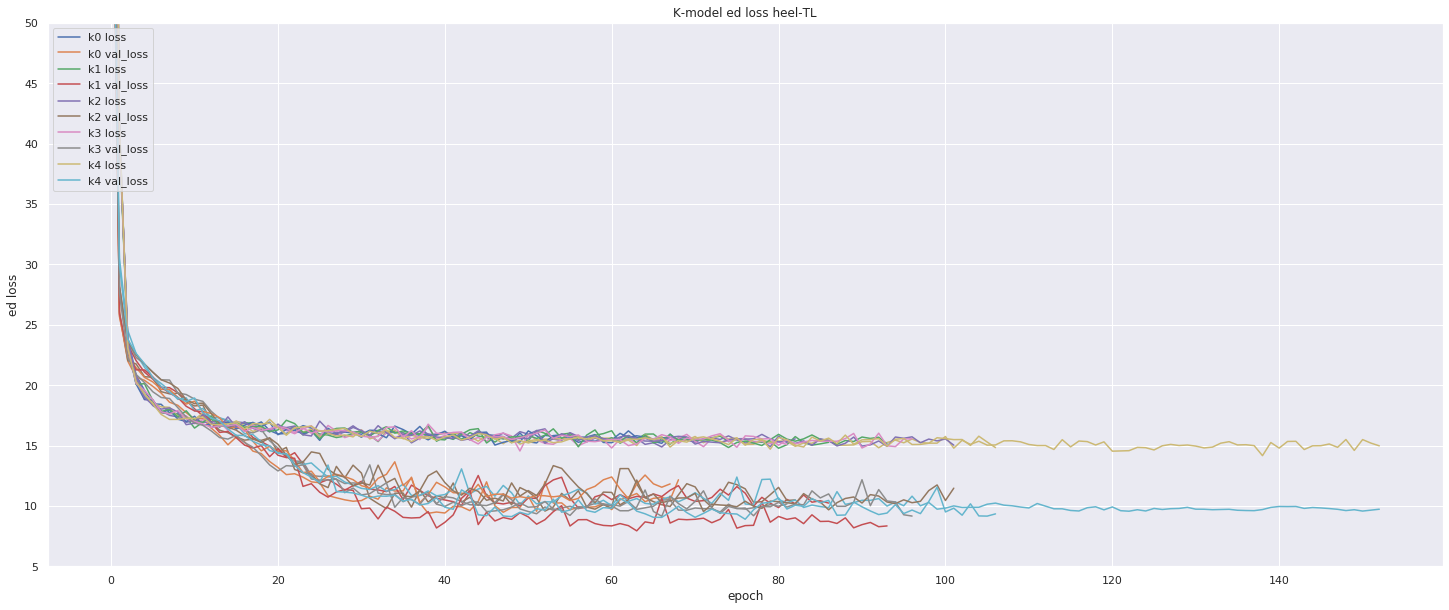

In [105]:
# Sum plot losses heel-tl

plt.figure(figsize=(25, 10))

for k in range(KFlodNum):

    plt.plot(history_heel[k].history['loss'])
    plt.plot(history_heel[k].history['val_loss'])

    
plt.title('K-model ed loss heel-TL')
plt.ylabel('ed loss'), plt.ylim(5, 50)# for too large loss
plt.xlabel('epoch')
plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_Ksum_TL.png', bbox_inches = 'tight')

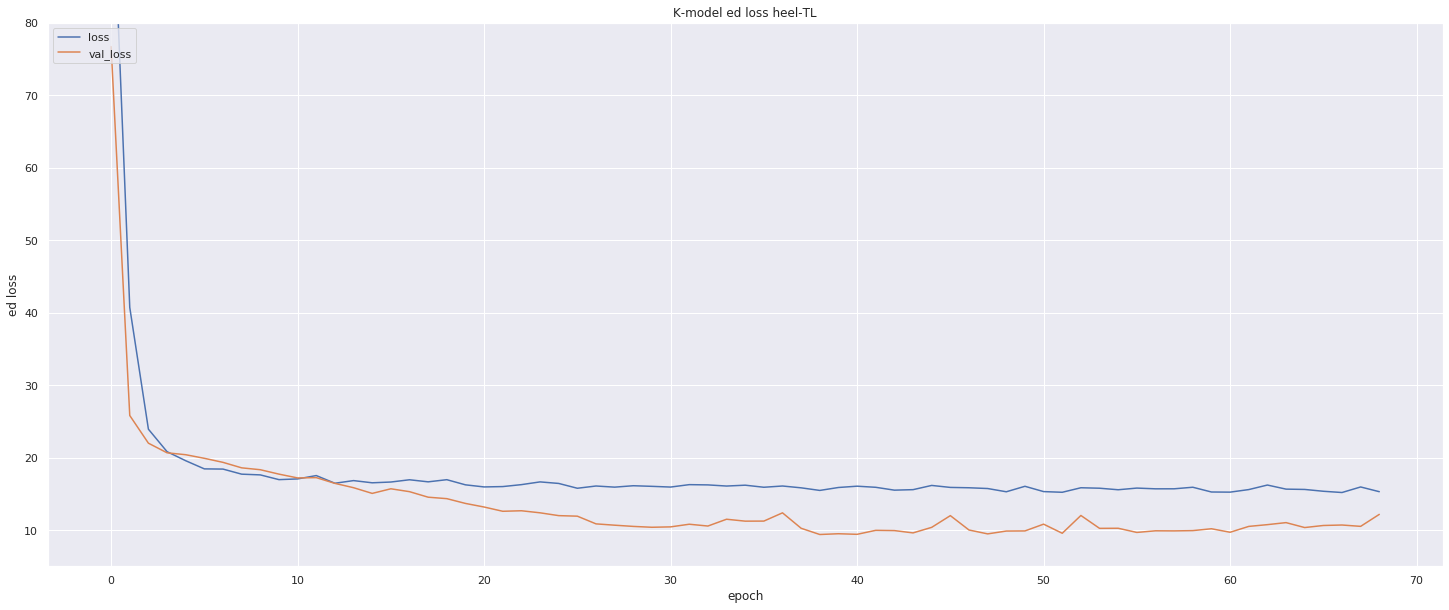

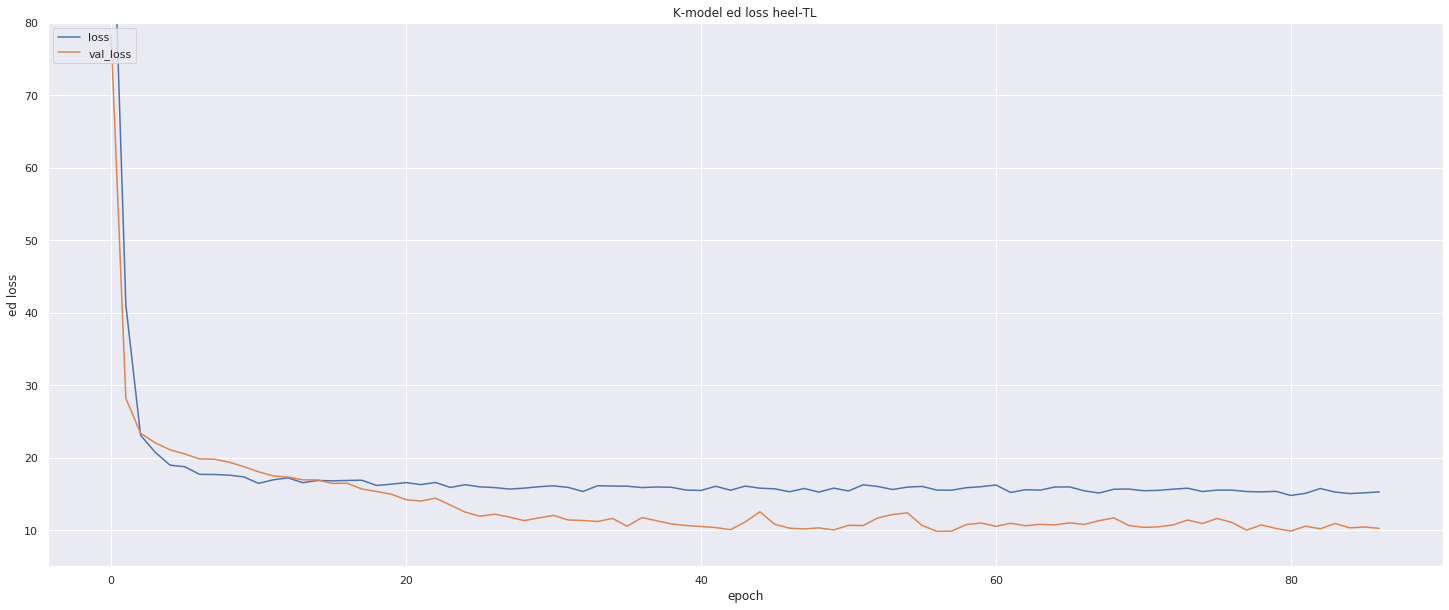

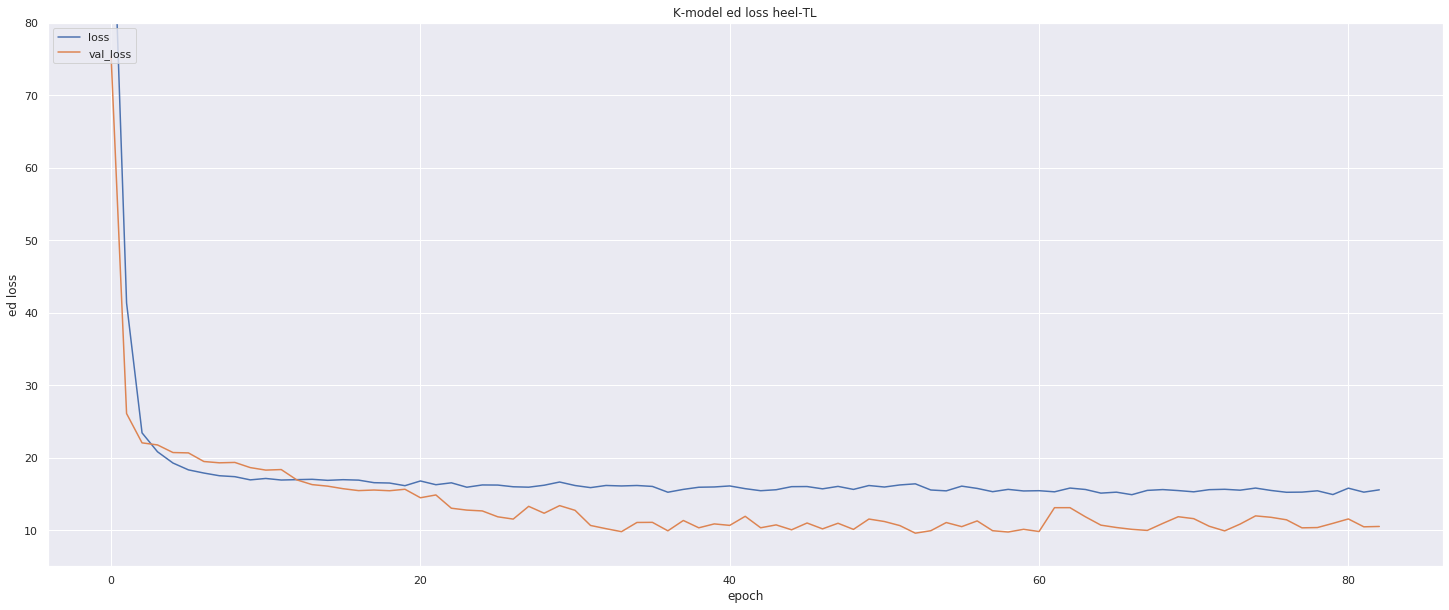

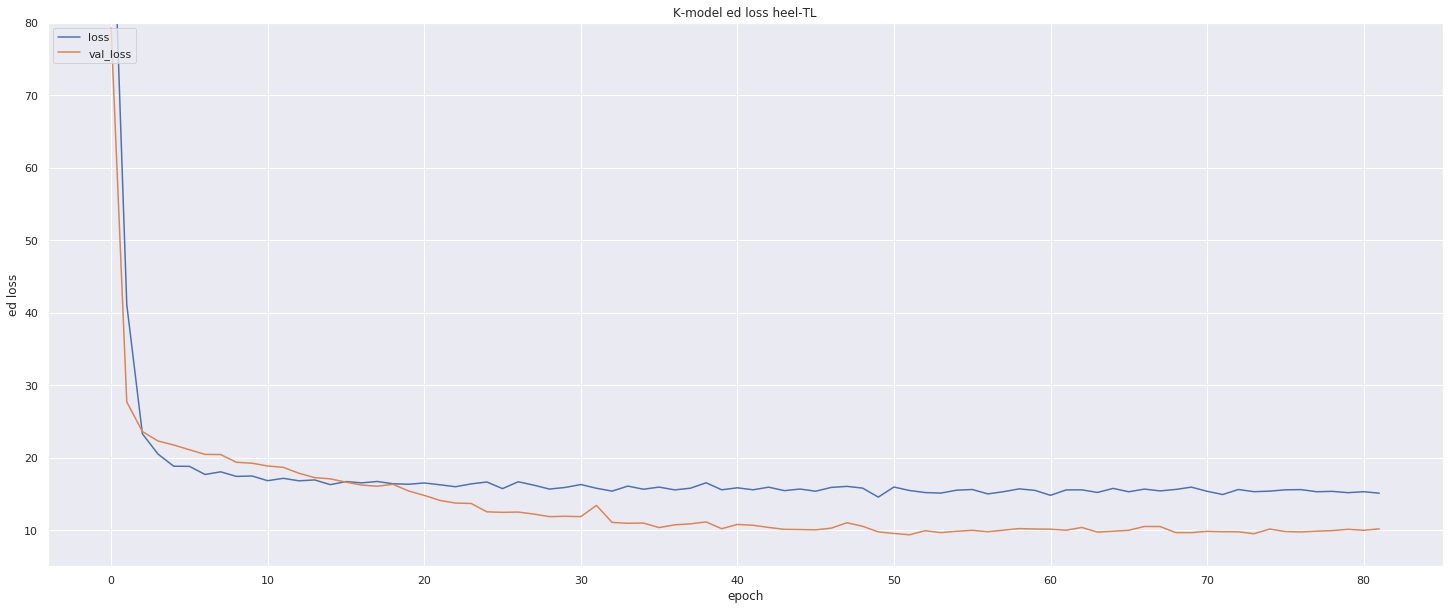

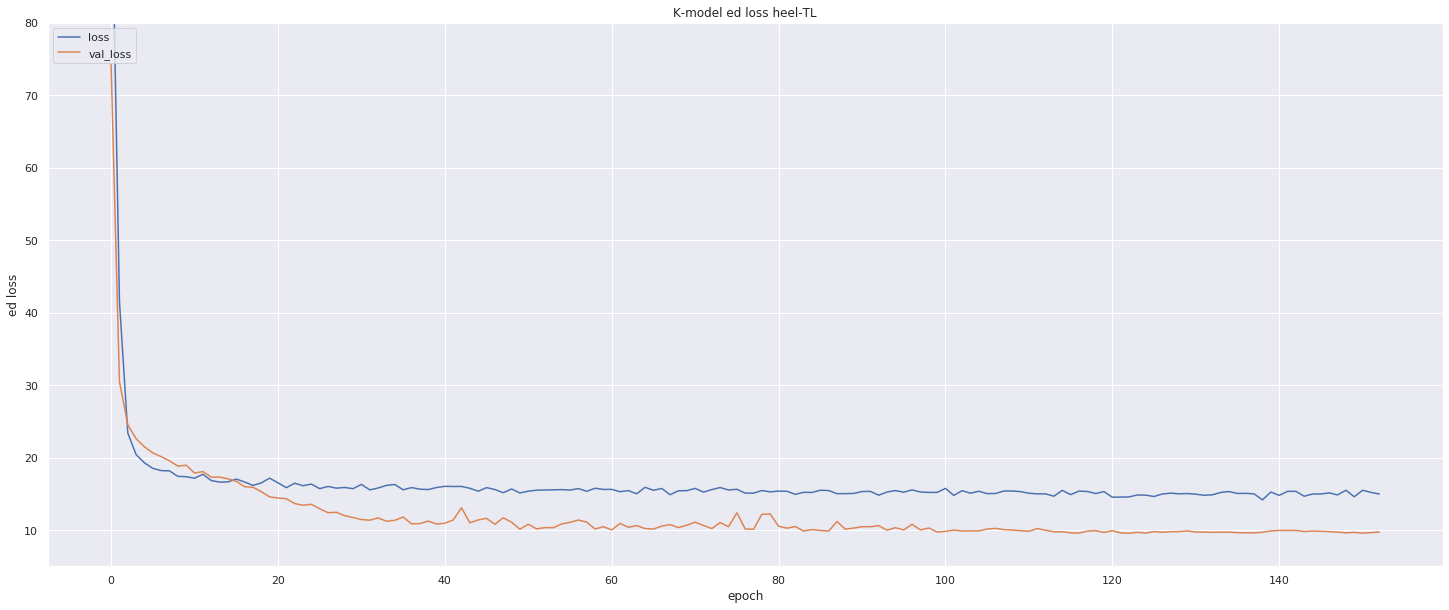

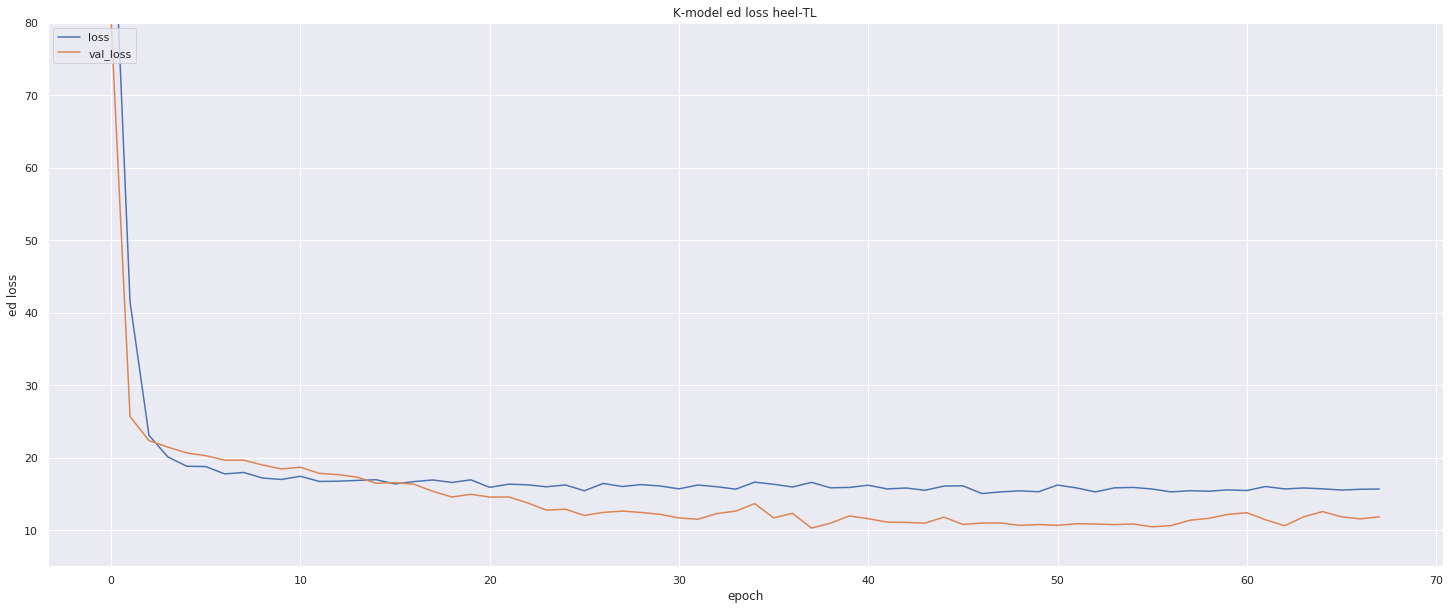

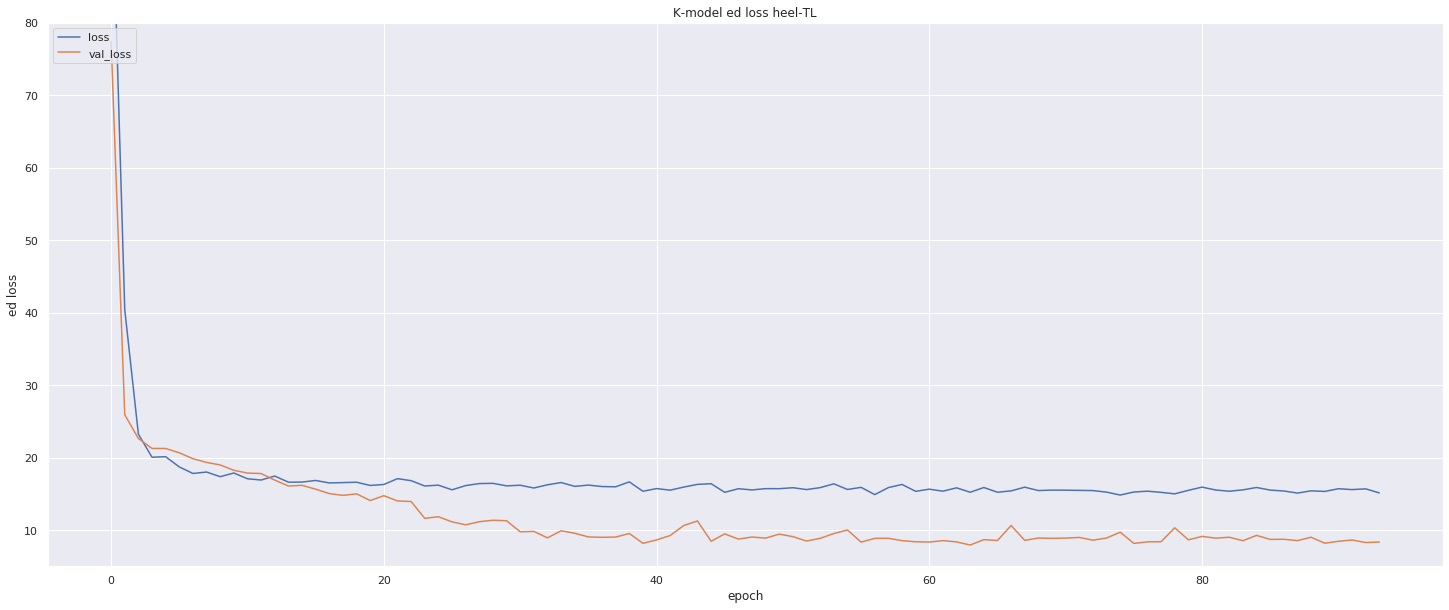

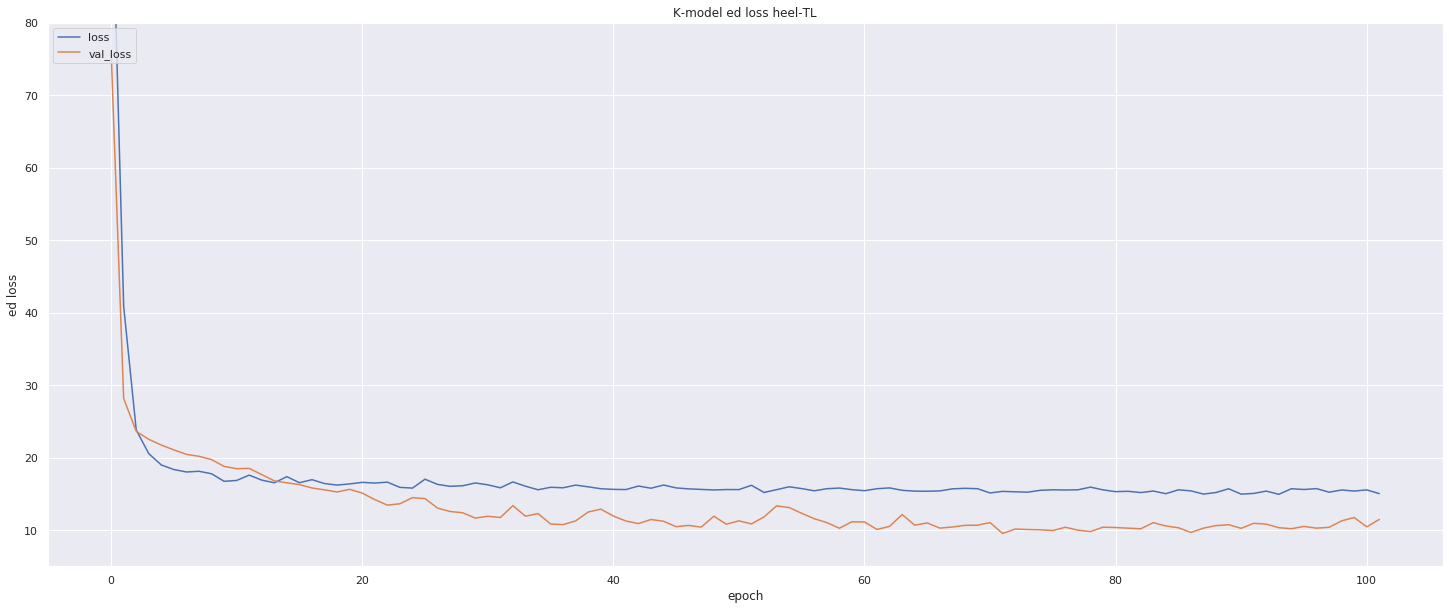

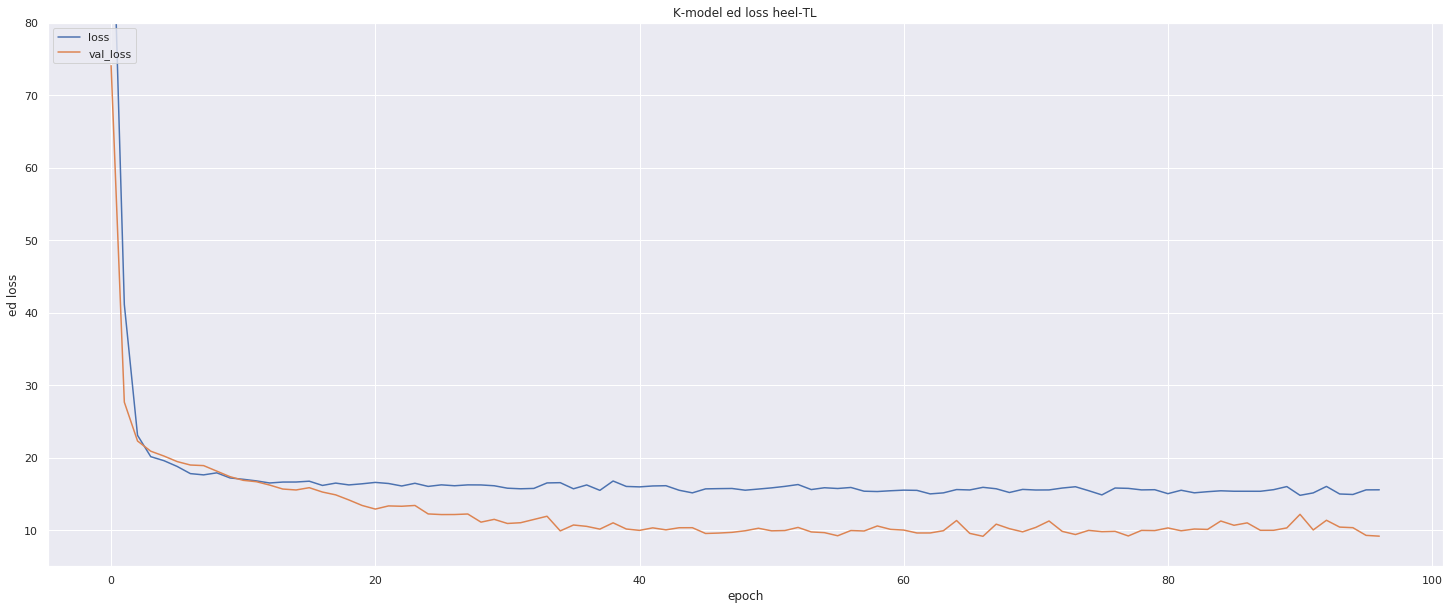

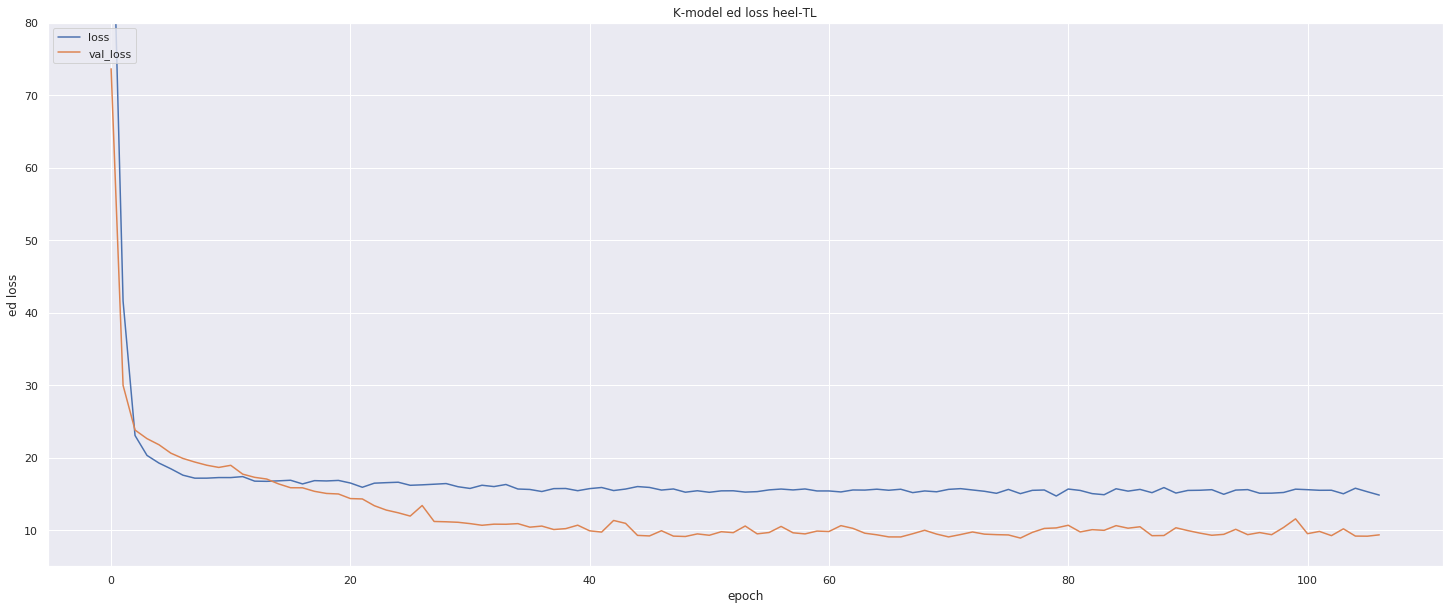

In [106]:
# Single plot loss heel-tl

for k in range(KFlodNum):
    plt.figure(figsize=(25, 10))
    plt.plot(history_heel[k].history['loss'])
    plt.plot(history_heel[k].history['val_loss'])
    plt.title('K-model ed loss heel-TL')
    plt.ylabel('ed loss'), plt.ylim(5, 80)# for too large loss
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left') 
    # plt.show()

    # save plot : comment plo.show in jupyter notebook.
    def get_valloss(his_v_l):   
        return np.min(his_v_l), np.argmin(his_v_l)

    vl, ep = get_valloss(history_heel[k].history['val_loss'])
    plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_K{k}_TL_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9


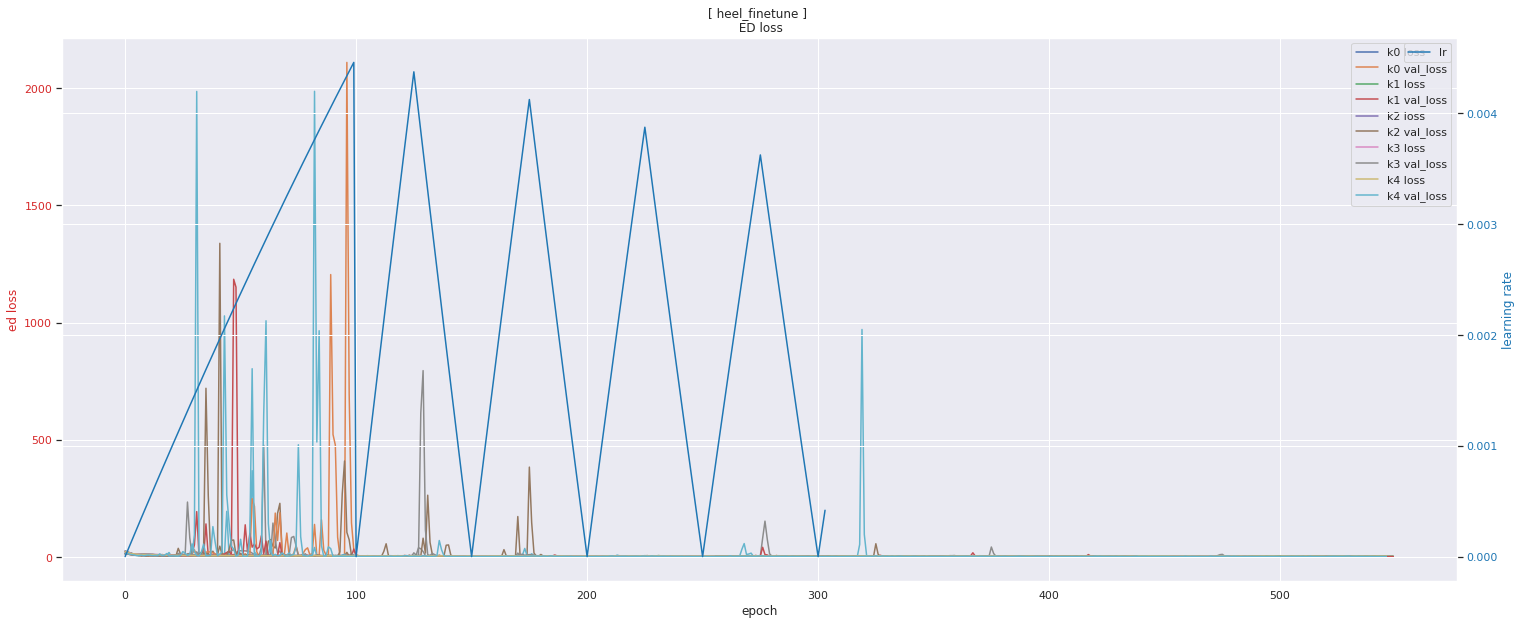

In [107]:
# check the loos the model trained.

def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

# t_vl = []
h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
#     t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
    h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    h_vl.append(h_v)
    
# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('[ heel_finetune ] \n ED loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

for k in range(KFlodNum):

    plt.plot(history_heel_finetune[k].history['loss'])
    plt.plot(history_heel_finetune[k].history['val_loss'])

ax1.tick_params(axis='y', labelcolor=color)
# ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.
ax1.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper right') 

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_heel_finetune[0].history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['lr'], loc='upper right') 

# plt.show()

# # save plot : comment plo.show in jupyter notebook.
# def get_valloss(his_v_l):   
#     return np.min(his_v_l), np.argmin(his_v_l)

# vl, ep = get_valloss(history_toe_finetune.history['val_loss'])


# t_vl = np.mean(t_vl, axis=0)
h_vl = np.mean(h_vl, axis=0)
plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_ft_Ksum-clr_ed{round(h_vl,4)}.png', bbox_inches = 'tight')

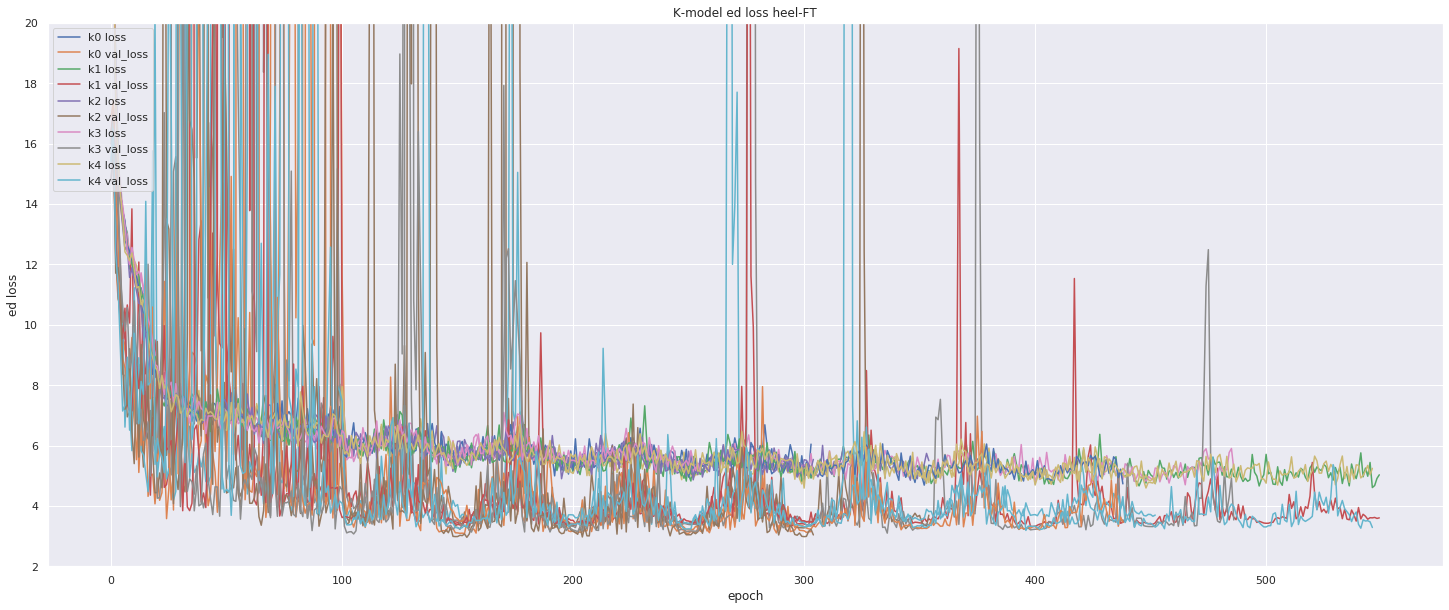

In [108]:
# Sum plot losses heel-ft

plt.figure(figsize=(25, 10))

for k in range(KFlodNum):

    plt.plot(history_heel_finetune[k].history['loss'])
    plt.plot(history_heel_finetune[k].history['val_loss'])

    
plt.title('K-model ed loss heel-FT')
plt.ylabel('ed loss'), plt.ylim(2, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_Ksum_FT.png', bbox_inches = 'tight')

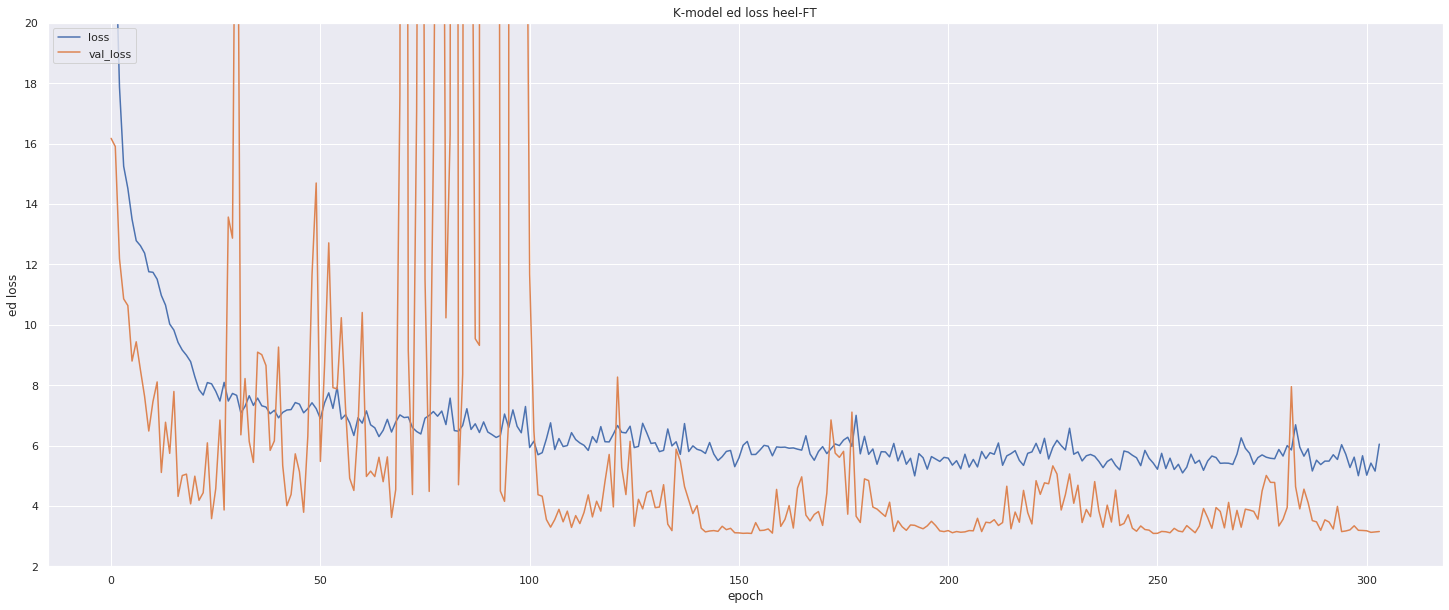

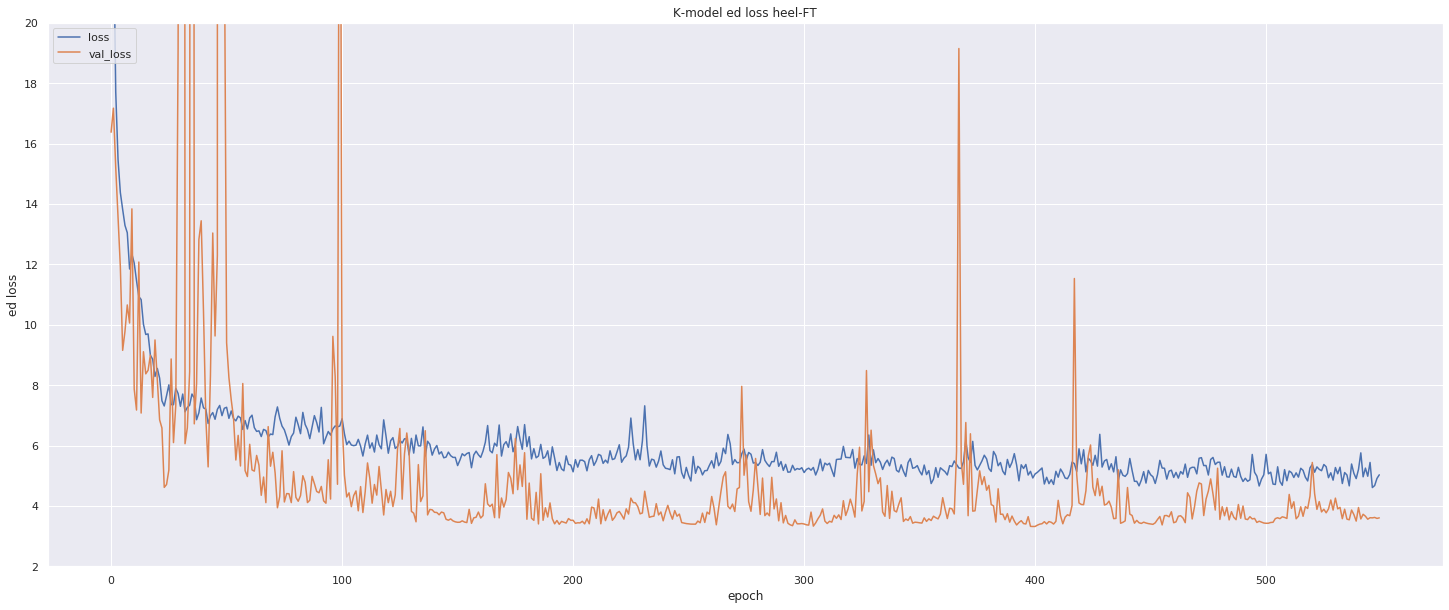

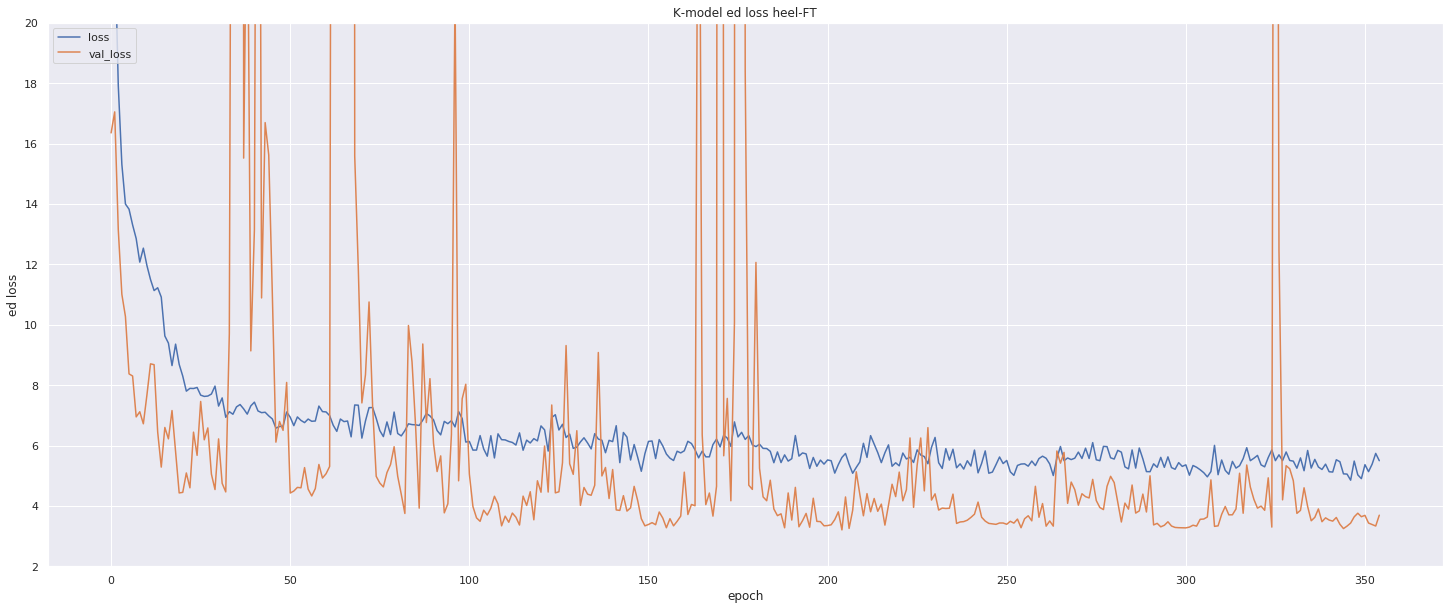

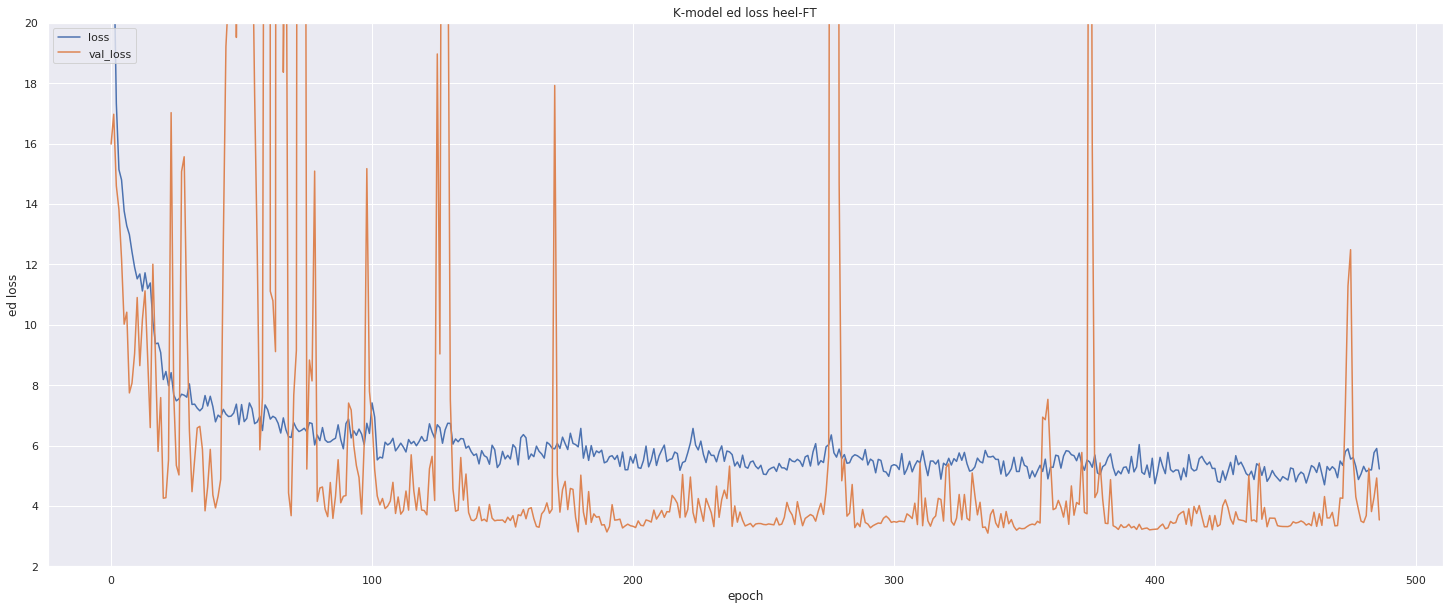

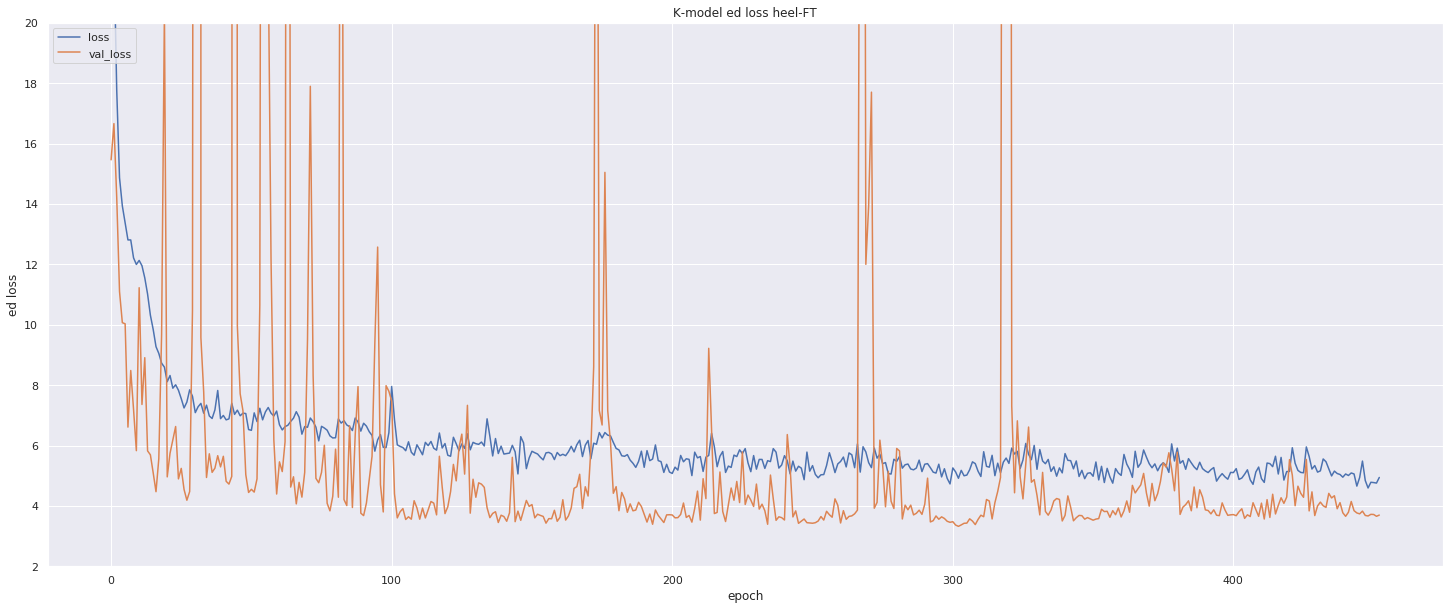

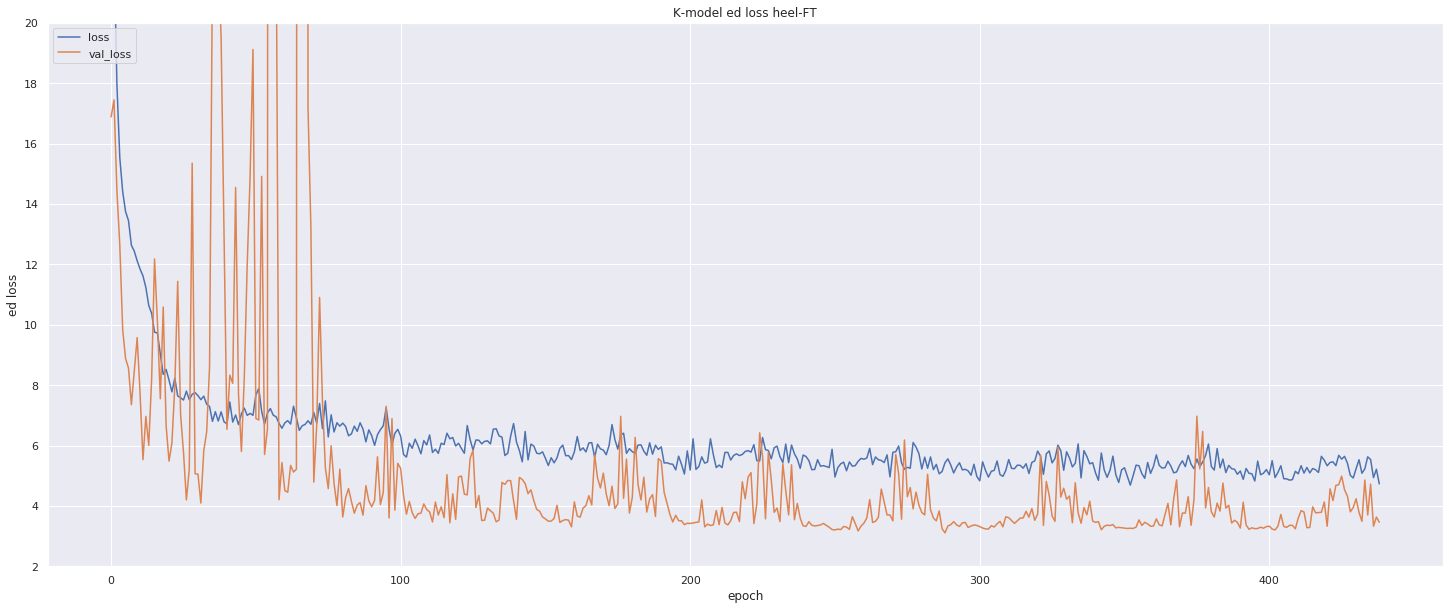

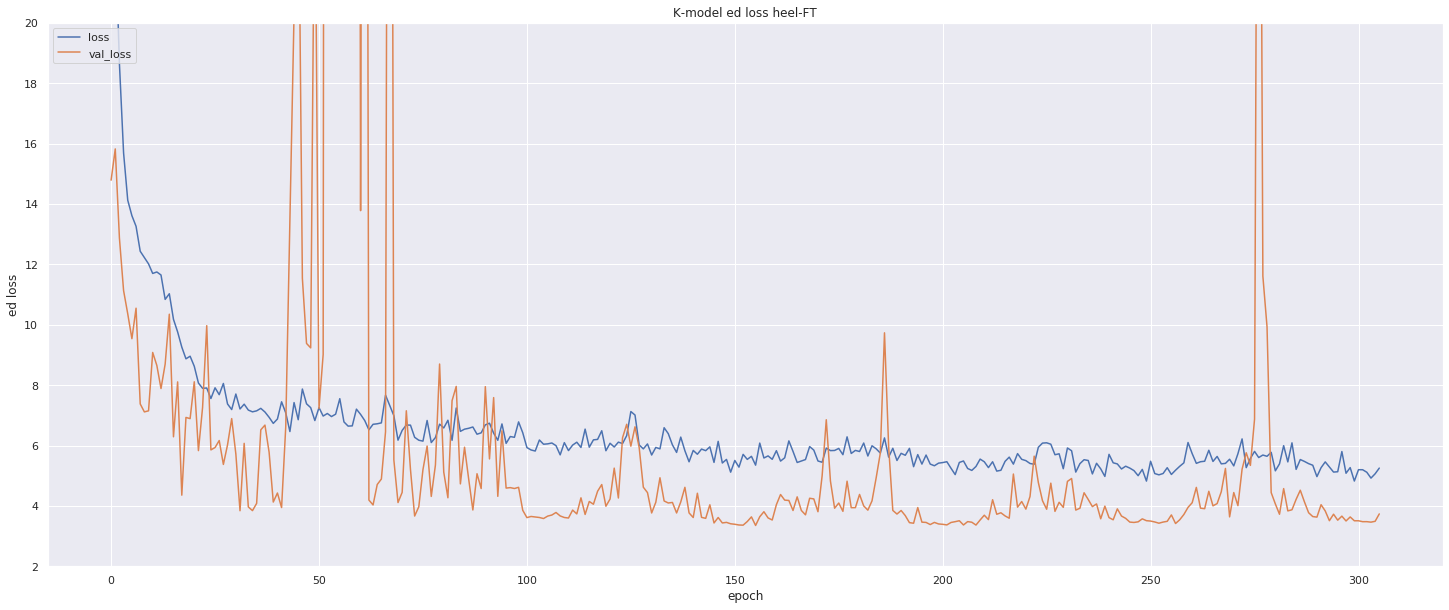

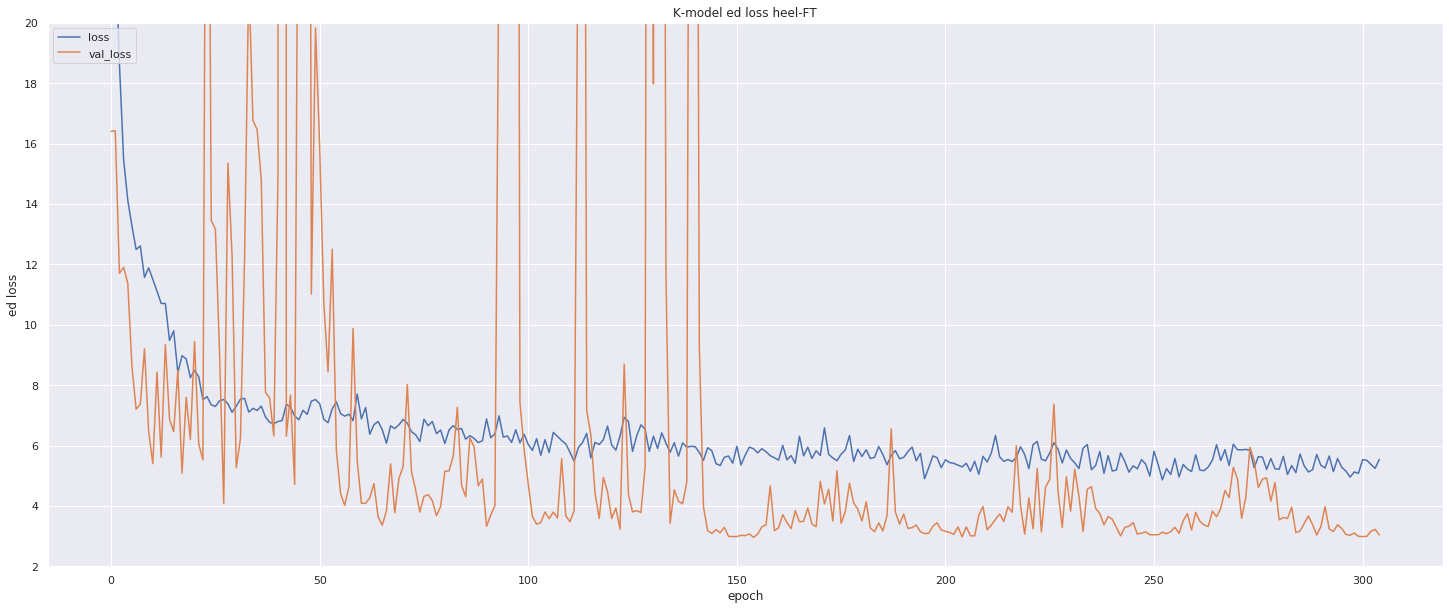

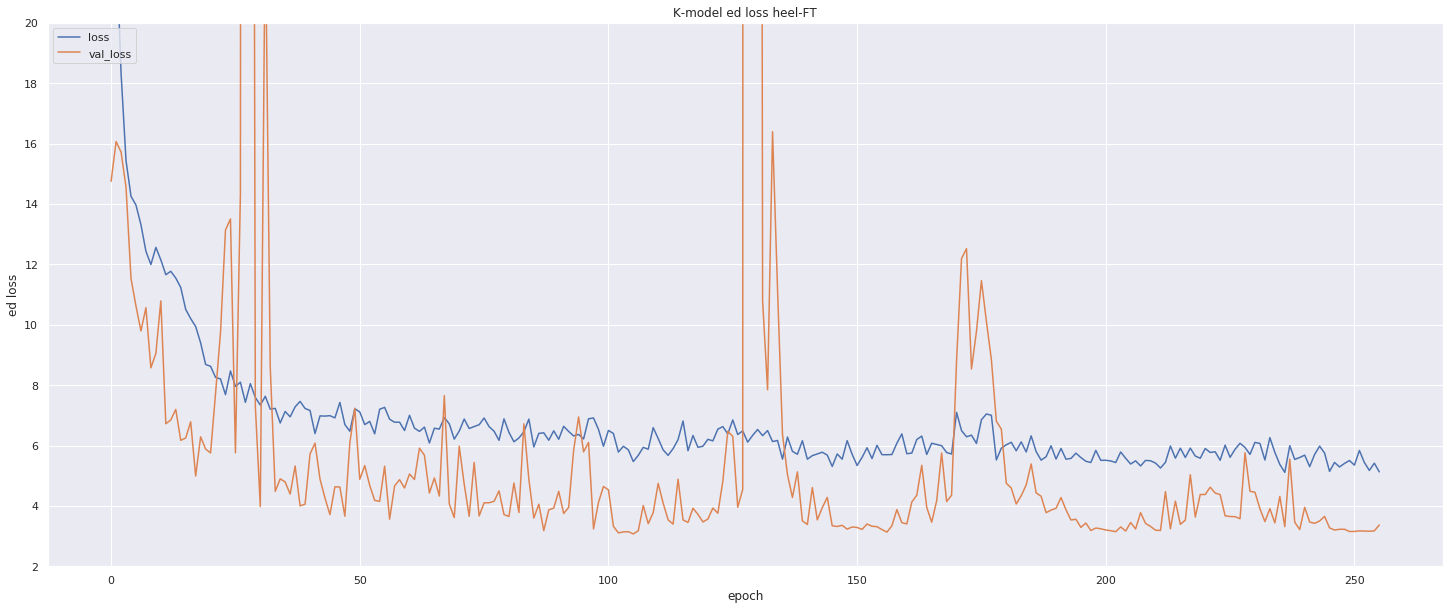

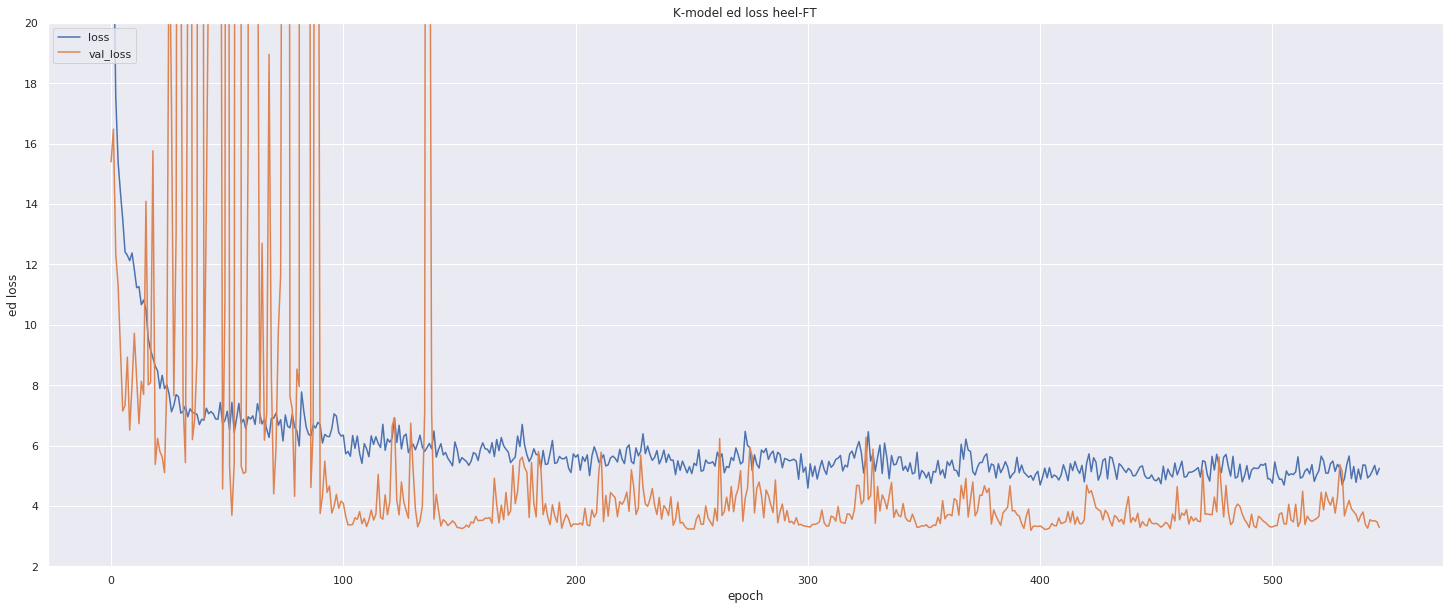

In [109]:
# Single plot loss heel-FT

for k in range(KFlodNum):
    plt.figure(figsize=(25, 10))
    plt.plot(history_heel_finetune[k].history['loss'])
    plt.plot(history_heel_finetune[k].history['val_loss'])
    plt.title('K-model ed loss heel-FT')
    plt.ylabel('ed loss'), plt.ylim(2, 20)# for too large loss
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left') 
    # plt.show()

    # save plot : comment plo.show in jupyter notebook.
    def get_valloss(his_v_l):   
        return np.min(his_v_l), np.argmin(his_v_l)

    vl, ep = get_valloss(history_heel_finetune[k].history['val_loss'])
    plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_K{k}_FT_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

### Ploting your model

In [110]:
# model_toe.summary()

In [111]:
# # show after modl.fit
# model_toe.metrics_names

In [112]:
# # check metrics the model have.
# history_toe.history.keys()

In [113]:
# tf.keras.utils.plot_model(model_toe, show_shapes=True)

In [114]:
# from tensorflow.keras.utils import plot_model
# plot_model(model_toe, to_file='model_toe_conv_layer_blocks.png', show_shapes=True)
# from IPython.display import Image
# Image(filename='model_toe_conv_layer_blocks.png') 

## show pp pred

* we can switch toe/hell by comment it

### EFN Toe

In [115]:
# it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
# # it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

In [116]:
# %%time

# # image_batch, label_batch = next(valid_ds_pre_toe_s)

# image_batch, label_batch = next(it_valid_ds_pre_toe_s)
# # image_batch, label_batch = next(it_valid_ds_pre_heel_s)


# pred = model_toe.predict_on_batch(image_batch) #predictions
# # pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

# plt.figure(figsize=(20, 20))
# for i in range(64):
#     ax = plt.subplot(8, 8, i + 1)
#     plt.imshow(image_batch[i])
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")
    
#     # note: y_offset_toe for ds image
    
#     #ground truth
#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=2)

#     #pred
#     plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=2)

In [117]:
# #test_ds一次做完即可不用分batch
# neg = label_batch - pred
# neg[:5]

In [118]:
# np.abs(neg)[:5]

In [119]:
# neg_abs = np.abs(neg)
# neg_abs.mean(axis=0)#所有x 所有y個別平均  neg.mean(axis=0)#所有x 所有y個別平均

#### ED 2D

In [120]:
# # y_pred = neg_abs.mean(axis=0)
# ed_metric_2d([0,0], [neg_abs.mean(axis=0)]).numpy()

### EFN Heel

In [121]:
# # it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
# it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

In [122]:
# %%time

# # image_batch, label_batch = next(valid_ds_pre_toe_s)

# # image_batch, label_batch = next(it_valid_ds_pre_toe_s)
# image_batch, label_batch = next(it_valid_ds_pre_heel_s)


# pred = model_heel.predict_on_batch(image_batch) #predictions
# # pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

# plt.figure(figsize=(20, 20))
# for i in range(64):
#     ax = plt.subplot(8, 8, i + 1)
#     plt.imshow(image_batch[i])
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")
    
#     # note: y_offset_toe for ds image
    
#     #ground truth
#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=2)

#     #pred
#     plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=2)

In [123]:
# pred[:5]

In [124]:
# label_batch[:5]

In [125]:
# #test_ds一次做完即可不用分batch
# neg = label_batch - pred
# neg[:10]

In [126]:
# np.abs(neg)[:10]

In [127]:
# neg_abs = np.abs(neg)
# neg_abs.mean(axis=0)#所有x 所有y個別平均  neg.mean(axis=0)#所有x 所有y個別平均

#### ED 2d

In [128]:
# # y_pred = neg_abs.mean(axis=0)
# ed_metric_2d([0,0], [neg_abs.mean(axis=0)]).numpy()

# Merg Toe/Heel model and predict the Test data at once

### Create TEST DS

In [129]:
# ts = 'test_submission.csv'
# df_ts = pd.read_csv(ts)
# df_ts.head(5)

In [130]:
# df_ts['images']

In [131]:
# # from dataframe
# list_ds_test = tf.data.Dataset.from_tensor_slices(df_ts['images'])


In [132]:
# len(list_ds_test)#.shape() #take(1)

In [133]:
# # check The type specification of an element of this dataset.
# list_ds_test.element_spec

In [134]:
# for f in list_ds_test.take(5):
#     print(f'take test sample: {f}')

### TEST DS: Process TEST path to image tensor

In [135]:
# ## TEST-DS: re-used from train/val-ds

# im_test = 'test_images/'

# '''
# def get_label(file_path):
#     # convert the path to a list of path components
#     parts = tf.strings.split(file_path, os.path.sep)
#     # The second to last is the class-directory
#     boolen = parts[-2] == class_names
#     #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
#     one_hot_num = tf.dtypes.cast(boolen, tf.int64)
#     one_num = tf.argmax(one_hot_num)
#     print('one_num:', one_num)
#     # Integer encode the label
#     return one_num

# def decode_img(img):
#     # convert the compressed string to a 3D uint8 tensor
#     img = tf.io.decode_jpeg(img, channels=3)
#     # resize the image to the desired size
# #     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
#     return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
# '''

# #
# # map list to ds, Toe part.
# #

# def decode_crop_png_toe_test(img):
#     # convert the compressed string to a 3D uint8 tensor
#     img = tf.io.decode_png(img, channels=3)
#     # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
#     y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
#     img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
#     #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
#     # resize the image to the desired size
#     return img

# def process_path_toe_test(file_name):
#     file_path = im_test + file_name
#     #label = get_label(file_path)
#     # load the raw data from the file as a string
#     img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
#     img = decode_crop_png_toe_test(img)
#     return img, file_name

# #
# # map list to ds, Heel part.
# #

# def decode_crop_png_heel_test(img):
#     # convert the compressed string to a 3D uint8 tensor
#     img = tf.io.decode_png(img, channels=3)
#     # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
#     y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
#     img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
#     #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
#     # resize the image to the desired size
#     return img

# def process_path_heel_test(file_name):
#     file_path = im_test + file_name
#     #label = get_label(file_path)
#     # load the raw data from the file as a string
#     img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
#     img = decode_crop_png_heel_test(img)
#     return img, file_name


# #
# # test how to put parameters to map
# #

# def t_ds_map(file_path,x1,y1,x2,y2):
# #     img = get_img('train/images/' + str(file_path))
# #     print(file_path)
#     return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [136]:
# # TEST Toe ds
# test_ds_map_toe = list_ds_test.map(process_path_toe_test, num_parallel_calls=AUTOTUNE)

# # TEST Heel ds
# test_ds_map_heel = list_ds_test.map(process_path_heel_test, num_parallel_calls=AUTOTUNE)

In [137]:
# for img, file_name in test_ds_map_toe.take(5):
#     print(f'take sample: {img.shape} {file_name}')
    
# # print('f', f.dtype)
# # print('xy', xy.dtype)

### prepare TEST_ds_pre

In [138]:
# def configure_for_performance_cache_test(ds, cache=True):

#     if cache:
#         ds = ds.cache()
#         print("Check cache in memory:Y", cache)
#     else:
#         print("Check cache in memory:N", cache)
        
# #     if augment:
# # #         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
# #         ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
# # #         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
# #         print("Check augment :Y", augment)
# #     else:
# #         print("Check augment :N", augment)
    
# #     #ds = ds.repeat()#TODO:2020-12-14: test
# #     ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
# #     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
#     ds = ds.batch(1000)# 1k for foot test images #MULTI_BATCH_SIZE for multi-GPUs
#     ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
#     return ds


In [139]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # TEST Toe ds_pre
# test_ds_pre_toe = configure_for_performance_cache_test(test_ds_map_toe)

# # TEST Heel ds_pre
# test_ds_pre_heel = configure_for_performance_cache_test(test_ds_map_heel)

# Load Best-K-models

In [140]:
# # if K-models are in last time frame
# # best_model_name = get_best_model_name(th, K=str(k))

# predictions_toe = []
# predictions_heel = []

# for k in range(KFlodNum):
#     print(f'K:{k}')
#     best_model_toe_name = get_best_model_name('toe', K=str(k))
#     best_model_heel_name = get_best_model_name('heel', K=str(k))

# # # if models are in last time frame
# # best_model_toe_name = get_best_model_name('toe')
# # best_model_heel_name = get_best_model_name('heel')

# # # if toe/heel are in different time frame
# # best_model_toe_name = '20210118-212454/toe_EfficientNetB0_bs64_w120_best_val_loss.h5'#6.3318 @e393
# # best_model_heel_name = '20210122-084854/heel_EfficientNetB0_bs64_w120_best_val_loss.h5'#3.27979@152




#     print(best_model_toe_name)
#     print(best_model_heel_name)
#     # log_dir_name + '/' + 'leaf-2020-12-01-EfficientNetB7_top-layer50_lr_lrfn_val-acc.8352_wh512_e37.h5'

#     best_model_toe = tf.keras.models.load_model(best_model_toe_name,compile=False)
#     best_model_heel = tf.keras.models.load_model(best_model_heel_name,compile=False)
    
#     best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])
#     best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])
        
        
#     pred_toe = best_model_toe.predict(test_ds_pre_toe)
#     pred_toe[:,1] = pred_toe[:,1] + y_offset_toe
#     predictions_toe.append(pred_toe)
    
#     pred_heel = best_model_heel.predict(test_ds_pre_heel)
#     pred_heel[:,1] = pred_heel[:,1] + y_offset_heel
#     predictions_heel.append(pred_heel)
    
    

In [141]:
# len(predictions_toe[0])

In [142]:
# # make sure we got the k-pred as k models.
# for i, _ in enumerate(predictions_toe):
#     print(i)

In [143]:
# np.shape(predictions_toe)

In [144]:
# predictions_toe[0]

In [145]:
# predictions_toe[1]

In [146]:
# predictions_heel[0]

In [147]:
# predictions_heel[1]

In [148]:
# # mean the k-predictions
# k_predictions_toe = np.mean(predictions_toe, axis=0)
# k_predictions_toe

In [149]:
# np.shape(k_predictions_toe)

In [150]:
# # mean the k-predictions
# k_predictions_heel = np.mean(predictions_heel, axis=0)
# k_predictions_heel

### Merge toe/hell pred

In [151]:
# predictions_th = np.append(k_predictions_toe, k_predictions_heel, axis=1)#左右接
# predictions_th.shape

In [152]:
# images_name = np.expand_dims(df_ts['images'], axis=1)
# images_name.shape

In [153]:
# predictions_merge = np.append(images_name, predictions_th, axis=1)#左右接
# predictions_merge.shape

In [154]:
# df_submission = pd.DataFrame(predictions_merge)
# df_submission.columns = ['images','x1','y1','x2','y2']

In [155]:
# submi_name = CSVNAME + '.' + log_dir_name +'.csv'

# df_submission.to_csv(submi_name, index=False)
# print('Save {} as submission CSV.'.format(submi_name))

In [156]:
# df_submission.head()

In [157]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

# t_vl = []
h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
#     t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
    h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
#     t_vl.append(t_v)
    h_vl.append(h_v)

# t_vl = np.mean(t_vl, axis=0)
h_vl = np.mean(h_vl, axis=0)
# print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')
print(f'Heel ED = {round(h_vl,5)}')

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9
Heel ED = 3.17099


In [158]:
# K134520210224-114845.csv
# 5.63922 + 3.34466 = 8.98389 LB:8.4890610

In [159]:
# t_vl

In [160]:
h_vl

3.1709877967834474

In [161]:
t_timer.toc() #Time elapsed since t.tic()

Elapsed time is 27588.059716 seconds.


### compile the model separately afterwards. to load model with custom loss function

* https://github.com/tensorflow/tensorflow/issues/32348

In [162]:
# best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])
# best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])

# best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=tf.keras.losses.MeanSquaredError())#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])
# best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=tf.keras.losses.MeanSquaredError())#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])

    

In [163]:
# %%time
# # inference all test_ds once
# predictions_toe = best_model_toe.predict(test_ds_pre_toe)
# predictions_toe.shape

### Offset Toe

In [164]:
# predictions_toe[:,1] = predictions_toe[:,1] + y_offset_toe

# # for [0,1]
# # predictions_toe[:,0] = predictions_toe[:,0]*120
# # predictions_toe[:,1] = predictions_toe[:,1]*120 + y_offset_toe

# # # for [-1,1]
# # # for re-scale back xy 
# # # return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] 
# # # return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] 
# # predictions_toe[:,0] = (predictions_toe[:,0]*60)+60
# # predictions_toe[:,1] = (predictions_toe[:,1]*60)+60 + y_offset_toe

# predictions_toe

In [165]:
# %%time
# # inference all test_ds once
# predictions_heel = best_model_heel.predict(test_ds_pre_heel)
# predictions_heel.shape

### Offset Heel

In [166]:
# predictions_heel[:,1] = predictions_heel[:,1] + y_offset_heel

# # for [0,1]
# # predictions_heel[:,0] = predictions_heel[:,0]*120
# # predictions_heel[:,1] = predictions_heel[:,1]*120 + y_offset_heel

# # # for [-1,1]
# # predictions_heel[:,0] = (predictions_heel[:,0]*60)+60
# # predictions_heel[:,1] = (predictions_heel[:,1]*60)+60 + y_offset_heel

# predictions_heel

### Merge toe/hell pred

In [167]:
# predictions_th = np.append(predictions_toe, predictions_heel, axis=1)#左右接
# predictions_th.shape

In [168]:
# images_name = np.expand_dims(df_ts['images'], axis=1)
# images_name.shape

In [169]:
# predictions_merge = np.append(images_name, predictions_th, axis=1)#左右接
# predictions_merge.shape

In [170]:
# df_submission = pd.DataFrame(predictions_merge)
# df_submission.columns = ['images','x1','y1','x2','y2']

In [171]:
# submi_name = '0000_ft_' + log_dir_name +'.csv'
# # submi_name = 'Bth_clr3_2690_XYnorm[0-1]_' + log_dir_name +'.csv'
# df_submission.to_csv(submi_name, index=False)
# print('Save {} as submission CSV.'.format(submi_name))

In [172]:
#Bth_clr3_2690_ed_findtune_20210202-141718.csv

#toe.9.9/heel.4.4 109 trainable LB:9.3411759 比heel保持top-20略高0.04 (9.3084957)

In [173]:
# df_submission.head()

In [174]:
# #ED sum
# def get_valloss(his_v_l):  
#     return np.min(his_v_l), np.argmin(his_v_l)

# t_vl, _ = get_valloss(history_toe_finetune.history['val_loss'])
# h_vl, _ = get_valloss(history_heel_finetune.history['val_loss'])

# print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

In [175]:
#

## save model

In [176]:

# best_model_name = './cop_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_e' + str(ep_num) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_.h5'
# # model.save(best_model_name)
# print("Save model: ", best_model_name)

## Reference

multi output model:
https://navoshta.com/end-to-end-deep-learning/

